In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 1.10.0+cu102
CUDA enabled: False


In [2]:
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import sys
import os
import pickle
import re
import csv
import multiprocessing

import pt_util

In [3]:
def prepare_data(dirpath):
    # Read train and test data
    filenames = os.listdir(dirpath)
    train_data = []
    test_data = []
    max_len = 0 # max length of any word in the dataset
    
    def get_most_annotated_transliterations(tsv_file, data, max_len):
        curr_lang = None
        max_annotations = 0
        curr_translits = {}

        # only consider the most annotated transliteration(s) for each foreign language word
        for lang, en, annotations in tsv_file:
            if not curr_lang or lang != curr_lang:
                for translit, annots in curr_translits.items():
                    if annots == max_annotations:
                        data.append([curr_lang, translit])
                        max_len = max(max_len, len(translit))
                curr_lang = lang
                max_annotations = annotations
                curr_translits = {en: annotations}
                max_len = max(max_len, len(curr_lang))
            else:
                max_annotations = max(max_annotations, annotations)
                curr_translits[en] = annotations
        for translit, annots in curr_translits.items(): # fencepost
            if annots == max_annotations:
                data.append([curr_lang, translit])
                max_len = max(max_len, len(translit))
        return max_len
    
    for filename in filenames:
        with open(os.path.join(dirpath, filename), 'r') as file:
            tsv = csv.reader(file, delimiter='\t')
            if filename.endswith('train.tsv'):
                max_len = get_most_annotated_transliterations(tsv, train_data, max_len)
            else:
                max_len = get_most_annotated_transliterations(tsv, test_data, max_len)
                
    return train_data, test_data, max_len

In [4]:
def create_dictionaries(data, PAD = '<PAD>'):
    #en_voc2ind = {PAD: 0}
    #lang_voc2ind = {PAD: 0}
    #en_ind2voc = {0: PAD}
    #lang_ind2voc = {0: PAD}
    
    en_voc2ind = {}
    lang_voc2ind = {}
    en_ind2voc = {}
    lang_ind2voc = {}
    
    en_ind = 0 #1
    lang_ind = 0 #1
    for lang, en in data:
        for lang_char in lang:
            if lang_char not in lang_voc2ind:
                lang_voc2ind[lang_char] = lang_ind
                lang_ind2voc[lang_ind] = lang_char
                lang_ind += 1
        for en_char in en:
            if en_char not in en_voc2ind:
                en_voc2ind[en_char] = en_ind
                en_ind2voc[en_ind] = en_char
                en_ind += 1
                
    en_voc2ind[PAD] = en_ind
    lang_voc2ind[PAD] = lang_ind
    en_ind2voc[en_ind] = PAD
    lang_ind2voc[lang_ind] = PAD
    
    return lang_voc2ind, lang_ind2voc, en_voc2ind, en_ind2voc

In [5]:
# Preprocessing functions
def tokenize_data(data, voc2ind):
    return [voc2ind[char] for char in data]

def detokenize_and_depad_data(data, ind2voc, pad_val=0):
    res = []
    for ind in data:
        if ind.item() == pad_val:
            break
        res.append(ind2voc[ind.item()])
    return res

def pad_data(data, seq_len, pad_val=0):
    for _ in range(len(data), seq_len):
        data.append(pad_val)
    return data

In [6]:
class TransliterateDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, lang_voc2ind, en_voc2ind, seq_len):
        super(TransliterateDataset, self).__init__()
        
        # Tokenize and pad data
        lang_data = []
        en_data = []
        for lang, en in data:
            lang_tokens = tokenize_data(lang, lang_voc2ind)
            lang_data.append(pad_data(lang_tokens, seq_len, len(lang_voc2ind) - 1))
            en_tokens = tokenize_data(en, en_voc2ind)
            en_data.append(pad_data(en_tokens, seq_len, len(en_voc2ind) - 1))
            
        self.language_data = lang_data
        self.english_data = en_data
        self.sequence_length = seq_len

    def __len__(self):
        return len(self.english_data)
        
    def __getitem__(self, idx):
        # Return the data and label at idx
        return torch.LongTensor(self.english_data[idx]), torch.LongTensor(self.language_data[idx])
    
    def get_random_sample(self):
        # Return a random data point and label: for testing purposes
        return self.__getitem__(np.random.randint(self.__len__()))

In [7]:
class TransliterateNet(nn.Module):
    
    def __init__(self, en_vocab_size, lang_vocab_size, feature_size, rnn_type):
        super(TransliterateNet, self).__init__()
        self.en_vocab_size = en_vocab_size
        self.lang_vocab_size = lang_vocab_size
        self.feature_size = feature_size
        
        self.encoder = nn.Embedding(self.en_vocab_size, self.feature_size)
        self.midLayer = nn.Linear(self.feature_size, self.feature_size)
        self.decoder = nn.Linear(self.feature_size, self.lang_vocab_size)
        
        if rnn_type == 'gru':
            self.rnn = nn.GRU(self.feature_size, self.feature_size, num_layers = 1, batch_first=True)
            self.rnn2 = nn.GRU(self.feature_size, self.feature_size, num_layers = 1, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(self.feature_size, self.feature_size, num_layers = 1, batch_first=True)
            self.rnn2 = nn.LSTM(self.feature_size, self.feature_size, num_layers = 1, batch_first=True)
        else:
            raise ValueError('RNN type must be either \'gru\' or \'lstm\'')

        #self.decoder.weight = self.encoder.weight
        #self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        x = self.encoder(x)
        x, hidden_state = self.rnn(x, hidden_state)
        x = self.midLayer(x)
        x = F.leaky_relu(x)
        x, hidden_state = self.rnn2(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.lang_vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [8]:
def repackage_hidden(h):
    # Wraps hidden states in new Tensors, to detach them from their history
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches.
        # Otherwise the backward would try to go all the way to the beginning every time
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader, en_ind2voc, lang_ind2voc):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    detokenize_and_depad_data(data[0], en_ind2voc, len(en_ind2voc) - 1),
                    detokenize_and_depad_data(label[0], lang_ind2voc, len(lang_ind2voc) - 1),
                    detokenize_and_depad_data(pred[0], lang_ind2voc, len(lang_ind2voc) - 1)))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [9]:
def main(LANG, RNN_TYPE):
    DATA_DIR = 'dakshina_dataset_v1.0'
    LANG_DIR = 'lexicons'
    DATA_PATH = '{}/{}/{}'.format(DATA_DIR, LANG, LANG_DIR)
    
    BATCH_SIZE = 512
    FEATURE_SIZE = 128
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.005
    # MOMENTUM = 0.9 # only for SGD
    WEIGHT_DECAY = 0.000005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    OUT_PATH = 'out/'
    LOG_PATH = OUT_PATH + 'logs/log.pkl'
    
    train_data, test_data, seq_len = prepare_data(DATA_PATH)
    lang_voc2ind, lang_ind2voc, en_voc2ind, en_ind2voc = create_dictionaries(train_data + test_data)
    train_dataset = TransliterateDataset(train_data, lang_voc2ind, en_voc2ind, seq_len)
    test_dataset = TransliterateDataset(test_data, lang_voc2ind, en_voc2ind, seq_len)
    
    use_cuda = USE_CUDA and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)
    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, drop_last=True,
                                              shuffle=False, **kwargs)
    
    model = TransliterateNet(len(en_voc2ind), len(lang_voc2ind), FEATURE_SIZE, RNN_TYPE).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    #optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(OUT_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader, en_ind2voc, lang_ind2voc)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))
    
    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader, en_ind2voc, lang_ind2voc)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            #pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            #model.save_best_model(test_accuracy, OUT_PATH + 'checkpoints/%03d.pt' % epoch)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        #print('Saving final model')
        #model.save_model(OUT_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        
        sns.set_theme()
        
        plt.figure(figsize=(12, 6))
        ep, val = zip(*train_losses)
        plt.plot(ep, val, label='Train Loss')
        ep, val = zip(*test_losses)
        plt.plot(ep, val, label='Test Loss')
        plt.title('Train and Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12, 6))
        ep, val = zip(*test_accuracies)
        plt.plot(ep, val)
        plt.title('Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show()
        
        return model, en_voc2ind, lang_ind2voc, seq_len, device

In [10]:
def generate_transliteration(word, model, en_voc2ind, lang_ind2voc, seq_len):
    transliteration = []
    hidden = None
    
    en_tokens = tokenize_data(word, en_voc2ind)
    en_data = torch.LongTensor(pad_data(en_tokens, seq_len))
    
    for c in torch.LongTensor(en_data):
        x, hidden = model.inference(c, hidden)
        transliteration.append(torch.argmax(x))
    
    return detokenize_and_depad_data(transliteration, lang_ind2voc, len(lang_ind2voc) - 1)

Using device cpu
num workers: 48
Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ௌ', '்', '்', 'ஆ', 'ஆ', 'ஆ', 'ஆ', 'ஆ', 'ஆ', 'ஆ', 'ஆ', 'ஆ', 'ஆ', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ௌ', 'ௌ', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['ௌ', '்', '்', 'ஆ', 'எ', 'ச', 'எ', 'எ', 'ை', 'ை', 'எ', 'எ', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['ௌ', '்', '்', 'த', 'எ', 'எ', 'எ', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை', 'ை']



Test set: Avera

  3%|▎         | 2/75 [00:00<00:15,  4.74it/s]

Train Epoch: 0 [0/38723 (0%)]	Loss: 3.849743


 16%|█▌        | 12/75 [00:02<00:12,  4.99it/s]

Train Epoch: 0 [5120/38723 (13%)]	Loss: 1.002081


 29%|██▉       | 22/75 [00:04<00:09,  5.43it/s]

Train Epoch: 0 [10240/38723 (27%)]	Loss: 1.067675


 43%|████▎     | 32/75 [00:06<00:07,  5.64it/s]

Train Epoch: 0 [15360/38723 (40%)]	Loss: 0.996262


 56%|█████▌    | 42/75 [00:08<00:06,  5.25it/s]

Train Epoch: 0 [20480/38723 (53%)]	Loss: 1.026766


 69%|██████▉   | 52/75 [00:09<00:04,  5.43it/s]

Train Epoch: 0 [25600/38723 (67%)]	Loss: 0.936178


 83%|████████▎ | 62/75 [00:11<00:02,  5.63it/s]

Train Epoch: 0 [30720/38723 (80%)]	Loss: 0.929662


 96%|█████████▌| 72/75 [00:13<00:00,  4.80it/s]

Train Epoch: 0 [35840/38723 (93%)]	Loss: 0.964160


100%|██████████| 75/75 [00:14<00:00,  5.25it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['வ', 'வ', 'வ', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ம', 'வ', 'த', 'வ', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['ம', 'வ', 'வ', 'வ', '்', '்', '்', '்', '்', '்', 'ி', 'ப']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'வ', 'வ', 'க', 'க', '்']



Test set: Average loss: 0.9092, Accuracy: 178700/239760 (75%)



  1%|▏         | 1/75 [00:00<00:13,  5.64it/s]

Train Epoch: 1 [0/38723 (0%)]	Loss: 1.019939


 16%|█▌        | 12/75 [00:02<00:11,  5.28it/s]

Train Epoch: 1 [5120/38723 (13%)]	Loss: 0.870619


 28%|██▊       | 21/75 [00:03<00:10,  5.24it/s]

Train Epoch: 1 [10240/38723 (27%)]	Loss: 0.955837


 43%|████▎     | 32/75 [00:05<00:07,  5.60it/s]

Train Epoch: 1 [15360/38723 (40%)]	Loss: 0.893153


 56%|█████▌    | 42/75 [00:07<00:05,  5.61it/s]

Train Epoch: 1 [20480/38723 (53%)]	Loss: 0.926928


 68%|██████▊   | 51/75 [00:09<00:04,  5.16it/s]

Train Epoch: 1 [25600/38723 (67%)]	Loss: 0.865360


 81%|████████▏ | 61/75 [00:11<00:02,  5.35it/s]

Train Epoch: 1 [30720/38723 (80%)]	Loss: 0.809724


 96%|█████████▌| 72/75 [00:13<00:00,  5.42it/s]

Train Epoch: 1 [35840/38723 (93%)]	Loss: 0.839695


100%|██████████| 75/75 [00:13<00:00,  5.39it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['வ', 'ா', '்', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'க', '்', 'க', '்', 'க', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ா', 'க', 'க']



Test set: Average loss: 0.7628, Accuracy: 187479/239760 (78%)



  1%|▏         | 1/75 [00:00<00:12,  5.80it/s]

Train Epoch: 2 [0/38723 (0%)]	Loss: 0.835298


 16%|█▌        | 12/75 [00:02<00:15,  4.10it/s]

Train Epoch: 2 [5120/38723 (13%)]	Loss: 0.711159


 29%|██▉       | 22/75 [00:04<00:09,  5.45it/s]

Train Epoch: 2 [10240/38723 (27%)]	Loss: 0.902676


 43%|████▎     | 32/75 [00:06<00:07,  5.48it/s]

Train Epoch: 2 [15360/38723 (40%)]	Loss: 0.802830


 56%|█████▌    | 42/75 [00:08<00:06,  5.47it/s]

Train Epoch: 2 [20480/38723 (53%)]	Loss: 0.870019


 69%|██████▉   | 52/75 [00:10<00:04,  5.07it/s]

Train Epoch: 2 [25600/38723 (67%)]	Loss: 0.779193


 83%|████████▎ | 62/75 [00:11<00:02,  5.36it/s]

Train Epoch: 2 [30720/38723 (80%)]	Loss: 0.768270


 96%|█████████▌| 72/75 [00:13<00:00,  5.40it/s]

Train Epoch: 2 [35840/38723 (93%)]	Loss: 0.790292


100%|██████████| 75/75 [00:14<00:00,  5.23it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', '்', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ா', '்', '்', 'க']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ா', '்']



Test set: Average loss: 0.7082, Accuracy: 189734/239760 (79%)



  1%|▏         | 1/75 [00:00<00:13,  5.62it/s]

Train Epoch: 3 [0/38723 (0%)]	Loss: 0.813106


 15%|█▍        | 11/75 [00:02<00:11,  5.54it/s]

Train Epoch: 3 [5120/38723 (13%)]	Loss: 0.669920


 29%|██▉       | 22/75 [00:04<00:09,  5.34it/s]

Train Epoch: 3 [10240/38723 (27%)]	Loss: 0.902712


 43%|████▎     | 32/75 [00:06<00:07,  5.40it/s]

Train Epoch: 3 [15360/38723 (40%)]	Loss: 0.749434


 56%|█████▌    | 42/75 [00:07<00:06,  5.41it/s]

Train Epoch: 3 [20480/38723 (53%)]	Loss: 0.814366


 69%|██████▉   | 52/75 [00:09<00:04,  5.48it/s]

Train Epoch: 3 [25600/38723 (67%)]	Loss: 0.743319


 83%|████████▎ | 62/75 [00:11<00:02,  5.24it/s]

Train Epoch: 3 [30720/38723 (80%)]	Loss: 0.697120


 96%|█████████▌| 72/75 [00:13<00:00,  5.47it/s]

Train Epoch: 3 [35840/38723 (93%)]	Loss: 0.739897


100%|██████████| 75/75 [00:14<00:00,  5.32it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ர', '்', '்', 'க', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', 'த', '்', 'த', 'த']



Test set: Average loss: 0.6687, Accuracy: 192252/239760 (80%)



  1%|▏         | 1/75 [00:00<00:12,  5.85it/s]

Train Epoch: 4 [0/38723 (0%)]	Loss: 0.701630


 16%|█▌        | 12/75 [00:02<00:11,  5.53it/s]

Train Epoch: 4 [5120/38723 (13%)]	Loss: 0.602453


 29%|██▉       | 22/75 [00:04<00:10,  5.21it/s]

Train Epoch: 4 [10240/38723 (27%)]	Loss: 0.839262


 43%|████▎     | 32/75 [00:05<00:07,  5.54it/s]

Train Epoch: 4 [15360/38723 (40%)]	Loss: 0.713339


 56%|█████▌    | 42/75 [00:07<00:06,  5.29it/s]

Train Epoch: 4 [20480/38723 (53%)]	Loss: 0.772377


 69%|██████▉   | 52/75 [00:09<00:04,  5.49it/s]

Train Epoch: 4 [25600/38723 (67%)]	Loss: 0.685020


 83%|████████▎ | 62/75 [00:11<00:02,  5.46it/s]

Train Epoch: 4 [30720/38723 (80%)]	Loss: 0.660611


 96%|█████████▌| 72/75 [00:13<00:00,  5.36it/s]

Train Epoch: 4 [35840/38723 (93%)]	Loss: 0.699471


100%|██████████| 75/75 [00:13<00:00,  5.37it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', '்', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ீ', 'ட', '்', 'ன']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ர', '்', '்', 'க', '்', 'ி', 'ி', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', 'ர', '்', '்', 'க']



Test set: Average loss: 0.6426, Accuracy: 194066/239760 (81%)



  1%|▏         | 1/75 [00:00<00:13,  5.46it/s]

Train Epoch: 5 [0/38723 (0%)]	Loss: 0.646780


 15%|█▍        | 11/75 [00:02<00:11,  5.38it/s]

Train Epoch: 5 [5120/38723 (13%)]	Loss: 0.544856


 28%|██▊       | 21/75 [00:03<00:10,  5.18it/s]

Train Epoch: 5 [10240/38723 (27%)]	Loss: 0.800639


 43%|████▎     | 32/75 [00:06<00:08,  5.11it/s]

Train Epoch: 5 [15360/38723 (40%)]	Loss: 0.667158


 56%|█████▌    | 42/75 [00:07<00:06,  5.39it/s]

Train Epoch: 5 [20480/38723 (53%)]	Loss: 0.739382


 69%|██████▉   | 52/75 [00:09<00:04,  5.41it/s]

Train Epoch: 5 [25600/38723 (67%)]	Loss: 0.633221


 83%|████████▎ | 62/75 [00:11<00:02,  5.32it/s]

Train Epoch: 5 [30720/38723 (80%)]	Loss: 0.638162


 96%|█████████▌| 72/75 [00:13<00:00,  5.31it/s]

Train Epoch: 5 [35840/38723 (93%)]	Loss: 0.671040


100%|██████████| 75/75 [00:14<00:00,  5.30it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', '்', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ீ', 'ற', '்', 'ர']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'த', '்', '்', 'க', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', 'ர', 'ி', '்']



Test set: Average loss: 0.6496, Accuracy: 193025/239760 (81%)



  1%|▏         | 1/75 [00:00<00:20,  3.59it/s]

Train Epoch: 6 [0/38723 (0%)]	Loss: 0.648539


 16%|█▌        | 12/75 [00:02<00:13,  4.69it/s]

Train Epoch: 6 [5120/38723 (13%)]	Loss: 0.533323


 29%|██▉       | 22/75 [00:04<00:09,  5.52it/s]

Train Epoch: 6 [10240/38723 (27%)]	Loss: 0.797224


 43%|████▎     | 32/75 [00:06<00:08,  5.37it/s]

Train Epoch: 6 [15360/38723 (40%)]	Loss: 0.661045


 56%|█████▌    | 42/75 [00:08<00:06,  5.46it/s]

Train Epoch: 6 [20480/38723 (53%)]	Loss: 0.725715


 69%|██████▉   | 52/75 [00:09<00:04,  5.49it/s]

Train Epoch: 6 [25600/38723 (67%)]	Loss: 0.603991


 83%|████████▎ | 62/75 [00:11<00:02,  5.14it/s]

Train Epoch: 6 [30720/38723 (80%)]	Loss: 0.642219


 96%|█████████▌| 72/75 [00:13<00:00,  5.51it/s]

Train Epoch: 6 [35840/38723 (93%)]	Loss: 0.646487


100%|██████████| 75/75 [00:14<00:00,  5.29it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ீ', 'ற', '்', 'ற']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'த', '்', '்', 'க', '்', 'ி']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', 'ி', '்']



Test set: Average loss: 0.6265, Accuracy: 195222/239760 (81%)



  1%|▏         | 1/75 [00:00<00:13,  5.32it/s]

Train Epoch: 7 [0/38723 (0%)]	Loss: 0.636723


 16%|█▌        | 12/75 [00:02<00:11,  5.48it/s]

Train Epoch: 7 [5120/38723 (13%)]	Loss: 0.482300


 29%|██▉       | 22/75 [00:03<00:09,  5.56it/s]

Train Epoch: 7 [10240/38723 (27%)]	Loss: 0.781783


 41%|████▏     | 31/75 [00:05<00:07,  5.67it/s]

Train Epoch: 7 [15360/38723 (40%)]	Loss: 0.630697


 56%|█████▌    | 42/75 [00:07<00:06,  5.49it/s]

Train Epoch: 7 [20480/38723 (53%)]	Loss: 0.682734


 69%|██████▉   | 52/75 [00:09<00:04,  5.59it/s]

Train Epoch: 7 [25600/38723 (67%)]	Loss: 0.577161


 83%|████████▎ | 62/75 [00:11<00:02,  5.44it/s]

Train Epoch: 7 [30720/38723 (80%)]	Loss: 0.586053


 96%|█████████▌| 72/75 [00:13<00:00,  5.58it/s]

Train Epoch: 7 [35840/38723 (93%)]	Loss: 0.611960


100%|██████████| 75/75 [00:13<00:00,  5.51it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ீ', 'ட', '்', 'ற']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'த', '்', '்', 'த', 'த', 'ி', 'ல', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', 'ி', '்']



Test set: Average loss: 0.6151, Accuracy: 195947/239760 (82%)



  1%|▏         | 1/75 [00:00<00:13,  5.36it/s]

Train Epoch: 8 [0/38723 (0%)]	Loss: 0.512458


 16%|█▌        | 12/75 [00:02<00:11,  5.25it/s]

Train Epoch: 8 [5120/38723 (13%)]	Loss: 0.463810


 29%|██▉       | 22/75 [00:04<00:09,  5.58it/s]

Train Epoch: 8 [10240/38723 (27%)]	Loss: 0.765793


 41%|████▏     | 31/75 [00:05<00:08,  5.20it/s]

Train Epoch: 8 [15360/38723 (40%)]	Loss: 0.619700


 56%|█████▌    | 42/75 [00:07<00:05,  5.50it/s]

Train Epoch: 8 [20480/38723 (53%)]	Loss: 0.673319


 69%|██████▉   | 52/75 [00:09<00:04,  5.72it/s]

Train Epoch: 8 [25600/38723 (67%)]	Loss: 0.572580


 83%|████████▎ | 62/75 [00:11<00:02,  5.64it/s]

Train Epoch: 8 [30720/38723 (80%)]	Loss: 0.570428


 96%|█████████▌| 72/75 [00:13<00:00,  5.50it/s]

Train Epoch: 8 [35840/38723 (93%)]	Loss: 0.591147


100%|██████████| 75/75 [00:13<00:00,  5.43it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ீ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ர', '்', '்', 'க', '்', 'ி', 'ல', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ழ', 'ை', '்']



Test set: Average loss: 0.5835, Accuracy: 198350/239760 (83%)



  3%|▎         | 2/75 [00:00<00:14,  5.20it/s]

Train Epoch: 9 [0/38723 (0%)]	Loss: 0.505269


 16%|█▌        | 12/75 [00:02<00:11,  5.28it/s]

Train Epoch: 9 [5120/38723 (13%)]	Loss: 0.434673


 29%|██▉       | 22/75 [00:04<00:09,  5.51it/s]

Train Epoch: 9 [10240/38723 (27%)]	Loss: 0.714933


 43%|████▎     | 32/75 [00:05<00:07,  5.69it/s]

Train Epoch: 9 [15360/38723 (40%)]	Loss: 0.613535


 56%|█████▌    | 42/75 [00:07<00:05,  5.54it/s]

Train Epoch: 9 [20480/38723 (53%)]	Loss: 0.655294


 69%|██████▉   | 52/75 [00:09<00:04,  5.49it/s]

Train Epoch: 9 [25600/38723 (67%)]	Loss: 0.556984


 83%|████████▎ | 62/75 [00:11<00:02,  5.02it/s]

Train Epoch: 9 [30720/38723 (80%)]	Loss: 0.561777


 96%|█████████▌| 72/75 [00:13<00:00,  5.36it/s]

Train Epoch: 9 [35840/38723 (93%)]	Loss: 0.561127


100%|██████████| 75/75 [00:13<00:00,  5.39it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ி', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ீ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ட', '்', '்', '்', '்', 'ி']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', 'ர', 'ி', '்']



Test set: Average loss: 0.5663, Accuracy: 199916/239760 (83%)



  3%|▎         | 2/75 [00:00<00:16,  4.41it/s]

Train Epoch: 10 [0/38723 (0%)]	Loss: 0.431392


 16%|█▌        | 12/75 [00:02<00:11,  5.40it/s]

Train Epoch: 10 [5120/38723 (13%)]	Loss: 0.406206


 29%|██▉       | 22/75 [00:04<00:09,  5.50it/s]

Train Epoch: 10 [10240/38723 (27%)]	Loss: 0.689375


 43%|████▎     | 32/75 [00:05<00:07,  5.48it/s]

Train Epoch: 10 [15360/38723 (40%)]	Loss: 0.587791


 56%|█████▌    | 42/75 [00:07<00:05,  5.62it/s]

Train Epoch: 10 [20480/38723 (53%)]	Loss: 0.644395


 69%|██████▉   | 52/75 [00:09<00:04,  5.51it/s]

Train Epoch: 10 [25600/38723 (67%)]	Loss: 0.533126


 83%|████████▎ | 62/75 [00:11<00:02,  5.31it/s]

Train Epoch: 10 [30720/38723 (80%)]	Loss: 0.544320


 96%|█████████▌| 72/75 [00:13<00:00,  5.32it/s]

Train Epoch: 10 [35840/38723 (93%)]	Loss: 0.562023


100%|██████████| 75/75 [00:13<00:00,  5.37it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ி', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ட', '்', '்', '்', 'ட', 'ி']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', 'ர', 'ி', '்']



Test set: Average loss: 0.5606, Accuracy: 199564/239760 (83%)



  1%|▏         | 1/75 [00:00<00:12,  5.74it/s]

Train Epoch: 11 [0/38723 (0%)]	Loss: 0.441838


 16%|█▌        | 12/75 [00:02<00:11,  5.54it/s]

Train Epoch: 11 [5120/38723 (13%)]	Loss: 0.371148


 29%|██▉       | 22/75 [00:03<00:09,  5.66it/s]

Train Epoch: 11 [10240/38723 (27%)]	Loss: 0.663872


 41%|████▏     | 31/75 [00:05<00:08,  5.15it/s]

Train Epoch: 11 [15360/38723 (40%)]	Loss: 0.563635


 56%|█████▌    | 42/75 [00:07<00:05,  5.55it/s]

Train Epoch: 11 [20480/38723 (53%)]	Loss: 0.628444


 69%|██████▉   | 52/75 [00:09<00:04,  5.60it/s]

Train Epoch: 11 [25600/38723 (67%)]	Loss: 0.515639


 83%|████████▎ | 62/75 [00:11<00:02,  5.61it/s]

Train Epoch: 11 [30720/38723 (80%)]	Loss: 0.529036


 96%|█████████▌| 72/75 [00:13<00:00,  5.60it/s]

Train Epoch: 11 [35840/38723 (93%)]	Loss: 0.524921


100%|██████████| 75/75 [00:13<00:00,  5.49it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ி', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ற', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ட', 'ி', '்', 'க', '்', 'ி', 'ல']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', 'ழ', 'ி', '்', 'க']



Test set: Average loss: 0.5630, Accuracy: 199796/239760 (83%)



  1%|▏         | 1/75 [00:00<00:13,  5.63it/s]

Train Epoch: 12 [0/38723 (0%)]	Loss: 0.421049


 16%|█▌        | 12/75 [00:02<00:11,  5.52it/s]

Train Epoch: 12 [5120/38723 (13%)]	Loss: 0.379080


 29%|██▉       | 22/75 [00:04<00:10,  5.25it/s]

Train Epoch: 12 [10240/38723 (27%)]	Loss: 0.621138


 43%|████▎     | 32/75 [00:05<00:07,  5.38it/s]

Train Epoch: 12 [15360/38723 (40%)]	Loss: 0.555684


 56%|█████▌    | 42/75 [00:07<00:06,  5.33it/s]

Train Epoch: 12 [20480/38723 (53%)]	Loss: 0.635047


 69%|██████▉   | 52/75 [00:09<00:04,  5.17it/s]

Train Epoch: 12 [25600/38723 (67%)]	Loss: 0.507660


 83%|████████▎ | 62/75 [00:11<00:02,  5.19it/s]

Train Epoch: 12 [30720/38723 (80%)]	Loss: 0.524187


 96%|█████████▌| 72/75 [00:13<00:00,  5.07it/s]

Train Epoch: 12 [35840/38723 (93%)]	Loss: 0.507150


100%|██████████| 75/75 [00:14<00:00,  5.29it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ட', 'ி', '்', 'ட', '்', 'ி', 'ல']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ழ', 'ி', '்']



Test set: Average loss: 0.5456, Accuracy: 200912/239760 (84%)



  1%|▏         | 1/75 [00:00<00:12,  5.87it/s]

Train Epoch: 13 [0/38723 (0%)]	Loss: 0.426645


 16%|█▌        | 12/75 [00:02<00:11,  5.26it/s]

Train Epoch: 13 [5120/38723 (13%)]	Loss: 0.368151


 29%|██▉       | 22/75 [00:04<00:10,  5.17it/s]

Train Epoch: 13 [10240/38723 (27%)]	Loss: 0.634194


 43%|████▎     | 32/75 [00:06<00:08,  5.24it/s]

Train Epoch: 13 [15360/38723 (40%)]	Loss: 0.528076


 56%|█████▌    | 42/75 [00:08<00:06,  5.28it/s]

Train Epoch: 13 [20480/38723 (53%)]	Loss: 0.606853


 69%|██████▉   | 52/75 [00:09<00:04,  5.32it/s]

Train Epoch: 13 [25600/38723 (67%)]	Loss: 0.502390


 83%|████████▎ | 62/75 [00:11<00:02,  5.55it/s]

Train Epoch: 13 [30720/38723 (80%)]	Loss: 0.524196


 96%|█████████▌| 72/75 [00:13<00:00,  5.28it/s]

Train Epoch: 13 [35840/38723 (93%)]	Loss: 0.504258


100%|██████████| 75/75 [00:14<00:00,  5.31it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ி', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ற', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ட', '்', '்', 'த', 'த', 'ி', 'ல']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', 'ி', '்', 'க']



Test set: Average loss: 0.5185, Accuracy: 202837/239760 (85%)



  1%|▏         | 1/75 [00:00<00:12,  5.83it/s]

Train Epoch: 14 [0/38723 (0%)]	Loss: 0.380409


 16%|█▌        | 12/75 [00:02<00:12,  4.87it/s]

Train Epoch: 14 [5120/38723 (13%)]	Loss: 0.355469


 29%|██▉       | 22/75 [00:04<00:09,  5.42it/s]

Train Epoch: 14 [10240/38723 (27%)]	Loss: 0.598063


 43%|████▎     | 32/75 [00:06<00:07,  5.50it/s]

Train Epoch: 14 [15360/38723 (40%)]	Loss: 0.515661


 56%|█████▌    | 42/75 [00:07<00:06,  5.38it/s]

Train Epoch: 14 [20480/38723 (53%)]	Loss: 0.589069


 69%|██████▉   | 52/75 [00:09<00:04,  5.51it/s]

Train Epoch: 14 [25600/38723 (67%)]	Loss: 0.502763


 83%|████████▎ | 62/75 [00:11<00:02,  5.48it/s]

Train Epoch: 14 [30720/38723 (80%)]	Loss: 0.504046


 96%|█████████▌| 72/75 [00:13<00:00,  5.31it/s]

Train Epoch: 14 [35840/38723 (93%)]	Loss: 0.497053


100%|██████████| 75/75 [00:14<00:00,  5.36it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ே', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ட', 'ி', '்', 'க', 'ட', 'ி', 'க']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'க', 'ி', '்', 'க']



Test set: Average loss: 0.5661, Accuracy: 199545/239760 (83%)



  1%|▏         | 1/75 [00:00<00:13,  5.68it/s]

Train Epoch: 15 [0/38723 (0%)]	Loss: 0.417245


 16%|█▌        | 12/75 [00:02<00:11,  5.45it/s]

Train Epoch: 15 [5120/38723 (13%)]	Loss: 0.352783


 29%|██▉       | 22/75 [00:03<00:09,  5.64it/s]

Train Epoch: 15 [10240/38723 (27%)]	Loss: 0.604255


 43%|████▎     | 32/75 [00:05<00:08,  5.34it/s]

Train Epoch: 15 [15360/38723 (40%)]	Loss: 0.545210


 56%|█████▌    | 42/75 [00:07<00:06,  5.30it/s]

Train Epoch: 15 [20480/38723 (53%)]	Loss: 0.586548


 69%|██████▉   | 52/75 [00:09<00:04,  5.45it/s]

Train Epoch: 15 [25600/38723 (67%)]	Loss: 0.528801


 81%|████████▏ | 61/75 [00:11<00:02,  5.25it/s]

Train Epoch: 15 [30720/38723 (80%)]	Loss: 0.525579


 96%|█████████▌| 72/75 [00:13<00:00,  5.63it/s]

Train Epoch: 15 [35840/38723 (93%)]	Loss: 0.478108


100%|██████████| 75/75 [00:13<00:00,  5.46it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ல', '்', '்', 'ட', 'ப', 'ி', 'ல', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', 'ி', '்']



Test set: Average loss: 0.5369, Accuracy: 201668/239760 (84%)



  1%|▏         | 1/75 [00:00<00:13,  5.45it/s]

Train Epoch: 16 [0/38723 (0%)]	Loss: 0.393195


 16%|█▌        | 12/75 [00:02<00:11,  5.34it/s]

Train Epoch: 16 [5120/38723 (13%)]	Loss: 0.359725


 29%|██▉       | 22/75 [00:04<00:09,  5.58it/s]

Train Epoch: 16 [10240/38723 (27%)]	Loss: 0.602220


 41%|████▏     | 31/75 [00:05<00:08,  5.26it/s]

Train Epoch: 16 [15360/38723 (40%)]	Loss: 0.506150


 56%|█████▌    | 42/75 [00:07<00:06,  5.49it/s]

Train Epoch: 16 [20480/38723 (53%)]	Loss: 0.593476


 69%|██████▉   | 52/75 [00:09<00:04,  5.44it/s]

Train Epoch: 16 [25600/38723 (67%)]	Loss: 0.505371


 81%|████████▏ | 61/75 [00:11<00:02,  5.48it/s]

Train Epoch: 16 [30720/38723 (80%)]	Loss: 0.499544


 96%|█████████▌| 72/75 [00:13<00:00,  5.19it/s]

Train Epoch: 16 [35840/38723 (93%)]	Loss: 0.480776


100%|██████████| 75/75 [00:13<00:00,  5.39it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ல', '்', '்', 'த', '்', 'ி', 'த', 'ை']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', 'ர', '்']



Test set: Average loss: 0.5011, Accuracy: 203770/239760 (85%)



  1%|▏         | 1/75 [00:00<00:13,  5.69it/s]

Train Epoch: 17 [0/38723 (0%)]	Loss: 0.410502


 16%|█▌        | 12/75 [00:02<00:11,  5.36it/s]

Train Epoch: 17 [5120/38723 (13%)]	Loss: 0.335913


 29%|██▉       | 22/75 [00:04<00:10,  5.19it/s]

Train Epoch: 17 [10240/38723 (27%)]	Loss: 0.595443


 43%|████▎     | 32/75 [00:06<00:08,  5.27it/s]

Train Epoch: 17 [15360/38723 (40%)]	Loss: 0.508926


 56%|█████▌    | 42/75 [00:07<00:05,  5.55it/s]

Train Epoch: 17 [20480/38723 (53%)]	Loss: 0.581962


 69%|██████▉   | 52/75 [00:09<00:04,  5.57it/s]

Train Epoch: 17 [25600/38723 (67%)]	Loss: 0.460900


 83%|████████▎ | 62/75 [00:11<00:02,  5.52it/s]

Train Epoch: 17 [30720/38723 (80%)]	Loss: 0.509928


 96%|█████████▌| 72/75 [00:13<00:00,  5.34it/s]

Train Epoch: 17 [35840/38723 (93%)]	Loss: 0.458676


100%|██████████| 75/75 [00:13<00:00,  5.40it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ர', 'ு', '்', 'ப', 'ப', 'ி']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', 'ா']



Test set: Average loss: 0.5191, Accuracy: 203150/239760 (85%)



  1%|▏         | 1/75 [00:00<00:12,  5.70it/s]

Train Epoch: 18 [0/38723 (0%)]	Loss: 0.357029


 16%|█▌        | 12/75 [00:02<00:12,  5.02it/s]

Train Epoch: 18 [5120/38723 (13%)]	Loss: 0.329480


 29%|██▉       | 22/75 [00:04<00:09,  5.53it/s]

Train Epoch: 18 [10240/38723 (27%)]	Loss: 0.572006


 43%|████▎     | 32/75 [00:05<00:07,  5.47it/s]

Train Epoch: 18 [15360/38723 (40%)]	Loss: 0.498788


 56%|█████▌    | 42/75 [00:07<00:05,  5.56it/s]

Train Epoch: 18 [20480/38723 (53%)]	Loss: 0.551466


 69%|██████▉   | 52/75 [00:09<00:04,  5.39it/s]

Train Epoch: 18 [25600/38723 (67%)]	Loss: 0.462846


 83%|████████▎ | 62/75 [00:11<00:02,  5.30it/s]

Train Epoch: 18 [30720/38723 (80%)]	Loss: 0.477971


 96%|█████████▌| 72/75 [00:13<00:00,  5.56it/s]

Train Epoch: 18 [35840/38723 (93%)]	Loss: 0.436217


100%|██████████| 75/75 [00:13<00:00,  5.40it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ர', '்', '்', 'க', 'ப', 'ி', 'க']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', '்']



Test set: Average loss: 0.5251, Accuracy: 202315/239760 (84%)



  1%|▏         | 1/75 [00:00<00:13,  5.43it/s]

Train Epoch: 19 [0/38723 (0%)]	Loss: 0.387091


 16%|█▌        | 12/75 [00:02<00:11,  5.55it/s]

Train Epoch: 19 [5120/38723 (13%)]	Loss: 0.310823


 29%|██▉       | 22/75 [00:04<00:09,  5.55it/s]

Train Epoch: 19 [10240/38723 (27%)]	Loss: 0.553146


 43%|████▎     | 32/75 [00:05<00:07,  5.52it/s]

Train Epoch: 19 [15360/38723 (40%)]	Loss: 0.467906


 56%|█████▌    | 42/75 [00:07<00:06,  5.49it/s]

Train Epoch: 19 [20480/38723 (53%)]	Loss: 0.540777


 69%|██████▉   | 52/75 [00:09<00:04,  5.64it/s]

Train Epoch: 19 [25600/38723 (67%)]	Loss: 0.437513


 83%|████████▎ | 62/75 [00:11<00:02,  5.51it/s]

Train Epoch: 19 [30720/38723 (80%)]	Loss: 0.451529


 96%|█████████▌| 72/75 [00:13<00:00,  5.52it/s]

Train Epoch: 19 [35840/38723 (93%)]	Loss: 0.422038


100%|██████████| 75/75 [00:13<00:00,  5.51it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ல', 'ி', '்', 'த', 'ப', 'ி', 'ல', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', 'ர', 'ி', 'ன']



Test set: Average loss: 0.5282, Accuracy: 202401/239760 (84%)



  1%|▏         | 1/75 [00:00<00:12,  5.88it/s]

Train Epoch: 20 [0/38723 (0%)]	Loss: 0.333955


 16%|█▌        | 12/75 [00:02<00:11,  5.34it/s]

Train Epoch: 20 [5120/38723 (13%)]	Loss: 0.312871


 29%|██▉       | 22/75 [00:04<00:10,  5.12it/s]

Train Epoch: 20 [10240/38723 (27%)]	Loss: 0.529105


 43%|████▎     | 32/75 [00:05<00:07,  5.47it/s]

Train Epoch: 20 [15360/38723 (40%)]	Loss: 0.469378


 56%|█████▌    | 42/75 [00:07<00:06,  5.50it/s]

Train Epoch: 20 [20480/38723 (53%)]	Loss: 0.515323


 69%|██████▉   | 52/75 [00:09<00:04,  5.42it/s]

Train Epoch: 20 [25600/38723 (67%)]	Loss: 0.417788


 83%|████████▎ | 62/75 [00:11<00:02,  5.52it/s]

Train Epoch: 20 [30720/38723 (80%)]	Loss: 0.441014


 96%|█████████▌| 72/75 [00:13<00:00,  5.46it/s]

Train Epoch: 20 [35840/38723 (93%)]	Loss: 0.409538


100%|██████████| 75/75 [00:13<00:00,  5.44it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ற', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'ல', 'ி', '்', 'க', 'ப', 'ை', 'ல', 'ம', 'ம']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ழ', 'ழ', 'ி', '்']



Test set: Average loss: 0.5025, Accuracy: 203884/239760 (85%)



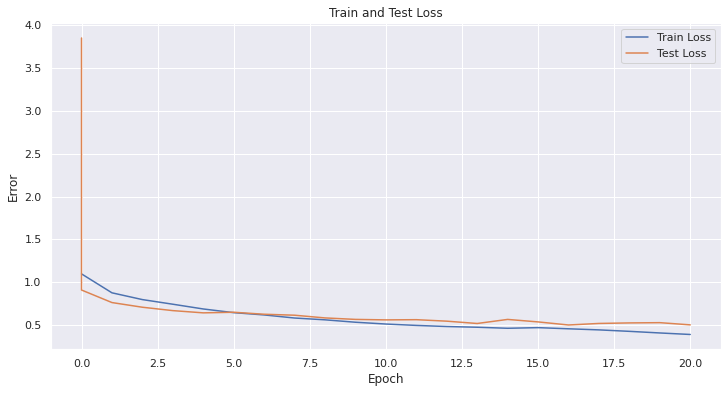

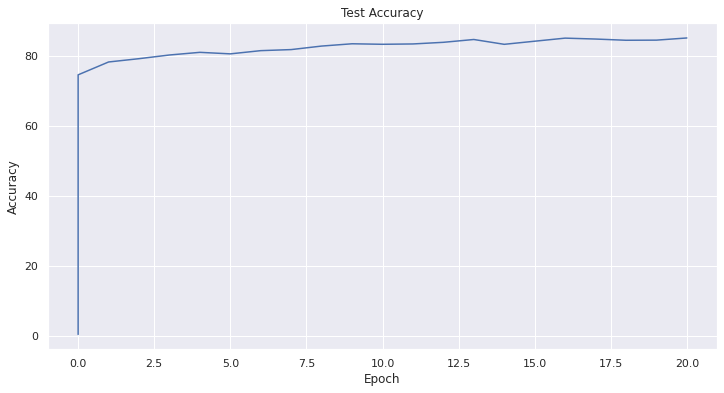

In [11]:
ta_gru_model, ta_en_voc2ind, ta_ind2voc, ta_seq_len, device = main('ta', 'gru')

Using device cpu
num workers: 48
Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['க', 'க', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['க', 'ே', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ஞ', 'ஞ', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['க', 'க', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம', 'ம']



Test set: Avera

  1%|▏         | 1/75 [00:00<00:17,  4.28it/s]

Train Epoch: 0 [0/38723 (0%)]	Loss: 3.889306


 15%|█▍        | 11/75 [00:02<00:13,  4.61it/s]

Train Epoch: 0 [5120/38723 (13%)]	Loss: 1.060485


 28%|██▊       | 21/75 [00:04<00:11,  4.66it/s]

Train Epoch: 0 [10240/38723 (27%)]	Loss: 1.060327


 41%|████▏     | 31/75 [00:06<00:09,  4.41it/s]

Train Epoch: 0 [15360/38723 (40%)]	Loss: 0.996180


 55%|█████▍    | 41/75 [00:09<00:07,  4.30it/s]

Train Epoch: 0 [20480/38723 (53%)]	Loss: 1.076710


 68%|██████▊   | 51/75 [00:11<00:05,  4.56it/s]

Train Epoch: 0 [25600/38723 (67%)]	Loss: 1.014074


 81%|████████▏ | 61/75 [00:13<00:03,  4.63it/s]

Train Epoch: 0 [30720/38723 (80%)]	Loss: 0.989076


 96%|█████████▌| 72/75 [00:15<00:00,  4.66it/s]

Train Epoch: 0 [35840/38723 (93%)]	Loss: 1.000619


100%|██████████| 75/75 [00:16<00:00,  4.54it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ம', 'ா', '்', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ம', 'ி', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['ம', '்', '்', '்', '்', '்', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['ம', '்', '்', 'க', '்', '்', '்']



Test set: Average loss: 0.9512, Accuracy: 176861/239760 (74%)



  1%|▏         | 1/75 [00:00<00:15,  4.72it/s]

Train Epoch: 1 [0/38723 (0%)]	Loss: 1.009738


 15%|█▍        | 11/75 [00:02<00:13,  4.69it/s]

Train Epoch: 1 [5120/38723 (13%)]	Loss: 0.937108


 28%|██▊       | 21/75 [00:04<00:11,  4.72it/s]

Train Epoch: 1 [10240/38723 (27%)]	Loss: 0.966087


 41%|████▏     | 31/75 [00:06<00:09,  4.84it/s]

Train Epoch: 1 [15360/38723 (40%)]	Loss: 0.946149


 55%|█████▍    | 41/75 [00:08<00:07,  4.56it/s]

Train Epoch: 1 [20480/38723 (53%)]	Loss: 0.952760


 68%|██████▊   | 51/75 [00:10<00:05,  4.75it/s]

Train Epoch: 1 [25600/38723 (67%)]	Loss: 0.893448


 81%|████████▏ | 61/75 [00:12<00:02,  4.72it/s]

Train Epoch: 1 [30720/38723 (80%)]	Loss: 0.843210


 95%|█████████▍| 71/75 [00:15<00:00,  4.65it/s]

Train Epoch: 1 [35840/38723 (93%)]	Loss: 0.927005


100%|██████████| 75/75 [00:16<00:00,  4.67it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['க', 'ா', '்', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['க', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['ப', 'க', 'க', '்', 'க', '்', 'க', '்', 'த', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['ப', 'க', 'க', 'க', 'க', '்', '்']



Test set: Average loss: 0.8964, Accuracy: 177975/239760 (74%)



  1%|▏         | 1/75 [00:00<00:15,  4.80it/s]

Train Epoch: 2 [0/38723 (0%)]	Loss: 0.892933


 15%|█▍        | 11/75 [00:02<00:15,  4.09it/s]

Train Epoch: 2 [5120/38723 (13%)]	Loss: 0.803608


 28%|██▊       | 21/75 [00:04<00:11,  4.67it/s]

Train Epoch: 2 [10240/38723 (27%)]	Loss: 0.931516


 41%|████▏     | 31/75 [00:06<00:09,  4.78it/s]

Train Epoch: 2 [15360/38723 (40%)]	Loss: 0.918381


 55%|█████▍    | 41/75 [00:08<00:07,  4.58it/s]

Train Epoch: 2 [20480/38723 (53%)]	Loss: 0.884708


 69%|██████▉   | 52/75 [00:11<00:04,  4.81it/s]

Train Epoch: 2 [25600/38723 (67%)]	Loss: 0.786681


 81%|████████▏ | 61/75 [00:13<00:03,  4.52it/s]

Train Epoch: 2 [30720/38723 (80%)]	Loss: 0.772315


 95%|█████████▍| 71/75 [00:15<00:00,  4.67it/s]

Train Epoch: 2 [35840/38723 (93%)]	Loss: 0.843347


100%|██████████| 75/75 [00:16<00:00,  4.64it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['க', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['ப', 'க', 'க', 'ு', 'க', '்', 'க', '்', 'ட', 'க']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['ப', 'ா', 'ா', 'க', 'க', '்', 'க']



Test set: Average loss: 0.8745, Accuracy: 178564/239760 (74%)



  1%|▏         | 1/75 [00:00<00:16,  4.56it/s]

Train Epoch: 3 [0/38723 (0%)]	Loss: 0.817582


 15%|█▍        | 11/75 [00:02<00:13,  4.68it/s]

Train Epoch: 3 [5120/38723 (13%)]	Loss: 0.731918


 28%|██▊       | 21/75 [00:04<00:11,  4.69it/s]

Train Epoch: 3 [10240/38723 (27%)]	Loss: 0.888901


 41%|████▏     | 31/75 [00:06<00:09,  4.85it/s]

Train Epoch: 3 [15360/38723 (40%)]	Loss: 0.841388


 55%|█████▍    | 41/75 [00:08<00:07,  4.81it/s]

Train Epoch: 3 [20480/38723 (53%)]	Loss: 0.853771


 68%|██████▊   | 51/75 [00:10<00:05,  4.80it/s]

Train Epoch: 3 [25600/38723 (67%)]	Loss: 0.754178


 81%|████████▏ | 61/75 [00:12<00:02,  4.75it/s]

Train Epoch: 3 [30720/38723 (80%)]	Loss: 0.753526


 95%|█████████▍| 71/75 [00:15<00:00,  4.78it/s]

Train Epoch: 3 [35840/38723 (93%)]	Loss: 0.801282


100%|██████████| 75/75 [00:15<00:00,  4.73it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['க', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', 'க', 'ர', 'க', '்', 'க', '்', 'ட', 'த']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['ப', 'ா', 'க', 'க', 'க', '்', '்']



Test set: Average loss: 0.8725, Accuracy: 180101/239760 (75%)



  1%|▏         | 1/75 [00:00<00:14,  5.02it/s]

Train Epoch: 4 [0/38723 (0%)]	Loss: 0.769433


 15%|█▍        | 11/75 [00:02<00:15,  4.20it/s]

Train Epoch: 4 [5120/38723 (13%)]	Loss: 0.668937


 28%|██▊       | 21/75 [00:04<00:12,  4.40it/s]

Train Epoch: 4 [10240/38723 (27%)]	Loss: 0.874053


 41%|████▏     | 31/75 [00:07<00:09,  4.70it/s]

Train Epoch: 4 [15360/38723 (40%)]	Loss: 0.798220


 55%|█████▍    | 41/75 [00:09<00:07,  4.70it/s]

Train Epoch: 4 [20480/38723 (53%)]	Loss: 0.822610


 68%|██████▊   | 51/75 [00:11<00:05,  4.77it/s]

Train Epoch: 4 [25600/38723 (67%)]	Loss: 0.714124


 81%|████████▏ | 61/75 [00:13<00:02,  4.77it/s]

Train Epoch: 4 [30720/38723 (80%)]	Loss: 0.739923


 95%|█████████▍| 71/75 [00:15<00:00,  4.59it/s]

Train Epoch: 4 [35840/38723 (93%)]	Loss: 0.771826


100%|██████████| 75/75 [00:16<00:00,  4.54it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', '்', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'க', 'ர', '்', '்', 'ா', 'த', 'ட', 'ட']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', '்', 'க', '்', 'க']



Test set: Average loss: 0.8577, Accuracy: 182718/239760 (76%)



  1%|▏         | 1/75 [00:00<00:15,  4.69it/s]

Train Epoch: 5 [0/38723 (0%)]	Loss: 0.751211


 15%|█▍        | 11/75 [00:02<00:14,  4.44it/s]

Train Epoch: 5 [5120/38723 (13%)]	Loss: 0.620510


 28%|██▊       | 21/75 [00:04<00:11,  4.58it/s]

Train Epoch: 5 [10240/38723 (27%)]	Loss: 0.845356


 41%|████▏     | 31/75 [00:06<00:09,  4.48it/s]

Train Epoch: 5 [15360/38723 (40%)]	Loss: 0.763140


 55%|█████▍    | 41/75 [00:08<00:06,  4.87it/s]

Train Epoch: 5 [20480/38723 (53%)]	Loss: 0.806716


 68%|██████▊   | 51/75 [00:11<00:05,  4.72it/s]

Train Epoch: 5 [25600/38723 (67%)]	Loss: 0.686557


 81%|████████▏ | 61/75 [00:13<00:03,  4.67it/s]

Train Epoch: 5 [30720/38723 (80%)]	Loss: 0.721382


 95%|█████████▍| 71/75 [00:15<00:00,  4.62it/s]

Train Epoch: 5 [35840/38723 (93%)]	Loss: 0.750793


100%|██████████| 75/75 [00:16<00:00,  4.63it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ெ', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', 'க', 'ர', 'ா', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['ப', 'ா', '்', 'க', '்', '்']



Test set: Average loss: 0.8358, Accuracy: 183844/239760 (77%)



  1%|▏         | 1/75 [00:00<00:16,  4.43it/s]

Train Epoch: 6 [0/38723 (0%)]	Loss: 0.730051


 15%|█▍        | 11/75 [00:02<00:13,  4.58it/s]

Train Epoch: 6 [5120/38723 (13%)]	Loss: 0.605827


 28%|██▊       | 21/75 [00:04<00:12,  4.32it/s]

Train Epoch: 6 [10240/38723 (27%)]	Loss: 0.824566


 41%|████▏     | 31/75 [00:06<00:09,  4.78it/s]

Train Epoch: 6 [15360/38723 (40%)]	Loss: 0.750541


 55%|█████▍    | 41/75 [00:08<00:07,  4.76it/s]

Train Epoch: 6 [20480/38723 (53%)]	Loss: 0.779874


 68%|██████▊   | 51/75 [00:11<00:05,  4.65it/s]

Train Epoch: 6 [25600/38723 (67%)]	Loss: 0.663285


 81%|████████▏ | 61/75 [00:13<00:03,  4.54it/s]

Train Epoch: 6 [30720/38723 (80%)]	Loss: 0.708254


 95%|█████████▍| 71/75 [00:15<00:00,  4.61it/s]

Train Epoch: 6 [35840/38723 (93%)]	Loss: 0.733072


100%|██████████| 75/75 [00:16<00:00,  4.57it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['க', 'ெ', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ா', 'க', 'ர', 'ா', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['எ', 'ா', 'ர', 'க', '்', 'க']



Test set: Average loss: 0.8192, Accuracy: 183740/239760 (77%)



  1%|▏         | 1/75 [00:00<00:16,  4.54it/s]

Train Epoch: 7 [0/38723 (0%)]	Loss: 0.717007


 15%|█▍        | 11/75 [00:02<00:14,  4.43it/s]

Train Epoch: 7 [5120/38723 (13%)]	Loss: 0.569390


 28%|██▊       | 21/75 [00:04<00:12,  4.38it/s]

Train Epoch: 7 [10240/38723 (27%)]	Loss: 0.812378


 41%|████▏     | 31/75 [00:06<00:09,  4.65it/s]

Train Epoch: 7 [15360/38723 (40%)]	Loss: 0.737027


 55%|█████▍    | 41/75 [00:08<00:07,  4.72it/s]

Train Epoch: 7 [20480/38723 (53%)]	Loss: 0.767530


 68%|██████▊   | 51/75 [00:11<00:05,  4.55it/s]

Train Epoch: 7 [25600/38723 (67%)]	Loss: 0.657078


 81%|████████▏ | 61/75 [00:13<00:02,  4.75it/s]

Train Epoch: 7 [30720/38723 (80%)]	Loss: 0.691332


 95%|█████████▍| 71/75 [00:15<00:00,  4.70it/s]

Train Epoch: 7 [35840/38723 (93%)]	Loss: 0.724106


100%|██████████| 75/75 [00:16<00:00,  4.60it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ே', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', 'க', 'ர', 'க', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['ஜ', 'ா', '்', 'க', 'ை', '்', '்']



Test set: Average loss: 0.8445, Accuracy: 182609/239760 (76%)



  1%|▏         | 1/75 [00:00<00:15,  4.74it/s]

Train Epoch: 8 [0/38723 (0%)]	Loss: 0.700632


 15%|█▍        | 11/75 [00:02<00:13,  4.59it/s]

Train Epoch: 8 [5120/38723 (13%)]	Loss: 0.559210


 29%|██▉       | 22/75 [00:04<00:11,  4.61it/s]

Train Epoch: 8 [10240/38723 (27%)]	Loss: 0.806575


 41%|████▏     | 31/75 [00:06<00:09,  4.68it/s]

Train Epoch: 8 [15360/38723 (40%)]	Loss: 0.732171


 55%|█████▍    | 41/75 [00:08<00:07,  4.58it/s]

Train Epoch: 8 [20480/38723 (53%)]	Loss: 0.747471


 68%|██████▊   | 51/75 [00:11<00:05,  4.42it/s]

Train Epoch: 8 [25600/38723 (67%)]	Loss: 0.652132


 81%|████████▏ | 61/75 [00:13<00:02,  4.76it/s]

Train Epoch: 8 [30720/38723 (80%)]	Loss: 0.676291


 95%|█████████▍| 71/75 [00:15<00:00,  4.70it/s]

Train Epoch: 8 [35840/38723 (93%)]	Loss: 0.698962


100%|██████████| 75/75 [00:16<00:00,  4.66it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ே', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', 'க', 'ர', 'ா', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['வ', 'ா', '்', 'க', '்', '்', '்']



Test set: Average loss: 0.8318, Accuracy: 183174/239760 (76%)



  1%|▏         | 1/75 [00:00<00:16,  4.48it/s]

Train Epoch: 9 [0/38723 (0%)]	Loss: 0.665411


 15%|█▍        | 11/75 [00:02<00:13,  4.61it/s]

Train Epoch: 9 [5120/38723 (13%)]	Loss: 0.569395


 28%|██▊       | 21/75 [00:04<00:12,  4.47it/s]

Train Epoch: 9 [10240/38723 (27%)]	Loss: 0.802934


 41%|████▏     | 31/75 [00:06<00:09,  4.75it/s]

Train Epoch: 9 [15360/38723 (40%)]	Loss: 0.723273


 55%|█████▍    | 41/75 [00:08<00:07,  4.65it/s]

Train Epoch: 9 [20480/38723 (53%)]	Loss: 0.730470


 68%|██████▊   | 51/75 [00:11<00:05,  4.68it/s]

Train Epoch: 9 [25600/38723 (67%)]	Loss: 0.631010


 81%|████████▏ | 61/75 [00:13<00:02,  4.80it/s]

Train Epoch: 9 [30720/38723 (80%)]	Loss: 0.661136


 95%|█████████▍| 71/75 [00:15<00:00,  4.75it/s]

Train Epoch: 9 [35840/38723 (93%)]	Loss: 0.686381


100%|██████████| 75/75 [00:16<00:00,  4.65it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ே', 'ற', '்', 'ற']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', 'க', 'ு', 'ை', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['அ', 'ன', '்', 'க', 'ள', '்', '்']



Test set: Average loss: 0.8797, Accuracy: 181391/239760 (76%)



  1%|▏         | 1/75 [00:00<00:15,  4.72it/s]

Train Epoch: 10 [0/38723 (0%)]	Loss: 0.602135


 15%|█▍        | 11/75 [00:02<00:13,  4.65it/s]

Train Epoch: 10 [5120/38723 (13%)]	Loss: 0.493111


 28%|██▊       | 21/75 [00:04<00:11,  4.55it/s]

Train Epoch: 10 [10240/38723 (27%)]	Loss: 0.778552


 41%|████▏     | 31/75 [00:06<00:09,  4.82it/s]

Train Epoch: 10 [15360/38723 (40%)]	Loss: 0.702084


 55%|█████▍    | 41/75 [00:08<00:06,  4.86it/s]

Train Epoch: 10 [20480/38723 (53%)]	Loss: 0.728625


 68%|██████▊   | 51/75 [00:11<00:05,  4.48it/s]

Train Epoch: 10 [25600/38723 (67%)]	Loss: 0.614586


 81%|████████▏ | 61/75 [00:13<00:02,  4.83it/s]

Train Epoch: 10 [30720/38723 (80%)]	Loss: 0.649897


 95%|█████████▍| 71/75 [00:15<00:00,  4.85it/s]

Train Epoch: 10 [35840/38723 (93%)]	Loss: 0.664278


100%|██████████| 75/75 [00:16<00:00,  4.68it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['த', 'ே', 'த', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', '்', 'ற', 'த', '்', '்', 'த', 'ட']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['எ', 'க', '்', 'க', '்', 'த', '்']



Test set: Average loss: 0.8027, Accuracy: 185850/239760 (78%)



  1%|▏         | 1/75 [00:00<00:15,  4.83it/s]

Train Epoch: 11 [0/38723 (0%)]	Loss: 0.609306


 15%|█▍        | 11/75 [00:02<00:13,  4.64it/s]

Train Epoch: 11 [5120/38723 (13%)]	Loss: 0.484019


 28%|██▊       | 21/75 [00:04<00:11,  4.81it/s]

Train Epoch: 11 [10240/38723 (27%)]	Loss: 0.764120


 41%|████▏     | 31/75 [00:06<00:09,  4.67it/s]

Train Epoch: 11 [15360/38723 (40%)]	Loss: 0.695204


 55%|█████▍    | 41/75 [00:08<00:07,  4.72it/s]

Train Epoch: 11 [20480/38723 (53%)]	Loss: 0.734825


 68%|██████▊   | 51/75 [00:10<00:05,  4.60it/s]

Train Epoch: 11 [25600/38723 (67%)]	Loss: 0.617682


 81%|████████▏ | 61/75 [00:13<00:03,  4.45it/s]

Train Epoch: 11 [30720/38723 (80%)]	Loss: 0.659069


 95%|█████████▍| 71/75 [00:15<00:00,  4.61it/s]

Train Epoch: 11 [35840/38723 (93%)]	Loss: 0.650371


100%|██████████| 75/75 [00:16<00:00,  4.66it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['த', 'ே', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'ட', 'த', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['எ', 'ட', '்', 'க', 'த', 'த']



Test set: Average loss: 0.7487, Accuracy: 188476/239760 (79%)



  1%|▏         | 1/75 [00:00<00:16,  4.58it/s]

Train Epoch: 12 [0/38723 (0%)]	Loss: 0.607960


 15%|█▍        | 11/75 [00:02<00:13,  4.75it/s]

Train Epoch: 12 [5120/38723 (13%)]	Loss: 0.485238


 28%|██▊       | 21/75 [00:04<00:11,  4.77it/s]

Train Epoch: 12 [10240/38723 (27%)]	Loss: 0.773056


 43%|████▎     | 32/75 [00:06<00:08,  4.88it/s]

Train Epoch: 12 [15360/38723 (40%)]	Loss: 0.671617


 55%|█████▍    | 41/75 [00:08<00:07,  4.74it/s]

Train Epoch: 12 [20480/38723 (53%)]	Loss: 0.714544


 68%|██████▊   | 51/75 [00:10<00:05,  4.74it/s]

Train Epoch: 12 [25600/38723 (67%)]	Loss: 0.609542


 83%|████████▎ | 62/75 [00:12<00:02,  4.91it/s]

Train Epoch: 12 [30720/38723 (80%)]	Loss: 0.631559


 95%|█████████▍| 71/75 [00:14<00:00,  4.69it/s]

Train Epoch: 12 [35840/38723 (93%)]	Loss: 0.630150


100%|██████████| 75/75 [00:15<00:00,  4.75it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ு', 'ம', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ப', 'ே', 'த', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', '்', '்', '்', 'த']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['எ', 'ட', '்', 'த', 'த', '்']



Test set: Average loss: 0.7665, Accuracy: 188053/239760 (78%)



  1%|▏         | 1/75 [00:00<00:15,  4.80it/s]

Train Epoch: 13 [0/38723 (0%)]	Loss: 0.583113


 15%|█▍        | 11/75 [00:02<00:13,  4.84it/s]

Train Epoch: 13 [5120/38723 (13%)]	Loss: 0.495159


 28%|██▊       | 21/75 [00:04<00:11,  4.66it/s]

Train Epoch: 13 [10240/38723 (27%)]	Loss: 0.770030


 41%|████▏     | 31/75 [00:06<00:09,  4.69it/s]

Train Epoch: 13 [15360/38723 (40%)]	Loss: 0.664737


 55%|█████▍    | 41/75 [00:08<00:07,  4.42it/s]

Train Epoch: 13 [20480/38723 (53%)]	Loss: 0.708706


 68%|██████▊   | 51/75 [00:10<00:05,  4.78it/s]

Train Epoch: 13 [25600/38723 (67%)]	Loss: 0.603969


 81%|████████▏ | 61/75 [00:13<00:02,  4.68it/s]

Train Epoch: 13 [30720/38723 (80%)]	Loss: 0.621789


 95%|█████████▍| 71/75 [00:15<00:00,  4.55it/s]

Train Epoch: 13 [35840/38723 (93%)]	Loss: 0.627007


100%|██████████| 75/75 [00:16<00:00,  4.61it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', '்', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ட', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['த', 'ா', '்', 'த']



Test set: Average loss: 0.7610, Accuracy: 189161/239760 (79%)



  1%|▏         | 1/75 [00:00<00:16,  4.42it/s]

Train Epoch: 14 [0/38723 (0%)]	Loss: 0.538096


 15%|█▍        | 11/75 [00:02<00:14,  4.45it/s]

Train Epoch: 14 [5120/38723 (13%)]	Loss: 0.463793


 28%|██▊       | 21/75 [00:04<00:13,  4.08it/s]

Train Epoch: 14 [10240/38723 (27%)]	Loss: 0.743533


 41%|████▏     | 31/75 [00:07<00:09,  4.45it/s]

Train Epoch: 14 [15360/38723 (40%)]	Loss: 0.660965


 55%|█████▍    | 41/75 [00:09<00:07,  4.56it/s]

Train Epoch: 14 [20480/38723 (53%)]	Loss: 0.695569


 68%|██████▊   | 51/75 [00:11<00:05,  4.50it/s]

Train Epoch: 14 [25600/38723 (67%)]	Loss: 0.615357


 81%|████████▏ | 61/75 [00:13<00:03,  4.63it/s]

Train Epoch: 14 [30720/38723 (80%)]	Loss: 0.613410


 95%|█████████▍| 71/75 [00:15<00:00,  4.68it/s]

Train Epoch: 14 [35840/38723 (93%)]	Loss: 0.619463


100%|██████████| 75/75 [00:16<00:00,  4.53it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', '்', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ட', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', '்', '்', '்', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['த', 'ா', '்', 'த', '்', 'த']



Test set: Average loss: 0.7519, Accuracy: 189493/239760 (79%)



  1%|▏         | 1/75 [00:00<00:16,  4.48it/s]

Train Epoch: 15 [0/38723 (0%)]	Loss: 0.500716


 15%|█▍        | 11/75 [00:02<00:13,  4.65it/s]

Train Epoch: 15 [5120/38723 (13%)]	Loss: 0.446099


 28%|██▊       | 21/75 [00:04<00:11,  4.73it/s]

Train Epoch: 15 [10240/38723 (27%)]	Loss: 0.730105


 41%|████▏     | 31/75 [00:06<00:09,  4.68it/s]

Train Epoch: 15 [15360/38723 (40%)]	Loss: 0.656276


 55%|█████▍    | 41/75 [00:08<00:07,  4.69it/s]

Train Epoch: 15 [20480/38723 (53%)]	Loss: 0.685073


 68%|██████▊   | 51/75 [00:10<00:05,  4.72it/s]

Train Epoch: 15 [25600/38723 (67%)]	Loss: 0.593407


 81%|████████▏ | 61/75 [00:13<00:02,  4.73it/s]

Train Epoch: 15 [30720/38723 (80%)]	Loss: 0.615705


 95%|█████████▍| 71/75 [00:15<00:00,  4.66it/s]

Train Epoch: 15 [35840/38723 (93%)]	Loss: 0.608596


100%|██████████| 75/75 [00:15<00:00,  4.70it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', '்', '்']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ப', 'ட', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', 'த', '்', 'ா', '்']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['த', 'த', 'த', 'த', 'த', 'த']



Test set: Average loss: 0.7831, Accuracy: 188063/239760 (78%)



  1%|▏         | 1/75 [00:00<00:15,  4.81it/s]

Train Epoch: 16 [0/38723 (0%)]	Loss: 0.487850


 15%|█▍        | 11/75 [00:02<00:13,  4.60it/s]

Train Epoch: 16 [5120/38723 (13%)]	Loss: 0.435041


 28%|██▊       | 21/75 [00:04<00:11,  4.82it/s]

Train Epoch: 16 [10240/38723 (27%)]	Loss: 0.719865


 41%|████▏     | 31/75 [00:06<00:09,  4.75it/s]

Train Epoch: 16 [15360/38723 (40%)]	Loss: 0.642438


 55%|█████▍    | 41/75 [00:08<00:07,  4.60it/s]

Train Epoch: 16 [20480/38723 (53%)]	Loss: 0.675788


 68%|██████▊   | 51/75 [00:10<00:05,  4.63it/s]

Train Epoch: 16 [25600/38723 (67%)]	Loss: 0.585093


 81%|████████▏ | 61/75 [00:13<00:02,  4.84it/s]

Train Epoch: 16 [30720/38723 (80%)]	Loss: 0.597389


 95%|█████████▍| 71/75 [00:15<00:00,  4.60it/s]

Train Epoch: 16 [35840/38723 (93%)]	Loss: 0.592033


100%|██████████| 75/75 [00:16<00:00,  4.65it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', '்', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'க', 'த', 'ா']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['த', 'த', 'த', 'த', 'த', 'த']



Test set: Average loss: 0.7204, Accuracy: 191466/239760 (80%)



  1%|▏         | 1/75 [00:00<00:15,  4.92it/s]

Train Epoch: 17 [0/38723 (0%)]	Loss: 0.464738


 15%|█▍        | 11/75 [00:02<00:13,  4.62it/s]

Train Epoch: 17 [5120/38723 (13%)]	Loss: 0.423259


 28%|██▊       | 21/75 [00:04<00:11,  4.53it/s]

Train Epoch: 17 [10240/38723 (27%)]	Loss: 0.697186


 41%|████▏     | 31/75 [00:06<00:09,  4.81it/s]

Train Epoch: 17 [15360/38723 (40%)]	Loss: 0.638549


 55%|█████▍    | 41/75 [00:08<00:07,  4.38it/s]

Train Epoch: 17 [20480/38723 (53%)]	Loss: 0.669668


 68%|██████▊   | 51/75 [00:11<00:05,  4.73it/s]

Train Epoch: 17 [25600/38723 (67%)]	Loss: 0.560836


 81%|████████▏ | 61/75 [00:13<00:03,  4.61it/s]

Train Epoch: 17 [30720/38723 (80%)]	Loss: 0.588656


 95%|█████████▍| 71/75 [00:15<00:00,  4.83it/s]

Train Epoch: 17 [35840/38723 (93%)]	Loss: 0.575260


100%|██████████| 75/75 [00:16<00:00,  4.64it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', '்', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ட', 'ட', '்', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'த', 'த', 'ா', 'த', 'த']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['த', 'த', 'த', 'த', 'த', 'த']



Test set: Average loss: 0.7052, Accuracy: 191959/239760 (80%)



  1%|▏         | 1/75 [00:00<00:15,  4.92it/s]

Train Epoch: 18 [0/38723 (0%)]	Loss: 0.457286


 15%|█▍        | 11/75 [00:02<00:14,  4.40it/s]

Train Epoch: 18 [5120/38723 (13%)]	Loss: 0.423016


 28%|██▊       | 21/75 [00:04<00:11,  4.74it/s]

Train Epoch: 18 [10240/38723 (27%)]	Loss: 0.693918


 41%|████▏     | 31/75 [00:06<00:09,  4.73it/s]

Train Epoch: 18 [15360/38723 (40%)]	Loss: 0.643274


 55%|█████▍    | 41/75 [00:08<00:07,  4.75it/s]

Train Epoch: 18 [20480/38723 (53%)]	Loss: 0.661026


 68%|██████▊   | 51/75 [00:11<00:05,  4.64it/s]

Train Epoch: 18 [25600/38723 (67%)]	Loss: 0.551981


 81%|████████▏ | 61/75 [00:13<00:03,  4.53it/s]

Train Epoch: 18 [30720/38723 (80%)]	Loss: 0.592409


 95%|█████████▍| 71/75 [00:15<00:00,  4.21it/s]

Train Epoch: 18 [35840/38723 (93%)]	Loss: 0.578554


100%|██████████| 75/75 [00:16<00:00,  4.58it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ட', 'ட', '்', 'ி', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'த', 'த', 'ா', 'த', 'த']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['த', 'ா', 'த', 'த', 'த', 'த']



Test set: Average loss: 0.7152, Accuracy: 191274/239760 (80%)



  1%|▏         | 1/75 [00:00<00:16,  4.60it/s]

Train Epoch: 19 [0/38723 (0%)]	Loss: 0.448009


 15%|█▍        | 11/75 [00:02<00:14,  4.54it/s]

Train Epoch: 19 [5120/38723 (13%)]	Loss: 0.410810


 28%|██▊       | 21/75 [00:04<00:11,  4.66it/s]

Train Epoch: 19 [10240/38723 (27%)]	Loss: 0.673461


 41%|████▏     | 31/75 [00:06<00:09,  4.50it/s]

Train Epoch: 19 [15360/38723 (40%)]	Loss: 0.632290


 56%|█████▌    | 42/75 [00:09<00:06,  4.80it/s]

Train Epoch: 19 [20480/38723 (53%)]	Loss: 0.661552


 68%|██████▊   | 51/75 [00:11<00:05,  4.36it/s]

Train Epoch: 19 [25600/38723 (67%)]	Loss: 0.540814


 81%|████████▏ | 61/75 [00:13<00:03,  4.48it/s]

Train Epoch: 19 [30720/38723 (80%)]	Loss: 0.573501


 95%|█████████▍| 71/75 [00:15<00:00,  4.58it/s]

Train Epoch: 19 [35840/38723 (93%)]	Loss: 0.567377


100%|██████████| 75/75 [00:16<00:00,  4.54it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', '்', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ட', '்', '்', 'ி', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'த', 'த', 'ா', 'ா', 'த']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['த', 'த', 'த', 'த', 'த', 'த']



Test set: Average loss: 0.7489, Accuracy: 189718/239760 (79%)



  1%|▏         | 1/75 [00:00<00:15,  4.83it/s]

Train Epoch: 20 [0/38723 (0%)]	Loss: 0.448345


 15%|█▍        | 11/75 [00:02<00:13,  4.72it/s]

Train Epoch: 20 [5120/38723 (13%)]	Loss: 0.410652


 28%|██▊       | 21/75 [00:04<00:11,  4.56it/s]

Train Epoch: 20 [10240/38723 (27%)]	Loss: 0.683466


 41%|████▏     | 31/75 [00:06<00:09,  4.56it/s]

Train Epoch: 20 [15360/38723 (40%)]	Loss: 0.602087


 55%|█████▍    | 41/75 [00:08<00:07,  4.57it/s]

Train Epoch: 20 [20480/38723 (53%)]	Loss: 0.649096


 68%|██████▊   | 51/75 [00:11<00:05,  4.56it/s]

Train Epoch: 20 [25600/38723 (67%)]	Loss: 0.531668


 81%|████████▏ | 61/75 [00:13<00:03,  4.39it/s]

Train Epoch: 20 [30720/38723 (80%)]	Loss: 0.584351


 95%|█████████▍| 71/75 [00:15<00:00,  4.79it/s]

Train Epoch: 20 [35840/38723 (93%)]	Loss: 0.547724


100%|██████████| 75/75 [00:16<00:00,  4.61it/s]


Input	['f', 'a', 'r', 'm']
GT	['ஃ', 'ப', 'ா', 'ர', '்', 'ம', '்']
pred	['ப', 'ா', 'ர', 'ம', 'ம']


Input	['n', 'e', 't', 'r', 'i']
GT	['ந', 'ெ', 'ற', '்', 'ற', 'ி']
pred	['ந', 'ட', '்', 'ற', 'ி']


Input	['k', 'a', 'a', 'r', 'a', 'n', 'a', 't', 't', 'a', 'i', 'p']
GT	['க', 'ா', 'ர', 'ண', 'த', '்', 'த', 'ை', 'ப', '்']
pred	['க', 'த', 'த', 'ா', '்', 'த']


Input	['v', 'a', 'a', 'g', 'a', 'n', 'a']
GT	['வ', 'ா', 'க', 'ன']
pred	['த', 'த', 'த', 'த', '்', 'த']



Test set: Average loss: 0.6893, Accuracy: 193035/239760 (81%)



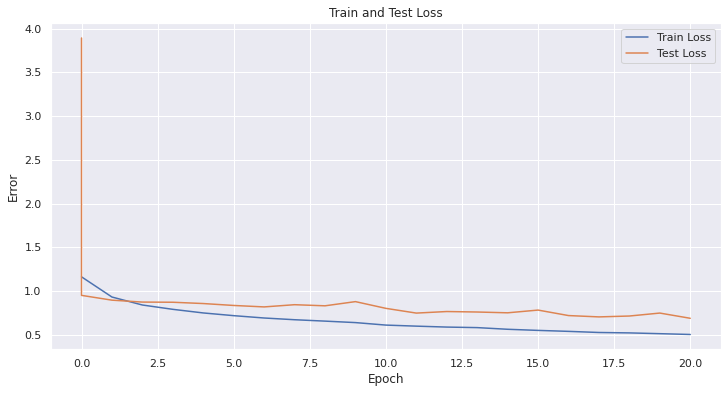

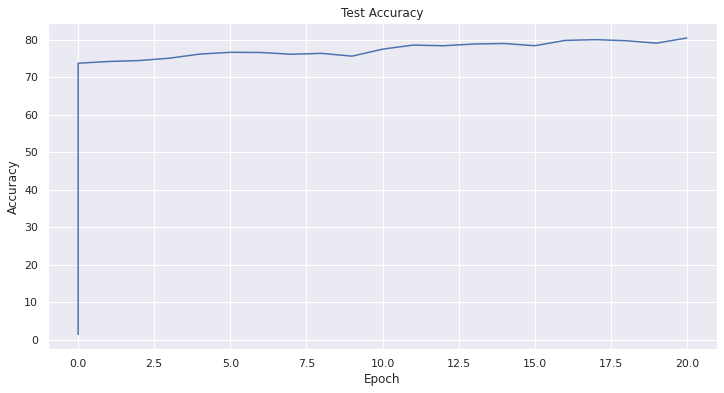

In [12]:
ta_lstm_model, _, _, _, _ = main('ta', 'lstm')

Using device cpu
num workers: 48
Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ', 'ফ']



Test set: Average loss: 4.0593, Accuracy: 555/195976 (0%)



  2%|▏         | 2/89 [00:00<00:11,  7.28it/s]

Train Epoch: 0 [0/45976 (0%)]	Loss: 4.063099


 13%|█▎        | 12/89 [00:01<00:11,  6.81it/s]

Train Epoch: 0 [5120/45976 (11%)]	Loss: 1.438438


 25%|██▍       | 22/89 [00:03<00:09,  6.82it/s]

Train Epoch: 0 [10240/45976 (22%)]	Loss: 1.121956


 36%|███▌      | 32/89 [00:04<00:08,  6.88it/s]

Train Epoch: 0 [15360/45976 (34%)]	Loss: 1.249907


 47%|████▋     | 42/89 [00:06<00:06,  6.83it/s]

Train Epoch: 0 [20480/45976 (45%)]	Loss: 1.221364


 58%|█████▊    | 52/89 [00:07<00:05,  6.92it/s]

Train Epoch: 0 [25600/45976 (56%)]	Loss: 1.168249


 70%|██████▉   | 62/89 [00:09<00:03,  7.04it/s]

Train Epoch: 0 [30720/45976 (67%)]	Loss: 1.250794


 81%|████████  | 72/89 [00:10<00:02,  7.26it/s]

Train Epoch: 0 [35840/45976 (79%)]	Loss: 1.024984


 92%|█████████▏| 82/89 [00:11<00:00,  7.11it/s]

Train Epoch: 0 [40960/45976 (90%)]	Loss: 1.298290


100%|██████████| 89/89 [00:12<00:00,  6.95it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['া', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['স', 'ো', 'ু', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['স', 'স', '্', 'া', 'ন', 'ি', '্', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', '্', 'া', 'া', 'ব']



Test set: Average loss: 1.0973, Accuracy: 139518/195976 (71%)



  2%|▏         | 2/89 [00:00<00:12,  7.08it/s]

Train Epoch: 1 [0/45976 (0%)]	Loss: 1.401837


 13%|█▎        | 12/89 [00:01<00:10,  7.14it/s]

Train Epoch: 1 [5120/45976 (11%)]	Loss: 1.099872


 25%|██▍       | 22/89 [00:03<00:09,  7.24it/s]

Train Epoch: 1 [10240/45976 (22%)]	Loss: 0.888584


 36%|███▌      | 32/89 [00:04<00:07,  7.26it/s]

Train Epoch: 1 [15360/45976 (34%)]	Loss: 0.946292


 47%|████▋     | 42/89 [00:05<00:06,  7.25it/s]

Train Epoch: 1 [20480/45976 (45%)]	Loss: 0.856341


 58%|█████▊    | 52/89 [00:07<00:05,  7.32it/s]

Train Epoch: 1 [25600/45976 (56%)]	Loss: 1.037044


 70%|██████▉   | 62/89 [00:08<00:03,  7.19it/s]

Train Epoch: 1 [30720/45976 (67%)]	Loss: 1.120591


 81%|████████  | 72/89 [00:10<00:02,  7.23it/s]

Train Epoch: 1 [35840/45976 (79%)]	Loss: 0.939240


 92%|█████████▏| 82/89 [00:11<00:01,  6.92it/s]

Train Epoch: 1 [40960/45976 (90%)]	Loss: 1.151822


100%|██████████| 89/89 [00:12<00:00,  7.07it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['া', '্', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['ে', 'স', '্', 'া', '্', 'ি', 'য', 'য', 'য']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'দ', 'া', 'া', 'া', '্', 'র']



Test set: Average loss: 0.9810, Accuracy: 142576/195976 (73%)



  2%|▏         | 2/89 [00:00<00:13,  6.63it/s]

Train Epoch: 2 [0/45976 (0%)]	Loss: 1.193768


 13%|█▎        | 12/89 [00:01<00:10,  7.09it/s]

Train Epoch: 2 [5120/45976 (11%)]	Loss: 0.927360


 25%|██▍       | 22/89 [00:03<00:09,  7.02it/s]

Train Epoch: 2 [10240/45976 (22%)]	Loss: 0.808614


 36%|███▌      | 32/89 [00:04<00:07,  7.26it/s]

Train Epoch: 2 [15360/45976 (34%)]	Loss: 0.838722


 47%|████▋     | 42/89 [00:05<00:06,  7.21it/s]

Train Epoch: 2 [20480/45976 (45%)]	Loss: 0.775289


 58%|█████▊    | 52/89 [00:07<00:04,  7.40it/s]

Train Epoch: 2 [25600/45976 (56%)]	Loss: 0.952329


 70%|██████▉   | 62/89 [00:08<00:03,  7.14it/s]

Train Epoch: 2 [30720/45976 (67%)]	Loss: 1.067651


 81%|████████  | 72/89 [00:10<00:02,  7.20it/s]

Train Epoch: 2 [35840/45976 (79%)]	Loss: 0.810384


 92%|█████████▏| 82/89 [00:11<00:00,  7.00it/s]

Train Epoch: 2 [40960/45976 (90%)]	Loss: 1.122073


100%|██████████| 89/89 [00:12<00:00,  7.14it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', '্', 'ি', '়', '়', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'দ', 'া', 'া', 'া']



Test set: Average loss: 0.8930, Accuracy: 145968/195976 (74%)



  2%|▏         | 2/89 [00:00<00:12,  7.03it/s]

Train Epoch: 3 [0/45976 (0%)]	Loss: 1.080042


 13%|█▎        | 12/89 [00:01<00:10,  7.03it/s]

Train Epoch: 3 [5120/45976 (11%)]	Loss: 0.872460


 25%|██▍       | 22/89 [00:03<00:09,  7.09it/s]

Train Epoch: 3 [10240/45976 (22%)]	Loss: 0.783545


 36%|███▌      | 32/89 [00:04<00:08,  7.02it/s]

Train Epoch: 3 [15360/45976 (34%)]	Loss: 0.775705


 47%|████▋     | 42/89 [00:05<00:06,  7.07it/s]

Train Epoch: 3 [20480/45976 (45%)]	Loss: 0.721516


 58%|█████▊    | 52/89 [00:07<00:05,  6.73it/s]

Train Epoch: 3 [25600/45976 (56%)]	Loss: 0.894652


 70%|██████▉   | 62/89 [00:08<00:03,  7.22it/s]

Train Epoch: 3 [30720/45976 (67%)]	Loss: 1.017313


 81%|████████  | 72/89 [00:10<00:02,  7.28it/s]

Train Epoch: 3 [35840/45976 (79%)]	Loss: 0.789457


 92%|█████████▏| 82/89 [00:11<00:01,  6.88it/s]

Train Epoch: 3 [40960/45976 (90%)]	Loss: 1.080639


100%|██████████| 89/89 [00:12<00:00,  7.11it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ৈ', '্', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', '্', 'ি', '়', '়', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'দ', 'া', 'র']



Test set: Average loss: 0.8228, Accuracy: 149023/195976 (76%)



  2%|▏         | 2/89 [00:00<00:11,  7.66it/s]

Train Epoch: 4 [0/45976 (0%)]	Loss: 0.981529


 13%|█▎        | 12/89 [00:01<00:10,  7.14it/s]

Train Epoch: 4 [5120/45976 (11%)]	Loss: 0.801737


 25%|██▍       | 22/89 [00:03<00:09,  7.26it/s]

Train Epoch: 4 [10240/45976 (22%)]	Loss: 0.740958


 36%|███▌      | 32/89 [00:04<00:07,  7.13it/s]

Train Epoch: 4 [15360/45976 (34%)]	Loss: 0.718012


 47%|████▋     | 42/89 [00:05<00:06,  7.37it/s]

Train Epoch: 4 [20480/45976 (45%)]	Loss: 0.675276


 58%|█████▊    | 52/89 [00:07<00:05,  7.35it/s]

Train Epoch: 4 [25600/45976 (56%)]	Loss: 0.847332


 70%|██████▉   | 62/89 [00:08<00:03,  7.18it/s]

Train Epoch: 4 [30720/45976 (67%)]	Loss: 0.935032


 81%|████████  | 72/89 [00:10<00:02,  7.01it/s]

Train Epoch: 4 [35840/45976 (79%)]	Loss: 0.745584


 92%|█████████▏| 82/89 [00:11<00:00,  7.40it/s]

Train Epoch: 4 [40960/45976 (90%)]	Loss: 1.026970


100%|██████████| 89/89 [00:12<00:00,  7.22it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', '্']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ি', '়', '়', '়', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'া', 'র', '্', 'র']



Test set: Average loss: 0.7913, Accuracy: 149742/195976 (76%)



  2%|▏         | 2/89 [00:00<00:11,  7.42it/s]

Train Epoch: 5 [0/45976 (0%)]	Loss: 0.967815


 13%|█▎        | 12/89 [00:01<00:10,  7.23it/s]

Train Epoch: 5 [5120/45976 (11%)]	Loss: 0.757986


 25%|██▍       | 22/89 [00:03<00:09,  7.14it/s]

Train Epoch: 5 [10240/45976 (22%)]	Loss: 0.718786


 36%|███▌      | 32/89 [00:04<00:07,  7.15it/s]

Train Epoch: 5 [15360/45976 (34%)]	Loss: 0.654151


 47%|████▋     | 42/89 [00:05<00:07,  6.66it/s]

Train Epoch: 5 [20480/45976 (45%)]	Loss: 0.631230


 58%|█████▊    | 52/89 [00:07<00:05,  7.21it/s]

Train Epoch: 5 [25600/45976 (56%)]	Loss: 0.797343


 70%|██████▉   | 62/89 [00:08<00:03,  7.45it/s]

Train Epoch: 5 [30720/45976 (67%)]	Loss: 0.894306


 81%|████████  | 72/89 [00:10<00:02,  7.41it/s]

Train Epoch: 5 [35840/45976 (79%)]	Loss: 0.695766


 92%|█████████▏| 82/89 [00:11<00:00,  7.35it/s]

Train Epoch: 5 [40960/45976 (90%)]	Loss: 0.967296


100%|██████████| 89/89 [00:12<00:00,  7.15it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ৈ', 'গ']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ত', 'ন', 'ন', 'ি', '়', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'া', 'র', 'া', 'র']



Test set: Average loss: 0.7466, Accuracy: 151975/195976 (78%)



  2%|▏         | 2/89 [00:00<00:12,  7.25it/s]

Train Epoch: 6 [0/45976 (0%)]	Loss: 0.857875


 13%|█▎        | 12/89 [00:01<00:11,  6.61it/s]

Train Epoch: 6 [5120/45976 (11%)]	Loss: 0.717301


 25%|██▍       | 22/89 [00:03<00:09,  7.37it/s]

Train Epoch: 6 [10240/45976 (22%)]	Loss: 0.693272


 36%|███▌      | 32/89 [00:04<00:08,  6.83it/s]

Train Epoch: 6 [15360/45976 (34%)]	Loss: 0.620362


 47%|████▋     | 42/89 [00:05<00:06,  7.29it/s]

Train Epoch: 6 [20480/45976 (45%)]	Loss: 0.591410


 58%|█████▊    | 52/89 [00:07<00:05,  7.23it/s]

Train Epoch: 6 [25600/45976 (56%)]	Loss: 0.729478


 70%|██████▉   | 62/89 [00:08<00:03,  7.11it/s]

Train Epoch: 6 [30720/45976 (67%)]	Loss: 0.834797


 81%|████████  | 72/89 [00:10<00:02,  6.62it/s]

Train Epoch: 6 [35840/45976 (79%)]	Loss: 0.657596


 92%|█████████▏| 82/89 [00:11<00:00,  7.34it/s]

Train Epoch: 6 [40960/45976 (90%)]	Loss: 0.943077


100%|██████████| 89/89 [00:12<00:00,  7.01it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ৈ', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', '্', 'ধ', '্', 'া', 'র']



Test set: Average loss: 0.7603, Accuracy: 150081/195976 (77%)



  2%|▏         | 2/89 [00:00<00:12,  6.84it/s]

Train Epoch: 7 [0/45976 (0%)]	Loss: 0.894117


 13%|█▎        | 12/89 [00:01<00:11,  6.93it/s]

Train Epoch: 7 [5120/45976 (11%)]	Loss: 0.695545


 25%|██▍       | 22/89 [00:03<00:09,  7.11it/s]

Train Epoch: 7 [10240/45976 (22%)]	Loss: 0.674724


 36%|███▌      | 32/89 [00:04<00:08,  7.09it/s]

Train Epoch: 7 [15360/45976 (34%)]	Loss: 0.600056


 47%|████▋     | 42/89 [00:05<00:06,  6.78it/s]

Train Epoch: 7 [20480/45976 (45%)]	Loss: 0.577306


 58%|█████▊    | 52/89 [00:07<00:05,  7.17it/s]

Train Epoch: 7 [25600/45976 (56%)]	Loss: 0.717547


 70%|██████▉   | 62/89 [00:08<00:03,  7.21it/s]

Train Epoch: 7 [30720/45976 (67%)]	Loss: 0.825630


 81%|████████  | 72/89 [00:10<00:02,  7.24it/s]

Train Epoch: 7 [35840/45976 (79%)]	Loss: 0.645639


 92%|█████████▏| 82/89 [00:11<00:01,  6.81it/s]

Train Epoch: 7 [40960/45976 (90%)]	Loss: 0.878714


100%|██████████| 89/89 [00:12<00:00,  7.05it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'হ', 'ধ', 'া', 'র', 'া', 'র', 'র']



Test set: Average loss: 0.7452, Accuracy: 150773/195976 (77%)



  2%|▏         | 2/89 [00:00<00:12,  7.24it/s]

Train Epoch: 8 [0/45976 (0%)]	Loss: 0.812976


 13%|█▎        | 12/89 [00:01<00:11,  6.95it/s]

Train Epoch: 8 [5120/45976 (11%)]	Loss: 0.703134


 25%|██▍       | 22/89 [00:03<00:09,  7.08it/s]

Train Epoch: 8 [10240/45976 (22%)]	Loss: 0.678506


 36%|███▌      | 32/89 [00:04<00:07,  7.29it/s]

Train Epoch: 8 [15360/45976 (34%)]	Loss: 0.561181


 47%|████▋     | 42/89 [00:05<00:06,  7.19it/s]

Train Epoch: 8 [20480/45976 (45%)]	Loss: 0.579558


 58%|█████▊    | 52/89 [00:07<00:05,  7.31it/s]

Train Epoch: 8 [25600/45976 (56%)]	Loss: 0.725085


 70%|██████▉   | 62/89 [00:08<00:03,  7.13it/s]

Train Epoch: 8 [30720/45976 (67%)]	Loss: 0.808944


 81%|████████  | 72/89 [00:10<00:02,  7.32it/s]

Train Epoch: 8 [35840/45976 (79%)]	Loss: 0.618984


 91%|█████████ | 81/89 [00:11<00:01,  7.18it/s]

Train Epoch: 8 [40960/45976 (90%)]	Loss: 0.855166


100%|██████████| 89/89 [00:12<00:00,  7.10it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'া', 'র']



Test set: Average loss: 0.6932, Accuracy: 153974/195976 (79%)



  2%|▏         | 2/89 [00:00<00:11,  7.53it/s]

Train Epoch: 9 [0/45976 (0%)]	Loss: 0.810172


 13%|█▎        | 12/89 [00:01<00:10,  7.64it/s]

Train Epoch: 9 [5120/45976 (11%)]	Loss: 0.654321


 25%|██▍       | 22/89 [00:02<00:09,  7.36it/s]

Train Epoch: 9 [10240/45976 (22%)]	Loss: 0.654121


 36%|███▌      | 32/89 [00:04<00:07,  7.22it/s]

Train Epoch: 9 [15360/45976 (34%)]	Loss: 0.545426


 47%|████▋     | 42/89 [00:05<00:06,  7.20it/s]

Train Epoch: 9 [20480/45976 (45%)]	Loss: 0.562599


 58%|█████▊    | 52/89 [00:07<00:05,  7.17it/s]

Train Epoch: 9 [25600/45976 (56%)]	Loss: 0.664758


 70%|██████▉   | 62/89 [00:08<00:03,  7.38it/s]

Train Epoch: 9 [30720/45976 (67%)]	Loss: 0.803018


 81%|████████  | 72/89 [00:09<00:02,  7.27it/s]

Train Epoch: 9 [35840/45976 (79%)]	Loss: 0.630122


 92%|█████████▏| 82/89 [00:11<00:00,  7.18it/s]

Train Epoch: 9 [40960/45976 (90%)]	Loss: 0.831929


100%|██████████| 89/89 [00:12<00:00,  7.27it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ন', 'ি', 'য', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'ি']



Test set: Average loss: 0.6926, Accuracy: 153617/195976 (78%)



  2%|▏         | 2/89 [00:00<00:11,  7.51it/s]

Train Epoch: 10 [0/45976 (0%)]	Loss: 0.751070


 13%|█▎        | 12/89 [00:01<00:10,  7.07it/s]

Train Epoch: 10 [5120/45976 (11%)]	Loss: 0.645675


 25%|██▍       | 22/89 [00:03<00:09,  7.23it/s]

Train Epoch: 10 [10240/45976 (22%)]	Loss: 0.616473


 36%|███▌      | 32/89 [00:04<00:08,  7.09it/s]

Train Epoch: 10 [15360/45976 (34%)]	Loss: 0.534274


 47%|████▋     | 42/89 [00:05<00:06,  7.10it/s]

Train Epoch: 10 [20480/45976 (45%)]	Loss: 0.536052


 58%|█████▊    | 52/89 [00:07<00:05,  7.39it/s]

Train Epoch: 10 [25600/45976 (56%)]	Loss: 0.640296


 70%|██████▉   | 62/89 [00:08<00:03,  7.12it/s]

Train Epoch: 10 [30720/45976 (67%)]	Loss: 0.879031


 81%|████████  | 72/89 [00:10<00:02,  7.09it/s]

Train Epoch: 10 [35840/45976 (79%)]	Loss: 0.617852


 92%|█████████▏| 82/89 [00:11<00:00,  7.07it/s]

Train Epoch: 10 [40960/45976 (90%)]	Loss: 0.803791


100%|██████████| 89/89 [00:12<00:00,  7.16it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ী']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'হ', 'দ', 'ি']



Test set: Average loss: 0.6850, Accuracy: 154168/195976 (79%)



  2%|▏         | 2/89 [00:00<00:11,  7.68it/s]

Train Epoch: 11 [0/45976 (0%)]	Loss: 0.760804


 13%|█▎        | 12/89 [00:01<00:10,  7.17it/s]

Train Epoch: 11 [5120/45976 (11%)]	Loss: 0.639563


 25%|██▍       | 22/89 [00:02<00:09,  7.31it/s]

Train Epoch: 11 [10240/45976 (22%)]	Loss: 0.641262


 36%|███▌      | 32/89 [00:04<00:08,  7.06it/s]

Train Epoch: 11 [15360/45976 (34%)]	Loss: 0.502930


 47%|████▋     | 42/89 [00:05<00:06,  7.15it/s]

Train Epoch: 11 [20480/45976 (45%)]	Loss: 0.515117


 58%|█████▊    | 52/89 [00:07<00:05,  7.36it/s]

Train Epoch: 11 [25600/45976 (56%)]	Loss: 0.632087


 70%|██████▉   | 62/89 [00:08<00:03,  7.28it/s]

Train Epoch: 11 [30720/45976 (67%)]	Loss: 0.770962


 81%|████████  | 72/89 [00:10<00:02,  6.62it/s]

Train Epoch: 11 [35840/45976 (79%)]	Loss: 0.593178


 92%|█████████▏| 82/89 [00:11<00:00,  7.26it/s]

Train Epoch: 11 [40960/45976 (90%)]	Loss: 0.759502


100%|██████████| 89/89 [00:12<00:00,  7.17it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'ি']



Test set: Average loss: 0.6793, Accuracy: 154403/195976 (79%)



  2%|▏         | 2/89 [00:00<00:11,  7.47it/s]

Train Epoch: 12 [0/45976 (0%)]	Loss: 0.745867


 13%|█▎        | 12/89 [00:01<00:10,  7.31it/s]

Train Epoch: 12 [5120/45976 (11%)]	Loss: 0.663677


 25%|██▍       | 22/89 [00:03<00:09,  7.03it/s]

Train Epoch: 12 [10240/45976 (22%)]	Loss: 0.616013


 36%|███▌      | 32/89 [00:04<00:07,  7.33it/s]

Train Epoch: 12 [15360/45976 (34%)]	Loss: 0.507168


 47%|████▋     | 42/89 [00:05<00:06,  7.39it/s]

Train Epoch: 12 [20480/45976 (45%)]	Loss: 0.488888


 58%|█████▊    | 52/89 [00:07<00:05,  7.17it/s]

Train Epoch: 12 [25600/45976 (56%)]	Loss: 0.613369


 70%|██████▉   | 62/89 [00:08<00:03,  7.12it/s]

Train Epoch: 12 [30720/45976 (67%)]	Loss: 0.739593


 81%|████████  | 72/89 [00:10<00:02,  7.16it/s]

Train Epoch: 12 [35840/45976 (79%)]	Loss: 0.568446


 92%|█████████▏| 82/89 [00:11<00:01,  6.78it/s]

Train Epoch: 12 [40960/45976 (90%)]	Loss: 0.743999


100%|██████████| 89/89 [00:12<00:00,  7.16it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', 'ট', 'ত', 'ন', 'ি', 'য', 'য']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'হ', 'ধ', '্', 'র', 'র', 'র']



Test set: Average loss: 0.6766, Accuracy: 154780/195976 (79%)



  2%|▏         | 2/89 [00:00<00:11,  7.55it/s]

Train Epoch: 13 [0/45976 (0%)]	Loss: 0.747522


 13%|█▎        | 12/89 [00:01<00:10,  7.13it/s]

Train Epoch: 13 [5120/45976 (11%)]	Loss: 0.613367


 25%|██▍       | 22/89 [00:03<00:09,  7.25it/s]

Train Epoch: 13 [10240/45976 (22%)]	Loss: 0.590621


 36%|███▌      | 32/89 [00:04<00:07,  7.44it/s]

Train Epoch: 13 [15360/45976 (34%)]	Loss: 0.490767


 47%|████▋     | 42/89 [00:05<00:06,  6.78it/s]

Train Epoch: 13 [20480/45976 (45%)]	Loss: 0.493332


 58%|█████▊    | 52/89 [00:07<00:05,  7.09it/s]

Train Epoch: 13 [25600/45976 (56%)]	Loss: 0.572540


 70%|██████▉   | 62/89 [00:08<00:03,  7.00it/s]

Train Epoch: 13 [30720/45976 (67%)]	Loss: 0.732273


 81%|████████  | 72/89 [00:10<00:02,  6.74it/s]

Train Epoch: 13 [35840/45976 (79%)]	Loss: 0.565557


 92%|█████████▏| 82/89 [00:11<00:01,  6.97it/s]

Train Epoch: 13 [40960/45976 (90%)]	Loss: 0.722927


100%|██████████| 89/89 [00:12<00:00,  7.05it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', 'ট', 'ট', 'ন', 'ি', 'য', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'ি']



Test set: Average loss: 0.6549, Accuracy: 156191/195976 (80%)



  2%|▏         | 2/89 [00:00<00:11,  7.48it/s]

Train Epoch: 14 [0/45976 (0%)]	Loss: 0.704954


 13%|█▎        | 12/89 [00:01<00:10,  7.13it/s]

Train Epoch: 14 [5120/45976 (11%)]	Loss: 0.624674


 25%|██▍       | 22/89 [00:03<00:09,  7.18it/s]

Train Epoch: 14 [10240/45976 (22%)]	Loss: 0.581891


 36%|███▌      | 32/89 [00:04<00:07,  7.40it/s]

Train Epoch: 14 [15360/45976 (34%)]	Loss: 0.484714


 47%|████▋     | 42/89 [00:05<00:06,  7.49it/s]

Train Epoch: 14 [20480/45976 (45%)]	Loss: 0.474219


 58%|█████▊    | 52/89 [00:07<00:05,  7.17it/s]

Train Epoch: 14 [25600/45976 (56%)]	Loss: 0.569219


 70%|██████▉   | 62/89 [00:08<00:03,  7.40it/s]

Train Epoch: 14 [30720/45976 (67%)]	Loss: 0.702245


 81%|████████  | 72/89 [00:09<00:02,  7.33it/s]

Train Epoch: 14 [35840/45976 (79%)]	Loss: 0.555726


 92%|█████████▏| 82/89 [00:11<00:00,  7.19it/s]

Train Epoch: 14 [40960/45976 (90%)]	Loss: 0.705591


100%|██████████| 89/89 [00:12<00:00,  7.28it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', 'ট', 'ট', 'ন', 'ন', 'ি', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'হ', 'ধ', 'ি']



Test set: Average loss: 0.6638, Accuracy: 156064/195976 (80%)



  2%|▏         | 2/89 [00:00<00:11,  7.31it/s]

Train Epoch: 15 [0/45976 (0%)]	Loss: 0.747853


 13%|█▎        | 12/89 [00:01<00:10,  7.07it/s]

Train Epoch: 15 [5120/45976 (11%)]	Loss: 0.591156


 25%|██▍       | 22/89 [00:03<00:09,  7.19it/s]

Train Epoch: 15 [10240/45976 (22%)]	Loss: 0.599287


 36%|███▌      | 32/89 [00:04<00:07,  7.29it/s]

Train Epoch: 15 [15360/45976 (34%)]	Loss: 0.483312


 47%|████▋     | 42/89 [00:05<00:06,  7.00it/s]

Train Epoch: 15 [20480/45976 (45%)]	Loss: 0.450350


 58%|█████▊    | 52/89 [00:07<00:04,  7.58it/s]

Train Epoch: 15 [25600/45976 (56%)]	Loss: 0.551289


 70%|██████▉   | 62/89 [00:08<00:03,  7.23it/s]

Train Epoch: 15 [30720/45976 (67%)]	Loss: 0.690456


 81%|████████  | 72/89 [00:10<00:02,  7.11it/s]

Train Epoch: 15 [35840/45976 (79%)]	Loss: 0.523165


 92%|█████████▏| 82/89 [00:11<00:00,  7.32it/s]

Train Epoch: 15 [40960/45976 (90%)]	Loss: 0.675655


100%|██████████| 89/89 [00:12<00:00,  7.20it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['অ', 'ন', '্', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'ি']



Test set: Average loss: 0.6562, Accuracy: 156062/195976 (80%)



  2%|▏         | 2/89 [00:00<00:11,  7.55it/s]

Train Epoch: 16 [0/45976 (0%)]	Loss: 0.616176


 13%|█▎        | 12/89 [00:01<00:10,  7.55it/s]

Train Epoch: 16 [5120/45976 (11%)]	Loss: 0.600103


 25%|██▍       | 22/89 [00:02<00:09,  7.13it/s]

Train Epoch: 16 [10240/45976 (22%)]	Loss: 0.574489


 36%|███▌      | 32/89 [00:04<00:08,  6.71it/s]

Train Epoch: 16 [15360/45976 (34%)]	Loss: 0.488927


 47%|████▋     | 42/89 [00:05<00:06,  7.30it/s]

Train Epoch: 16 [20480/45976 (45%)]	Loss: 0.446746


 58%|█████▊    | 52/89 [00:07<00:04,  7.40it/s]

Train Epoch: 16 [25600/45976 (56%)]	Loss: 0.559027


 70%|██████▉   | 62/89 [00:08<00:03,  7.05it/s]

Train Epoch: 16 [30720/45976 (67%)]	Loss: 0.741471


 81%|████████  | 72/89 [00:10<00:02,  7.10it/s]

Train Epoch: 16 [35840/45976 (79%)]	Loss: 0.517754


 92%|█████████▏| 82/89 [00:11<00:00,  7.10it/s]

Train Epoch: 16 [40960/45976 (90%)]	Loss: 0.695019


100%|██████████| 89/89 [00:12<00:00,  7.08it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['ই', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'ি']



Test set: Average loss: 0.6531, Accuracy: 156614/195976 (80%)



  2%|▏         | 2/89 [00:00<00:11,  7.37it/s]

Train Epoch: 17 [0/45976 (0%)]	Loss: 0.695735


 13%|█▎        | 12/89 [00:01<00:10,  7.22it/s]

Train Epoch: 17 [5120/45976 (11%)]	Loss: 0.552021


 25%|██▍       | 22/89 [00:03<00:09,  6.87it/s]

Train Epoch: 17 [10240/45976 (22%)]	Loss: 0.533209


 36%|███▌      | 32/89 [00:04<00:07,  7.23it/s]

Train Epoch: 17 [15360/45976 (34%)]	Loss: 0.490164


 47%|████▋     | 42/89 [00:05<00:06,  7.24it/s]

Train Epoch: 17 [20480/45976 (45%)]	Loss: 0.451506


 58%|█████▊    | 52/89 [00:07<00:05,  6.81it/s]

Train Epoch: 17 [25600/45976 (56%)]	Loss: 0.535543


 70%|██████▉   | 62/89 [00:08<00:03,  6.82it/s]

Train Epoch: 17 [30720/45976 (67%)]	Loss: 0.712534


 81%|████████  | 72/89 [00:10<00:02,  6.93it/s]

Train Epoch: 17 [35840/45976 (79%)]	Loss: 0.521415


 92%|█████████▏| 82/89 [00:11<00:00,  7.26it/s]

Train Epoch: 17 [40960/45976 (90%)]	Loss: 0.684358


100%|██████████| 89/89 [00:12<00:00,  7.04it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['অ', 'ন', '্', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'হ', 'ধ', 'ি']



Test set: Average loss: 0.6622, Accuracy: 156887/195976 (80%)



  2%|▏         | 2/89 [00:00<00:12,  6.79it/s]

Train Epoch: 18 [0/45976 (0%)]	Loss: 0.624785


 13%|█▎        | 12/89 [00:01<00:10,  7.46it/s]

Train Epoch: 18 [5120/45976 (11%)]	Loss: 0.583695


 25%|██▍       | 22/89 [00:03<00:09,  7.19it/s]

Train Epoch: 18 [10240/45976 (22%)]	Loss: 0.542632


 36%|███▌      | 32/89 [00:04<00:07,  7.21it/s]

Train Epoch: 18 [15360/45976 (34%)]	Loss: 0.453748


 47%|████▋     | 42/89 [00:05<00:06,  6.95it/s]

Train Epoch: 18 [20480/45976 (45%)]	Loss: 0.435749


 58%|█████▊    | 52/89 [00:07<00:05,  6.91it/s]

Train Epoch: 18 [25600/45976 (56%)]	Loss: 0.518701


 70%|██████▉   | 62/89 [00:08<00:03,  6.86it/s]

Train Epoch: 18 [30720/45976 (67%)]	Loss: 0.716725


 81%|████████  | 72/89 [00:10<00:02,  7.17it/s]

Train Epoch: 18 [35840/45976 (79%)]	Loss: 0.516274


 92%|█████████▏| 82/89 [00:11<00:00,  7.41it/s]

Train Epoch: 18 [40960/45976 (90%)]	Loss: 0.667173


100%|██████████| 89/89 [00:12<00:00,  7.10it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'ি', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'া', 'ধ', 'ি']



Test set: Average loss: 0.6603, Accuracy: 156863/195976 (80%)



  2%|▏         | 2/89 [00:00<00:11,  7.31it/s]

Train Epoch: 19 [0/45976 (0%)]	Loss: 0.667759


 13%|█▎        | 12/89 [00:01<00:10,  7.39it/s]

Train Epoch: 19 [5120/45976 (11%)]	Loss: 0.522463


 25%|██▍       | 22/89 [00:03<00:09,  7.32it/s]

Train Epoch: 19 [10240/45976 (22%)]	Loss: 0.541775


 36%|███▌      | 32/89 [00:04<00:07,  7.33it/s]

Train Epoch: 19 [15360/45976 (34%)]	Loss: 0.437316


 47%|████▋     | 42/89 [00:05<00:06,  7.42it/s]

Train Epoch: 19 [20480/45976 (45%)]	Loss: 0.418211


 58%|█████▊    | 52/89 [00:07<00:05,  7.11it/s]

Train Epoch: 19 [25600/45976 (56%)]	Loss: 0.492781


 70%|██████▉   | 62/89 [00:08<00:03,  6.79it/s]

Train Epoch: 19 [30720/45976 (67%)]	Loss: 0.679485


 81%|████████  | 72/89 [00:09<00:02,  7.43it/s]

Train Epoch: 19 [35840/45976 (79%)]	Loss: 0.512282


 92%|█████████▏| 82/89 [00:11<00:01,  6.68it/s]

Train Epoch: 19 [40960/45976 (90%)]	Loss: 0.656409


100%|██████████| 89/89 [00:12<00:00,  7.15it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['অ', 'ন', '্', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো', 'গ']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'হ', 'ধ', 'ি', 'ি']



Test set: Average loss: 0.6356, Accuracy: 157683/195976 (80%)



  2%|▏         | 2/89 [00:00<00:11,  7.38it/s]

Train Epoch: 20 [0/45976 (0%)]	Loss: 0.534725


 13%|█▎        | 12/89 [00:01<00:10,  7.16it/s]

Train Epoch: 20 [5120/45976 (11%)]	Loss: 0.547416


 25%|██▍       | 22/89 [00:03<00:09,  7.21it/s]

Train Epoch: 20 [10240/45976 (22%)]	Loss: 0.521150


 36%|███▌      | 32/89 [00:04<00:08,  7.05it/s]

Train Epoch: 20 [15360/45976 (34%)]	Loss: 0.442785


 47%|████▋     | 42/89 [00:05<00:06,  6.84it/s]

Train Epoch: 20 [20480/45976 (45%)]	Loss: 0.404947


 58%|█████▊    | 52/89 [00:07<00:05,  7.02it/s]

Train Epoch: 20 [25600/45976 (56%)]	Loss: 0.483199


 70%|██████▉   | 62/89 [00:08<00:03,  7.07it/s]

Train Epoch: 20 [30720/45976 (67%)]	Loss: 0.652986


 81%|████████  | 72/89 [00:10<00:02,  6.97it/s]

Train Epoch: 20 [35840/45976 (79%)]	Loss: 0.491714


 92%|█████████▏| 82/89 [00:11<00:01,  6.76it/s]

Train Epoch: 20 [40960/45976 (90%)]	Loss: 0.616828


100%|██████████| 89/89 [00:12<00:00,  7.05it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ো']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'য', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ম', 'হ', 'ধ', 'ি', 'ি']



Test set: Average loss: 0.6308, Accuracy: 157764/195976 (81%)



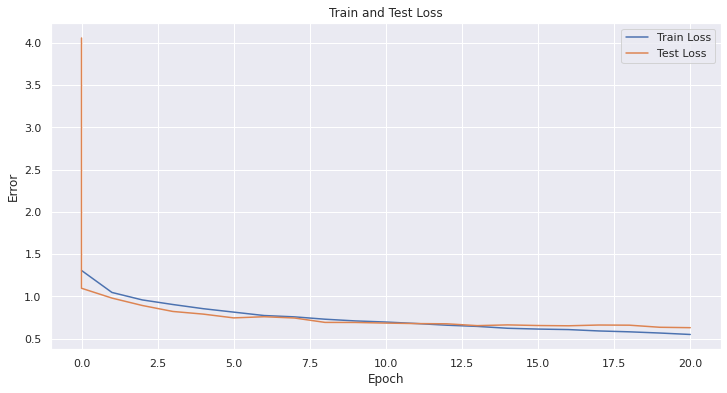

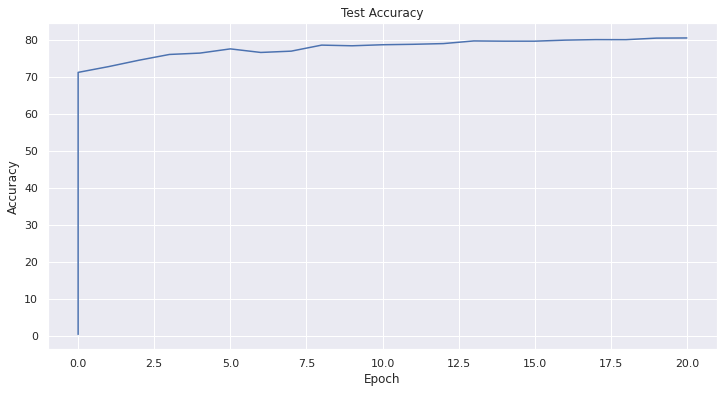

In [13]:
bn_gru_model, bn_en_voc2ind, bn_ind2voc, bn_seq_len, _ = main('bn', 'gru')

Using device cpu
num workers: 48
Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['ক', 'ক']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ক', 'ক']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['ক', 'ক', 'ক']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ক', 'ক', 'ক']



Test set: Average loss: 4.0490, Accuracy: 15427/195976 (8%)



  1%|          | 1/89 [00:00<00:12,  6.80it/s]

Train Epoch: 0 [0/45976 (0%)]	Loss: 4.055797


 13%|█▎        | 12/89 [00:01<00:12,  6.14it/s]

Train Epoch: 0 [5120/45976 (11%)]	Loss: 1.447636


 25%|██▍       | 22/89 [00:03<00:11,  5.97it/s]

Train Epoch: 0 [10240/45976 (22%)]	Loss: 1.184349


 36%|███▌      | 32/89 [00:05<00:09,  6.16it/s]

Train Epoch: 0 [15360/45976 (34%)]	Loss: 1.294332


 47%|████▋     | 42/89 [00:06<00:08,  5.81it/s]

Train Epoch: 0 [20480/45976 (45%)]	Loss: 1.239093


 58%|█████▊    | 52/89 [00:08<00:06,  6.15it/s]

Train Epoch: 0 [25600/45976 (56%)]	Loss: 1.323599


 70%|██████▉   | 62/89 [00:10<00:04,  5.96it/s]

Train Epoch: 0 [30720/45976 (67%)]	Loss: 1.375761


 81%|████████  | 72/89 [00:11<00:03,  5.65it/s]

Train Epoch: 0 [35840/45976 (79%)]	Loss: 1.055989


 92%|█████████▏| 82/89 [00:13<00:01,  6.14it/s]

Train Epoch: 0 [40960/45976 (90%)]	Loss: 1.302325


100%|██████████| 89/89 [00:14<00:00,  6.01it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['া', '্', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['র', '্', '্', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['র', 'স', '্', 'া', '্', 'ি', '্', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['র', 'া', '্', '্', '্', '্', '্', 'র']



Test set: Average loss: 1.2093, Accuracy: 132871/195976 (68%)



  1%|          | 1/89 [00:00<00:14,  6.04it/s]

Train Epoch: 1 [0/45976 (0%)]	Loss: 1.430111


 13%|█▎        | 12/89 [00:01<00:13,  5.78it/s]

Train Epoch: 1 [5120/45976 (11%)]	Loss: 1.206449


 25%|██▍       | 22/89 [00:03<00:10,  6.13it/s]

Train Epoch: 1 [10240/45976 (22%)]	Loss: 1.053248


 36%|███▌      | 32/89 [00:05<00:09,  6.24it/s]

Train Epoch: 1 [15360/45976 (34%)]	Loss: 1.104032


 47%|████▋     | 42/89 [00:06<00:07,  6.15it/s]

Train Epoch: 1 [20480/45976 (45%)]	Loss: 0.954443


 58%|█████▊    | 52/89 [00:08<00:05,  6.20it/s]

Train Epoch: 1 [25600/45976 (56%)]	Loss: 1.054429


 70%|██████▉   | 62/89 [00:10<00:04,  6.17it/s]

Train Epoch: 1 [30720/45976 (67%)]	Loss: 1.187912


 81%|████████  | 72/89 [00:11<00:02,  6.09it/s]

Train Epoch: 1 [35840/45976 (79%)]	Loss: 0.954327


 92%|█████████▏| 82/89 [00:13<00:01,  6.40it/s]

Train Epoch: 1 [40960/45976 (90%)]	Loss: 1.196671


100%|██████████| 89/89 [00:14<00:00,  6.19it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['ব', 'ন', '্', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', '্', '্', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['ব', 'স', '্', 'া', 'ন', 'ি', '্', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['র', 'া', '্', 'া', '্', '্']



Test set: Average loss: 1.0903, Accuracy: 138786/195976 (71%)



  2%|▏         | 2/89 [00:00<00:13,  6.59it/s]

Train Epoch: 2 [0/45976 (0%)]	Loss: 1.273463


 13%|█▎        | 12/89 [00:01<00:12,  6.21it/s]

Train Epoch: 2 [5120/45976 (11%)]	Loss: 1.028222


 25%|██▍       | 22/89 [00:03<00:10,  6.17it/s]

Train Epoch: 2 [10240/45976 (22%)]	Loss: 0.853106


 36%|███▌      | 32/89 [00:05<00:09,  6.22it/s]

Train Epoch: 2 [15360/45976 (34%)]	Loss: 0.942291


 47%|████▋     | 42/89 [00:06<00:07,  6.31it/s]

Train Epoch: 2 [20480/45976 (45%)]	Loss: 0.844040


 58%|█████▊    | 52/89 [00:08<00:06,  6.06it/s]

Train Epoch: 2 [25600/45976 (56%)]	Loss: 0.990100


 70%|██████▉   | 62/89 [00:10<00:04,  6.14it/s]

Train Epoch: 2 [30720/45976 (67%)]	Loss: 1.116609


 81%|████████  | 72/89 [00:11<00:02,  5.86it/s]

Train Epoch: 2 [35840/45976 (79%)]	Loss: 0.849618


 92%|█████████▏| 82/89 [00:13<00:01,  5.84it/s]

Train Epoch: 2 [40960/45976 (90%)]	Loss: 1.164093


100%|██████████| 89/89 [00:14<00:00,  6.09it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', 'ব', 'ত', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', '্', '্', 'ত', 'ন', 'ি', 'য', 'য']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['র', 'া', 'দ', 'া', '্', '্', 'ি', 'র']



Test set: Average loss: 1.0230, Accuracy: 142203/195976 (73%)



  1%|          | 1/89 [00:00<00:14,  5.96it/s]

Train Epoch: 3 [0/45976 (0%)]	Loss: 1.122117


 13%|█▎        | 12/89 [00:01<00:12,  6.34it/s]

Train Epoch: 3 [5120/45976 (11%)]	Loss: 0.923759


 25%|██▍       | 22/89 [00:03<00:10,  6.34it/s]

Train Epoch: 3 [10240/45976 (22%)]	Loss: 0.810269


 36%|███▌      | 32/89 [00:05<00:09,  6.31it/s]

Train Epoch: 3 [15360/45976 (34%)]	Loss: 0.831197


 47%|████▋     | 42/89 [00:06<00:07,  6.28it/s]

Train Epoch: 3 [20480/45976 (45%)]	Loss: 0.779245


 58%|█████▊    | 52/89 [00:08<00:05,  6.24it/s]

Train Epoch: 3 [25600/45976 (56%)]	Loss: 0.895427


 70%|██████▉   | 62/89 [00:10<00:04,  6.20it/s]

Train Epoch: 3 [30720/45976 (67%)]	Loss: 1.034718


 81%|████████  | 72/89 [00:11<00:02,  6.20it/s]

Train Epoch: 3 [35840/45976 (79%)]	Loss: 0.810252


 92%|█████████▏| 82/89 [00:13<00:01,  6.23it/s]

Train Epoch: 3 [40960/45976 (90%)]	Loss: 1.115857


100%|██████████| 89/89 [00:14<00:00,  6.20it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ব', '্', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ত', 'ন', 'ি', 'য', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['এ', 'া', 'দ', 'া', '্', 'া']



Test set: Average loss: 0.9956, Accuracy: 142889/195976 (73%)



  1%|          | 1/89 [00:00<00:14,  6.17it/s]

Train Epoch: 4 [0/45976 (0%)]	Loss: 1.042139


 13%|█▎        | 12/89 [00:01<00:12,  6.39it/s]

Train Epoch: 4 [5120/45976 (11%)]	Loss: 0.843168


 25%|██▍       | 22/89 [00:03<00:10,  6.37it/s]

Train Epoch: 4 [10240/45976 (22%)]	Loss: 0.777990


 36%|███▌      | 32/89 [00:05<00:09,  6.32it/s]

Train Epoch: 4 [15360/45976 (34%)]	Loss: 0.767099


 47%|████▋     | 42/89 [00:06<00:07,  6.23it/s]

Train Epoch: 4 [20480/45976 (45%)]	Loss: 0.730963


 58%|█████▊    | 52/89 [00:08<00:06,  6.14it/s]

Train Epoch: 4 [25600/45976 (56%)]	Loss: 0.835308


 70%|██████▉   | 62/89 [00:09<00:04,  6.23it/s]

Train Epoch: 4 [30720/45976 (67%)]	Loss: 0.983002


 81%|████████  | 72/89 [00:11<00:02,  6.26it/s]

Train Epoch: 4 [35840/45976 (79%)]	Loss: 0.767561


 92%|█████████▏| 82/89 [00:13<00:01,  6.18it/s]

Train Epoch: 4 [40960/45976 (90%)]	Loss: 1.054332


100%|██████████| 89/89 [00:14<00:00,  6.26it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', '্', 'ি', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ব', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', '্', 'ন', 'ি', 'ি', 'য', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', 'দ', 'া', '্', 'া']



Test set: Average loss: 0.9977, Accuracy: 141615/195976 (72%)



  1%|          | 1/89 [00:00<00:14,  6.12it/s]

Train Epoch: 5 [0/45976 (0%)]	Loss: 0.994881


 13%|█▎        | 12/89 [00:01<00:12,  6.22it/s]

Train Epoch: 5 [5120/45976 (11%)]	Loss: 0.790976


 25%|██▍       | 22/89 [00:03<00:12,  5.40it/s]

Train Epoch: 5 [10240/45976 (22%)]	Loss: 0.756327


 36%|███▌      | 32/89 [00:05<00:09,  6.12it/s]

Train Epoch: 5 [15360/45976 (34%)]	Loss: 0.719626


 47%|████▋     | 42/89 [00:06<00:07,  6.19it/s]

Train Epoch: 5 [20480/45976 (45%)]	Loss: 0.703993


 58%|█████▊    | 52/89 [00:08<00:05,  6.35it/s]

Train Epoch: 5 [25600/45976 (56%)]	Loss: 0.789189


 70%|██████▉   | 62/89 [00:10<00:04,  5.58it/s]

Train Epoch: 5 [30720/45976 (67%)]	Loss: 0.956680


 81%|████████  | 72/89 [00:11<00:02,  6.17it/s]

Train Epoch: 5 [35840/45976 (79%)]	Loss: 0.753269


 92%|█████████▏| 82/89 [00:13<00:01,  6.02it/s]

Train Epoch: 5 [40960/45976 (90%)]	Loss: 1.035259


100%|██████████| 89/89 [00:14<00:00,  6.09it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ব', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ত', 'ন', 'ি', 'ি', 'য', 'য']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['আ', 'া', 'দ', 'া', '্', 'া', '্', '্']



Test set: Average loss: 0.9842, Accuracy: 142382/195976 (73%)



  1%|          | 1/89 [00:00<00:13,  6.43it/s]

Train Epoch: 6 [0/45976 (0%)]	Loss: 0.969843


 13%|█▎        | 12/89 [00:01<00:12,  6.23it/s]

Train Epoch: 6 [5120/45976 (11%)]	Loss: 0.758758


 25%|██▍       | 22/89 [00:03<00:11,  6.02it/s]

Train Epoch: 6 [10240/45976 (22%)]	Loss: 0.732825


 36%|███▌      | 32/89 [00:05<00:08,  6.47it/s]

Train Epoch: 6 [15360/45976 (34%)]	Loss: 0.689964


 47%|████▋     | 42/89 [00:06<00:07,  6.30it/s]

Train Epoch: 6 [20480/45976 (45%)]	Loss: 0.681097


 58%|█████▊    | 52/89 [00:08<00:05,  6.31it/s]

Train Epoch: 6 [25600/45976 (56%)]	Loss: 0.750473


 70%|██████▉   | 62/89 [00:09<00:04,  6.44it/s]

Train Epoch: 6 [30720/45976 (67%)]	Loss: 0.944645


 81%|████████  | 72/89 [00:11<00:02,  6.14it/s]

Train Epoch: 6 [35840/45976 (79%)]	Loss: 0.743910


 92%|█████████▏| 82/89 [00:13<00:01,  6.19it/s]

Train Epoch: 6 [40960/45976 (90%)]	Loss: 1.010852


100%|██████████| 89/89 [00:14<00:00,  6.24it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['অ', 'ত', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ি', 'য', 'য', 'া', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', 'দ', 'া', '্', 'া']



Test set: Average loss: 0.9665, Accuracy: 142991/195976 (73%)



  1%|          | 1/89 [00:00<00:14,  6.16it/s]

Train Epoch: 7 [0/45976 (0%)]	Loss: 0.946275


 13%|█▎        | 12/89 [00:01<00:12,  6.36it/s]

Train Epoch: 7 [5120/45976 (11%)]	Loss: 0.737729


 25%|██▍       | 22/89 [00:03<00:10,  6.36it/s]

Train Epoch: 7 [10240/45976 (22%)]	Loss: 0.719449


 36%|███▌      | 32/89 [00:05<00:09,  6.18it/s]

Train Epoch: 7 [15360/45976 (34%)]	Loss: 0.658617


 47%|████▋     | 42/89 [00:06<00:07,  6.28it/s]

Train Epoch: 7 [20480/45976 (45%)]	Loss: 0.667933


 58%|█████▊    | 52/89 [00:08<00:05,  6.21it/s]

Train Epoch: 7 [25600/45976 (56%)]	Loss: 0.723990


 70%|██████▉   | 62/89 [00:09<00:04,  6.32it/s]

Train Epoch: 7 [30720/45976 (67%)]	Loss: 0.936619


 81%|████████  | 72/89 [00:11<00:02,  6.39it/s]

Train Epoch: 7 [35840/45976 (79%)]	Loss: 0.742323


 92%|█████████▏| 82/89 [00:13<00:01,  6.34it/s]

Train Epoch: 7 [40960/45976 (90%)]	Loss: 0.971109


100%|██████████| 89/89 [00:14<00:00,  6.28it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['অ', 'ত', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', '্', '্', 'ত', 'ন', 'ি', 'ি', 'য', '়', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', '্', 'া', '্', 'া', 'ন', '্']



Test set: Average loss: 0.9518, Accuracy: 142947/195976 (73%)



  1%|          | 1/89 [00:00<00:13,  6.37it/s]

Train Epoch: 8 [0/45976 (0%)]	Loss: 0.919654


 13%|█▎        | 12/89 [00:01<00:12,  6.20it/s]

Train Epoch: 8 [5120/45976 (11%)]	Loss: 0.720668


 25%|██▍       | 22/89 [00:03<00:10,  6.15it/s]

Train Epoch: 8 [10240/45976 (22%)]	Loss: 0.721103


 36%|███▌      | 32/89 [00:05<00:09,  6.05it/s]

Train Epoch: 8 [15360/45976 (34%)]	Loss: 0.644336


 47%|████▋     | 42/89 [00:06<00:07,  6.34it/s]

Train Epoch: 8 [20480/45976 (45%)]	Loss: 0.639153


 58%|█████▊    | 52/89 [00:08<00:06,  6.14it/s]

Train Epoch: 8 [25600/45976 (56%)]	Loss: 0.698835


 70%|██████▉   | 62/89 [00:10<00:04,  6.16it/s]

Train Epoch: 8 [30720/45976 (67%)]	Loss: 0.924730


 81%|████████  | 72/89 [00:11<00:02,  6.30it/s]

Train Epoch: 8 [35840/45976 (79%)]	Loss: 0.731607


 92%|█████████▏| 82/89 [00:13<00:01,  6.19it/s]

Train Epoch: 8 [40960/45976 (90%)]	Loss: 1.006357


100%|██████████| 89/89 [00:14<00:00,  6.19it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['অ', 'ত', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', '়', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', '্', 'া', '্', 'া', 'ি', '্']



Test set: Average loss: 0.9555, Accuracy: 143080/195976 (73%)



  1%|          | 1/89 [00:00<00:14,  6.21it/s]

Train Epoch: 9 [0/45976 (0%)]	Loss: 0.916595


 13%|█▎        | 12/89 [00:01<00:12,  6.26it/s]

Train Epoch: 9 [5120/45976 (11%)]	Loss: 0.704404


 25%|██▍       | 22/89 [00:03<00:10,  6.10it/s]

Train Epoch: 9 [10240/45976 (22%)]	Loss: 0.717151


 36%|███▌      | 32/89 [00:05<00:09,  6.16it/s]

Train Epoch: 9 [15360/45976 (34%)]	Loss: 0.625616


 47%|████▋     | 42/89 [00:06<00:07,  5.92it/s]

Train Epoch: 9 [20480/45976 (45%)]	Loss: 0.627509


 58%|█████▊    | 52/89 [00:08<00:05,  6.38it/s]

Train Epoch: 9 [25600/45976 (56%)]	Loss: 0.672756


 70%|██████▉   | 62/89 [00:10<00:04,  6.35it/s]

Train Epoch: 9 [30720/45976 (67%)]	Loss: 0.897811


 81%|████████  | 72/89 [00:11<00:02,  6.18it/s]

Train Epoch: 9 [35840/45976 (79%)]	Loss: 0.725271


 92%|█████████▏| 82/89 [00:13<00:01,  6.38it/s]

Train Epoch: 9 [40960/45976 (90%)]	Loss: 0.953122


100%|██████████| 89/89 [00:14<00:00,  6.20it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['অ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', 'য', 'া', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', '্', 'া', '্', 'া', 'ি', 'র']



Test set: Average loss: 0.9289, Accuracy: 144490/195976 (74%)



  1%|          | 1/89 [00:00<00:13,  6.34it/s]

Train Epoch: 10 [0/45976 (0%)]	Loss: 0.867421


 13%|█▎        | 12/89 [00:01<00:12,  6.31it/s]

Train Epoch: 10 [5120/45976 (11%)]	Loss: 0.679543


 25%|██▍       | 22/89 [00:03<00:10,  6.30it/s]

Train Epoch: 10 [10240/45976 (22%)]	Loss: 0.704818


 36%|███▌      | 32/89 [00:05<00:09,  6.30it/s]

Train Epoch: 10 [15360/45976 (34%)]	Loss: 0.610222


 47%|████▋     | 42/89 [00:06<00:07,  6.27it/s]

Train Epoch: 10 [20480/45976 (45%)]	Loss: 0.612935


 58%|█████▊    | 52/89 [00:08<00:05,  6.40it/s]

Train Epoch: 10 [25600/45976 (56%)]	Loss: 0.677534


 70%|██████▉   | 62/89 [00:09<00:04,  6.37it/s]

Train Epoch: 10 [30720/45976 (67%)]	Loss: 0.867382


 81%|████████  | 72/89 [00:11<00:02,  6.18it/s]

Train Epoch: 10 [35840/45976 (79%)]	Loss: 0.696329


 92%|█████████▏| 82/89 [00:13<00:01,  6.07it/s]

Train Epoch: 10 [40960/45976 (90%)]	Loss: 0.947393


100%|██████████| 89/89 [00:14<00:00,  6.27it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['অ', 'ত', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ন', 'ি', 'য', '়', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', '্', 'া', '্', 'া', 'ি', 'র']



Test set: Average loss: 0.9298, Accuracy: 144554/195976 (74%)



  1%|          | 1/89 [00:00<00:13,  6.54it/s]

Train Epoch: 11 [0/45976 (0%)]	Loss: 0.847565


 13%|█▎        | 12/89 [00:01<00:12,  6.11it/s]

Train Epoch: 11 [5120/45976 (11%)]	Loss: 0.676427


 25%|██▍       | 22/89 [00:03<00:10,  6.36it/s]

Train Epoch: 11 [10240/45976 (22%)]	Loss: 0.687287


 36%|███▌      | 32/89 [00:05<00:09,  6.21it/s]

Train Epoch: 11 [15360/45976 (34%)]	Loss: 0.600256


 47%|████▋     | 42/89 [00:06<00:07,  6.28it/s]

Train Epoch: 11 [20480/45976 (45%)]	Loss: 0.590734


 58%|█████▊    | 52/89 [00:08<00:06,  5.94it/s]

Train Epoch: 11 [25600/45976 (56%)]	Loss: 0.629872


 70%|██████▉   | 62/89 [00:10<00:04,  6.00it/s]

Train Epoch: 11 [30720/45976 (67%)]	Loss: 0.852586


 81%|████████  | 72/89 [00:11<00:02,  6.31it/s]

Train Epoch: 11 [35840/45976 (79%)]	Loss: 0.687906


 92%|█████████▏| 82/89 [00:13<00:01,  6.03it/s]

Train Epoch: 11 [40960/45976 (90%)]	Loss: 0.934108


100%|██████████| 89/89 [00:14<00:00,  6.18it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['আ', 'ত', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'া', 'ন', 'ি', 'য', '়', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', '্', 'া', '্', 'া', 'ি', 'র']



Test set: Average loss: 0.9194, Accuracy: 144614/195976 (74%)



  1%|          | 1/89 [00:00<00:14,  6.06it/s]

Train Epoch: 12 [0/45976 (0%)]	Loss: 0.837954


 13%|█▎        | 12/89 [00:01<00:11,  6.45it/s]

Train Epoch: 12 [5120/45976 (11%)]	Loss: 0.668651


 25%|██▍       | 22/89 [00:03<00:10,  6.27it/s]

Train Epoch: 12 [10240/45976 (22%)]	Loss: 0.676101


 36%|███▌      | 32/89 [00:05<00:09,  6.30it/s]

Train Epoch: 12 [15360/45976 (34%)]	Loss: 0.582498


 47%|████▋     | 42/89 [00:06<00:07,  6.23it/s]

Train Epoch: 12 [20480/45976 (45%)]	Loss: 0.574336


 58%|█████▊    | 52/89 [00:08<00:06,  6.09it/s]

Train Epoch: 12 [25600/45976 (56%)]	Loss: 0.617779


 70%|██████▉   | 62/89 [00:09<00:04,  6.35it/s]

Train Epoch: 12 [30720/45976 (67%)]	Loss: 0.834581


 81%|████████  | 72/89 [00:11<00:02,  6.20it/s]

Train Epoch: 12 [35840/45976 (79%)]	Loss: 0.670515


 92%|█████████▏| 82/89 [00:13<00:01,  6.09it/s]

Train Epoch: 12 [40960/45976 (90%)]	Loss: 0.924535


100%|██████████| 89/89 [00:14<00:00,  6.24it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'শ', '্', 'ট', 'ন', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', 'দ', 'া', '্', 'া', 'ি']



Test set: Average loss: 0.9154, Accuracy: 145647/195976 (74%)



  1%|          | 1/89 [00:00<00:13,  6.33it/s]

Train Epoch: 13 [0/45976 (0%)]	Loss: 0.839664


 13%|█▎        | 12/89 [00:01<00:12,  6.17it/s]

Train Epoch: 13 [5120/45976 (11%)]	Loss: 0.658770


 25%|██▍       | 22/89 [00:03<00:10,  6.31it/s]

Train Epoch: 13 [10240/45976 (22%)]	Loss: 0.677862


 36%|███▌      | 32/89 [00:05<00:08,  6.48it/s]

Train Epoch: 13 [15360/45976 (34%)]	Loss: 0.590118


 47%|████▋     | 42/89 [00:06<00:07,  6.09it/s]

Train Epoch: 13 [20480/45976 (45%)]	Loss: 0.572374


 58%|█████▊    | 52/89 [00:08<00:05,  6.35it/s]

Train Epoch: 13 [25600/45976 (56%)]	Loss: 0.622055


 70%|██████▉   | 62/89 [00:09<00:04,  6.35it/s]

Train Epoch: 13 [30720/45976 (67%)]	Loss: 0.821553


 81%|████████  | 72/89 [00:11<00:02,  6.38it/s]

Train Epoch: 13 [35840/45976 (79%)]	Loss: 0.672427


 92%|█████████▏| 82/89 [00:13<00:01,  6.26it/s]

Train Epoch: 13 [40960/45976 (90%)]	Loss: 0.921010


100%|██████████| 89/89 [00:14<00:00,  6.22it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'শ', '্', 'ট', 'ন', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', 'দ', 'া', '্', 'া', 'ত']



Test set: Average loss: 0.9094, Accuracy: 146056/195976 (75%)



  1%|          | 1/89 [00:00<00:14,  5.90it/s]

Train Epoch: 14 [0/45976 (0%)]	Loss: 0.837118


 13%|█▎        | 12/89 [00:01<00:11,  6.52it/s]

Train Epoch: 14 [5120/45976 (11%)]	Loss: 0.654496


 25%|██▍       | 22/89 [00:03<00:10,  6.39it/s]

Train Epoch: 14 [10240/45976 (22%)]	Loss: 0.663555


 36%|███▌      | 32/89 [00:04<00:08,  6.48it/s]

Train Epoch: 14 [15360/45976 (34%)]	Loss: 0.573844


 47%|████▋     | 42/89 [00:06<00:07,  6.23it/s]

Train Epoch: 14 [20480/45976 (45%)]	Loss: 0.556101


 58%|█████▊    | 52/89 [00:08<00:05,  6.40it/s]

Train Epoch: 14 [25600/45976 (56%)]	Loss: 0.596859


 70%|██████▉   | 62/89 [00:09<00:04,  6.13it/s]

Train Epoch: 14 [30720/45976 (67%)]	Loss: 0.833165


 81%|████████  | 72/89 [00:11<00:02,  6.38it/s]

Train Epoch: 14 [35840/45976 (79%)]	Loss: 0.676596


 92%|█████████▏| 82/89 [00:12<00:01,  6.43it/s]

Train Epoch: 14 [40960/45976 (90%)]	Loss: 0.887262


100%|██████████| 89/89 [00:14<00:00,  6.35it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ী']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['হ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', 'দ', 'া', '্', 'া', '্']



Test set: Average loss: 0.9257, Accuracy: 145431/195976 (74%)



  1%|          | 1/89 [00:00<00:13,  6.52it/s]

Train Epoch: 15 [0/45976 (0%)]	Loss: 0.780344


 13%|█▎        | 12/89 [00:01<00:13,  5.79it/s]

Train Epoch: 15 [5120/45976 (11%)]	Loss: 0.642566


 25%|██▍       | 22/89 [00:03<00:10,  6.11it/s]

Train Epoch: 15 [10240/45976 (22%)]	Loss: 0.639620


 36%|███▌      | 32/89 [00:05<00:09,  6.11it/s]

Train Epoch: 15 [15360/45976 (34%)]	Loss: 0.568453


 47%|████▋     | 42/89 [00:06<00:07,  5.90it/s]

Train Epoch: 15 [20480/45976 (45%)]	Loss: 0.552262


 58%|█████▊    | 52/89 [00:08<00:05,  6.17it/s]

Train Epoch: 15 [25600/45976 (56%)]	Loss: 0.580006


 70%|██████▉   | 62/89 [00:10<00:04,  6.38it/s]

Train Epoch: 15 [30720/45976 (67%)]	Loss: 0.827745


 81%|████████  | 72/89 [00:11<00:02,  6.10it/s]

Train Epoch: 15 [35840/45976 (79%)]	Loss: 0.666150


 92%|█████████▏| 82/89 [00:13<00:01,  6.11it/s]

Train Epoch: 15 [40960/45976 (90%)]	Loss: 0.867683


100%|██████████| 89/89 [00:14<00:00,  6.14it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['হ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', 'দ', 'া', '্', 'র', 'ত']



Test set: Average loss: 0.9219, Accuracy: 145209/195976 (74%)



  1%|          | 1/89 [00:00<00:14,  5.97it/s]

Train Epoch: 16 [0/45976 (0%)]	Loss: 0.774276


 13%|█▎        | 12/89 [00:02<00:12,  6.22it/s]

Train Epoch: 16 [5120/45976 (11%)]	Loss: 0.627211


 25%|██▍       | 22/89 [00:03<00:10,  6.27it/s]

Train Epoch: 16 [10240/45976 (22%)]	Loss: 0.618429


 36%|███▌      | 32/89 [00:05<00:09,  6.17it/s]

Train Epoch: 16 [15360/45976 (34%)]	Loss: 0.560012


 47%|████▋     | 42/89 [00:06<00:07,  6.12it/s]

Train Epoch: 16 [20480/45976 (45%)]	Loss: 0.537698


 58%|█████▊    | 52/89 [00:08<00:06,  6.11it/s]

Train Epoch: 16 [25600/45976 (56%)]	Loss: 0.554066


 70%|██████▉   | 62/89 [00:10<00:04,  6.17it/s]

Train Epoch: 16 [30720/45976 (67%)]	Loss: 0.836704


 81%|████████  | 72/89 [00:11<00:02,  6.16it/s]

Train Epoch: 16 [35840/45976 (79%)]	Loss: 0.645607


 92%|█████████▏| 82/89 [00:13<00:01,  6.03it/s]

Train Epoch: 16 [40960/45976 (90%)]	Loss: 0.862566


100%|██████████| 89/89 [00:14<00:00,  6.09it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'র']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['হ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ফ', 'া', '্', 'া', 'র', 'র', '্']



Test set: Average loss: 0.9353, Accuracy: 144884/195976 (74%)



  1%|          | 1/89 [00:00<00:13,  6.46it/s]

Train Epoch: 17 [0/45976 (0%)]	Loss: 0.755668


 13%|█▎        | 12/89 [00:01<00:13,  5.77it/s]

Train Epoch: 17 [5120/45976 (11%)]	Loss: 0.611520


 25%|██▍       | 22/89 [00:03<00:10,  6.39it/s]

Train Epoch: 17 [10240/45976 (22%)]	Loss: 0.607605


 36%|███▌      | 32/89 [00:05<00:08,  6.38it/s]

Train Epoch: 17 [15360/45976 (34%)]	Loss: 0.549097


 47%|████▋     | 42/89 [00:06<00:07,  6.44it/s]

Train Epoch: 17 [20480/45976 (45%)]	Loss: 0.526433


 58%|█████▊    | 52/89 [00:08<00:05,  6.38it/s]

Train Epoch: 17 [25600/45976 (56%)]	Loss: 0.581394


 70%|██████▉   | 62/89 [00:09<00:04,  6.39it/s]

Train Epoch: 17 [30720/45976 (67%)]	Loss: 0.811033


 81%|████████  | 72/89 [00:11<00:02,  6.19it/s]

Train Epoch: 17 [35840/45976 (79%)]	Loss: 0.638268


 92%|█████████▏| 82/89 [00:12<00:01,  6.31it/s]

Train Epoch: 17 [40960/45976 (90%)]	Loss: 0.869131


100%|██████████| 89/89 [00:13<00:00,  6.36it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', '্', 'ট', 'ট', 'ন', 'ি', 'ি', 'য', '়', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['ফ', 'া', '্', 'য', 'র', 'া', 'র']



Test set: Average loss: 0.9366, Accuracy: 144964/195976 (74%)



  1%|          | 1/89 [00:00<00:14,  6.28it/s]

Train Epoch: 18 [0/45976 (0%)]	Loss: 0.741558


 13%|█▎        | 12/89 [00:02<00:12,  6.00it/s]

Train Epoch: 18 [5120/45976 (11%)]	Loss: 0.594604


 25%|██▍       | 22/89 [00:03<00:11,  5.62it/s]

Train Epoch: 18 [10240/45976 (22%)]	Loss: 0.598808


 36%|███▌      | 32/89 [00:05<00:08,  6.37it/s]

Train Epoch: 18 [15360/45976 (34%)]	Loss: 0.546195


 47%|████▋     | 42/89 [00:07<00:07,  6.03it/s]

Train Epoch: 18 [20480/45976 (45%)]	Loss: 0.520547


 58%|█████▊    | 52/89 [00:08<00:06,  6.10it/s]

Train Epoch: 18 [25600/45976 (56%)]	Loss: 0.532157


 70%|██████▉   | 62/89 [00:10<00:04,  6.30it/s]

Train Epoch: 18 [30720/45976 (67%)]	Loss: 0.793485


 81%|████████  | 72/89 [00:12<00:02,  6.08it/s]

Train Epoch: 18 [35840/45976 (79%)]	Loss: 0.637583


 92%|█████████▏| 82/89 [00:13<00:01,  6.15it/s]

Train Epoch: 18 [40960/45976 (90%)]	Loss: 0.858611


100%|██████████| 89/89 [00:14<00:00,  6.02it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['হ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', '্', 'ট', 'ন', 'ন', 'য', 'য', '়', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'ম', '্', 'া', 'া', 'া', '্']



Test set: Average loss: 0.9665, Accuracy: 144397/195976 (74%)



  1%|          | 1/89 [00:00<00:14,  6.18it/s]

Train Epoch: 19 [0/45976 (0%)]	Loss: 0.758782


 13%|█▎        | 12/89 [00:01<00:12,  6.15it/s]

Train Epoch: 19 [5120/45976 (11%)]	Loss: 0.589695


 25%|██▍       | 22/89 [00:03<00:10,  6.33it/s]

Train Epoch: 19 [10240/45976 (22%)]	Loss: 0.590615


 36%|███▌      | 32/89 [00:05<00:09,  6.19it/s]

Train Epoch: 19 [15360/45976 (34%)]	Loss: 0.518381


 47%|████▋     | 42/89 [00:06<00:07,  6.33it/s]

Train Epoch: 19 [20480/45976 (45%)]	Loss: 0.511630


 58%|█████▊    | 52/89 [00:08<00:05,  6.30it/s]

Train Epoch: 19 [25600/45976 (56%)]	Loss: 0.525009


 70%|██████▉   | 62/89 [00:09<00:04,  6.34it/s]

Train Epoch: 19 [30720/45976 (67%)]	Loss: 0.838915


 81%|████████  | 72/89 [00:11<00:02,  6.30it/s]

Train Epoch: 19 [35840/45976 (79%)]	Loss: 0.626785


 92%|█████████▏| 82/89 [00:13<00:01,  6.26it/s]

Train Epoch: 19 [40960/45976 (90%)]	Loss: 0.834837


100%|██████████| 89/89 [00:14<00:00,  6.26it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ত', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', 'ট', 'ট', 'ন', 'ন', 'ি', 'য', '়']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', '্', 'য', '্', 'া', '্']



Test set: Average loss: 0.9596, Accuracy: 144947/195976 (74%)



  1%|          | 1/89 [00:00<00:14,  6.27it/s]

Train Epoch: 20 [0/45976 (0%)]	Loss: 0.734872


 13%|█▎        | 12/89 [00:01<00:12,  6.05it/s]

Train Epoch: 20 [5120/45976 (11%)]	Loss: 0.564351


 25%|██▍       | 22/89 [00:03<00:10,  6.11it/s]

Train Epoch: 20 [10240/45976 (22%)]	Loss: 0.579296


 36%|███▌      | 32/89 [00:05<00:09,  6.25it/s]

Train Epoch: 20 [15360/45976 (34%)]	Loss: 0.525153


 47%|████▋     | 42/89 [00:07<00:08,  5.65it/s]

Train Epoch: 20 [20480/45976 (45%)]	Loss: 0.495062


 58%|█████▊    | 52/89 [00:08<00:06,  6.00it/s]

Train Epoch: 20 [25600/45976 (56%)]	Loss: 0.512542


 70%|██████▉   | 62/89 [00:10<00:04,  6.40it/s]

Train Epoch: 20 [30720/45976 (67%)]	Loss: 0.781034


 81%|████████  | 72/89 [00:11<00:02,  6.27it/s]

Train Epoch: 20 [35840/45976 (79%)]	Loss: 0.625332


 92%|█████████▏| 82/89 [00:13<00:01,  6.09it/s]

Train Epoch: 20 [40960/45976 (90%)]	Loss: 0.825631


100%|██████████| 89/89 [00:14<00:00,  6.10it/s]


Input	['a', 'n', 'r', 'i']
GT	['অ', 'ঁ', 'র', 'ি']
pred	['আ', 'ন', 'র', 'ি']


Input	['b', 'o', 'g', 'a']
GT	['ব', 'গ', 'া']
pred	['ভ', 'ো', 'গ', 'া']


Input	['e', 's', 't', 'a', 'n', 'i', 'y', 'a']
GT	['এ', 'স', '্', 'ত', 'ো', 'ন', 'ি', 'য', '়', 'া']
pred	['এ', 'স', 'ট', 'ট', 'ন', 'ন', 'ি', 'য', '়', 'া']


Input	['m', 'a', 'd', 'h', 'o', 'b', 'i', 'r']
GT	['ম', 'া', 'ধ', 'ব', 'ী', 'র']
pred	['স', 'া', '্', 'া', 'া', 'া', '্']



Test set: Average loss: 0.9706, Accuracy: 144360/195976 (74%)



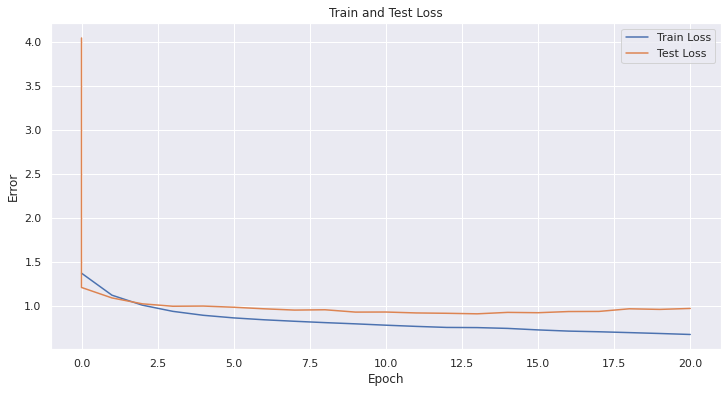

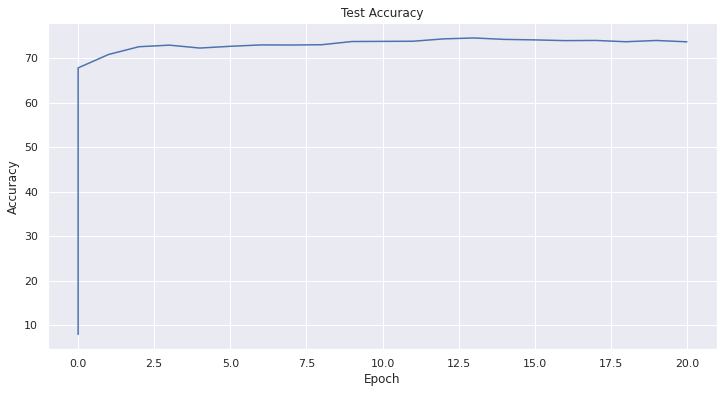

In [14]:
bn_lstm_model, _, _, _, _ = main('bn', 'lstm')

Using device cpu
num workers: 48
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['ि', 'ू', 'स', 'स', 'स', 'स', 'स', 'भ', 'भ', 'भ', 'ञ', 'ञ', 'ञ', 'ञ', 'ञ', 'ञ', 'ञ', 'ञ', 'ञ']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ि']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ि', 'ू']



Test set: Average loss: 4.0993, Accuracy: 3013/119035 (3%)



  3%|▎         | 2/61 [00:00<00:06,  8.43it/s]

Train Epoch: 0 [0/31587 (0%)]	Loss: 4.108767


 20%|█▉        | 12/61 [00:01<00:06,  7.77it/s]

Train Epoch: 0 [5120/31587 (16%)]	Loss: 1.280263


 36%|███▌      | 22/61 [00:02<00:04,  8.49it/s]

Train Epoch: 0 [10240/31587 (33%)]	Loss: 1.168015


 52%|█████▏    | 32/61 [00:03<00:03,  8.43it/s]

Train Epoch: 0 [15360/31587 (49%)]	Loss: 1.393260


 69%|██████▉   | 42/61 [00:05<00:02,  8.19it/s]

Train Epoch: 0 [20480/31587 (66%)]	Loss: 1.375802


 85%|████████▌ | 52/61 [00:06<00:01,  8.08it/s]

Train Epoch: 0 [25600/31587 (82%)]	Loss: 1.161407


100%|██████████| 61/61 [00:07<00:00,  8.25it/s]


Train Epoch: 0 [30720/31587 (98%)]	Loss: 1.165055
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['व', 'ं', 'क', 'ा', 'ं']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ा', 'ं', 'ि', '्']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['स', 'ा', 'स', 'ि', 'ं']



Test set: Average loss: 1.0958, Accuracy: 84569/119035 (71%)



  3%|▎         | 2/61 [00:00<00:08,  7.33it/s]

Train Epoch: 1 [0/31587 (0%)]	Loss: 1.375938


 20%|█▉        | 12/61 [00:01<00:06,  7.58it/s]

Train Epoch: 1 [5120/31587 (16%)]	Loss: 0.999725


 36%|███▌      | 22/61 [00:02<00:05,  7.65it/s]

Train Epoch: 1 [10240/31587 (33%)]	Loss: 0.940652


 52%|█████▏    | 32/61 [00:04<00:03,  7.75it/s]

Train Epoch: 1 [15360/31587 (49%)]	Loss: 1.142698


 69%|██████▉   | 42/61 [00:05<00:02,  7.63it/s]

Train Epoch: 1 [20480/31587 (66%)]	Loss: 1.260397


 85%|████████▌ | 52/61 [00:06<00:01,  8.04it/s]

Train Epoch: 1 [25600/31587 (82%)]	Loss: 0.916693


100%|██████████| 61/61 [00:07<00:00,  7.71it/s]


Train Epoch: 1 [30720/31587 (98%)]	Loss: 1.031575
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['ज', 'न', 'क', 'न']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'व', 'न']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', '्', 'ं']



Test set: Average loss: 0.9209, Accuracy: 88913/119035 (75%)



  3%|▎         | 2/61 [00:00<00:07,  8.26it/s]

Train Epoch: 2 [0/31587 (0%)]	Loss: 1.118819


 20%|█▉        | 12/61 [00:01<00:06,  8.15it/s]

Train Epoch: 2 [5120/31587 (16%)]	Loss: 0.945553


 36%|███▌      | 22/61 [00:02<00:04,  8.18it/s]

Train Epoch: 2 [10240/31587 (33%)]	Loss: 0.812669


 52%|█████▏    | 32/61 [00:04<00:03,  7.78it/s]

Train Epoch: 2 [15360/31587 (49%)]	Loss: 1.072902


 69%|██████▉   | 42/61 [00:05<00:02,  7.79it/s]

Train Epoch: 2 [20480/31587 (66%)]	Loss: 1.158011


 85%|████████▌ | 52/61 [00:06<00:01,  7.86it/s]

Train Epoch: 2 [25600/31587 (82%)]	Loss: 0.712000


100%|██████████| 61/61 [00:07<00:00,  7.87it/s]


Train Epoch: 2 [30720/31587 (98%)]	Loss: 0.925002
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'ा', 'ह', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'ं']



Test set: Average loss: 0.8094, Accuracy: 91179/119035 (77%)



  3%|▎         | 2/61 [00:00<00:06,  8.58it/s]

Train Epoch: 3 [0/31587 (0%)]	Loss: 0.883383


 20%|█▉        | 12/61 [00:01<00:06,  7.98it/s]

Train Epoch: 3 [5120/31587 (16%)]	Loss: 0.817636


 36%|███▌      | 22/61 [00:02<00:04,  7.94it/s]

Train Epoch: 3 [10240/31587 (33%)]	Loss: 0.712358


 52%|█████▏    | 32/61 [00:03<00:03,  8.25it/s]

Train Epoch: 3 [15360/31587 (49%)]	Loss: 1.015988


 69%|██████▉   | 42/61 [00:05<00:02,  7.93it/s]

Train Epoch: 3 [20480/31587 (66%)]	Loss: 1.087986


 85%|████████▌ | 52/61 [00:06<00:01,  7.73it/s]

Train Epoch: 3 [25600/31587 (82%)]	Loss: 0.661297


100%|██████████| 61/61 [00:07<00:00,  8.00it/s]


Train Epoch: 3 [30720/31587 (98%)]	Loss: 0.866558
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'ा', 'ह', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'ं']



Test set: Average loss: 0.7402, Accuracy: 92843/119035 (78%)



  3%|▎         | 2/61 [00:00<00:07,  8.22it/s]

Train Epoch: 4 [0/31587 (0%)]	Loss: 0.850701


 20%|█▉        | 12/61 [00:01<00:06,  8.10it/s]

Train Epoch: 4 [5120/31587 (16%)]	Loss: 0.766184


 36%|███▌      | 22/61 [00:02<00:04,  8.07it/s]

Train Epoch: 4 [10240/31587 (33%)]	Loss: 0.648201


 52%|█████▏    | 32/61 [00:03<00:03,  8.07it/s]

Train Epoch: 4 [15360/31587 (49%)]	Loss: 0.980782


 69%|██████▉   | 42/61 [00:05<00:02,  8.33it/s]

Train Epoch: 4 [20480/31587 (66%)]	Loss: 0.988496


 85%|████████▌ | 52/61 [00:06<00:01,  7.77it/s]

Train Epoch: 4 [25600/31587 (82%)]	Loss: 0.627256


100%|██████████| 61/61 [00:07<00:00,  8.08it/s]


Train Epoch: 4 [30720/31587 (98%)]	Loss: 0.778844
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा', 'न']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'ा', 'ह', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 0.7080, Accuracy: 93457/119035 (79%)



  3%|▎         | 2/61 [00:00<00:06,  8.55it/s]

Train Epoch: 5 [0/31587 (0%)]	Loss: 0.738731


 20%|█▉        | 12/61 [00:01<00:06,  7.73it/s]

Train Epoch: 5 [5120/31587 (16%)]	Loss: 0.718870


 36%|███▌      | 22/61 [00:02<00:04,  8.43it/s]

Train Epoch: 5 [10240/31587 (33%)]	Loss: 0.632909


 52%|█████▏    | 32/61 [00:03<00:03,  8.25it/s]

Train Epoch: 5 [15360/31587 (49%)]	Loss: 0.932917


 69%|██████▉   | 42/61 [00:05<00:02,  8.63it/s]

Train Epoch: 5 [20480/31587 (66%)]	Loss: 0.948659


 85%|████████▌ | 52/61 [00:06<00:01,  8.36it/s]

Train Epoch: 5 [25600/31587 (82%)]	Loss: 0.581811


100%|██████████| 61/61 [00:07<00:00,  8.35it/s]


Train Epoch: 5 [30720/31587 (98%)]	Loss: 0.775078
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'ा', 'ह', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स']



Test set: Average loss: 0.6962, Accuracy: 93426/119035 (78%)



  3%|▎         | 2/61 [00:00<00:06,  8.53it/s]

Train Epoch: 6 [0/31587 (0%)]	Loss: 0.798871


 20%|█▉        | 12/61 [00:01<00:05,  8.38it/s]

Train Epoch: 6 [5120/31587 (16%)]	Loss: 0.716682


 36%|███▌      | 22/61 [00:02<00:04,  8.17it/s]

Train Epoch: 6 [10240/31587 (33%)]	Loss: 0.571244


 52%|█████▏    | 32/61 [00:03<00:03,  8.27it/s]

Train Epoch: 6 [15360/31587 (49%)]	Loss: 0.879983


 69%|██████▉   | 42/61 [00:05<00:02,  8.23it/s]

Train Epoch: 6 [20480/31587 (66%)]	Loss: 0.884896


 85%|████████▌ | 52/61 [00:06<00:01,  7.72it/s]

Train Epoch: 6 [25600/31587 (82%)]	Loss: 0.546616


100%|██████████| 61/61 [00:07<00:00,  8.11it/s]


Train Epoch: 6 [30720/31587 (98%)]	Loss: 0.733792
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'ा', 'ह', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ी', 'न']



Test set: Average loss: 0.6488, Accuracy: 95197/119035 (80%)



  3%|▎         | 2/61 [00:00<00:06,  8.65it/s]

Train Epoch: 7 [0/31587 (0%)]	Loss: 0.673209


 20%|█▉        | 12/61 [00:01<00:06,  8.06it/s]

Train Epoch: 7 [5120/31587 (16%)]	Loss: 0.685546


 36%|███▌      | 22/61 [00:02<00:04,  8.42it/s]

Train Epoch: 7 [10240/31587 (33%)]	Loss: 0.567035


 52%|█████▏    | 32/61 [00:03<00:03,  8.45it/s]

Train Epoch: 7 [15360/31587 (49%)]	Loss: 0.837961


 69%|██████▉   | 42/61 [00:05<00:02,  8.04it/s]

Train Epoch: 7 [20480/31587 (66%)]	Loss: 0.852899


 85%|████████▌ | 52/61 [00:06<00:01,  8.37it/s]

Train Epoch: 7 [25600/31587 (82%)]	Loss: 0.532067


100%|██████████| 61/61 [00:07<00:00,  8.20it/s]


Train Epoch: 7 [30720/31587 (98%)]	Loss: 0.679442
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'ा', 'ह', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स']



Test set: Average loss: 0.6443, Accuracy: 95075/119035 (80%)



  3%|▎         | 2/61 [00:00<00:07,  8.10it/s]

Train Epoch: 8 [0/31587 (0%)]	Loss: 0.811083


 20%|█▉        | 12/61 [00:01<00:06,  7.78it/s]

Train Epoch: 8 [5120/31587 (16%)]	Loss: 0.659014


 36%|███▌      | 22/61 [00:02<00:04,  8.52it/s]

Train Epoch: 8 [10240/31587 (33%)]	Loss: 0.522923


 52%|█████▏    | 32/61 [00:03<00:03,  8.29it/s]

Train Epoch: 8 [15360/31587 (49%)]	Loss: 0.803573


 69%|██████▉   | 42/61 [00:05<00:02,  7.90it/s]

Train Epoch: 8 [20480/31587 (66%)]	Loss: 0.824250


 85%|████████▌ | 52/61 [00:06<00:01,  8.25it/s]

Train Epoch: 8 [25600/31587 (82%)]	Loss: 0.523468


100%|██████████| 61/61 [00:07<00:00,  8.09it/s]


Train Epoch: 8 [30720/31587 (98%)]	Loss: 0.689565
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ह', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न', 'न']



Test set: Average loss: 0.6245, Accuracy: 95691/119035 (80%)



  3%|▎         | 2/61 [00:00<00:07,  8.12it/s]

Train Epoch: 9 [0/31587 (0%)]	Loss: 0.627867


 20%|█▉        | 12/61 [00:01<00:05,  8.44it/s]

Train Epoch: 9 [5120/31587 (16%)]	Loss: 0.654549


 36%|███▌      | 22/61 [00:02<00:04,  8.32it/s]

Train Epoch: 9 [10240/31587 (33%)]	Loss: 0.532199


 52%|█████▏    | 32/61 [00:03<00:03,  8.26it/s]

Train Epoch: 9 [15360/31587 (49%)]	Loss: 0.791465


 69%|██████▉   | 42/61 [00:05<00:02,  7.92it/s]

Train Epoch: 9 [20480/31587 (66%)]	Loss: 0.801165


 85%|████████▌ | 52/61 [00:06<00:01,  8.17it/s]

Train Epoch: 9 [25600/31587 (82%)]	Loss: 0.495283


100%|██████████| 61/61 [00:07<00:00,  8.07it/s]


Train Epoch: 9 [30720/31587 (98%)]	Loss: 0.635111
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ा', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न', 'न']



Test set: Average loss: 0.6354, Accuracy: 95160/119035 (80%)



  3%|▎         | 2/61 [00:00<00:07,  8.26it/s]

Train Epoch: 10 [0/31587 (0%)]	Loss: 0.786256


 20%|█▉        | 12/61 [00:01<00:06,  7.92it/s]

Train Epoch: 10 [5120/31587 (16%)]	Loss: 0.632020


 36%|███▌      | 22/61 [00:02<00:04,  8.15it/s]

Train Epoch: 10 [10240/31587 (33%)]	Loss: 0.500979


 52%|█████▏    | 32/61 [00:04<00:04,  7.18it/s]

Train Epoch: 10 [15360/31587 (49%)]	Loss: 0.807315


 69%|██████▉   | 42/61 [00:05<00:02,  7.69it/s]

Train Epoch: 10 [20480/31587 (66%)]	Loss: 0.799586


 85%|████████▌ | 52/61 [00:06<00:01,  7.85it/s]

Train Epoch: 10 [25600/31587 (82%)]	Loss: 0.494995


100%|██████████| 61/61 [00:07<00:00,  7.72it/s]


Train Epoch: 10 [30720/31587 (98%)]	Loss: 0.617017
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न', 'न']



Test set: Average loss: 0.6496, Accuracy: 94855/119035 (80%)



  3%|▎         | 2/61 [00:00<00:07,  7.61it/s]

Train Epoch: 11 [0/31587 (0%)]	Loss: 0.579075


 20%|█▉        | 12/61 [00:01<00:06,  7.72it/s]

Train Epoch: 11 [5120/31587 (16%)]	Loss: 0.620088


 36%|███▌      | 22/61 [00:02<00:05,  7.71it/s]

Train Epoch: 11 [10240/31587 (33%)]	Loss: 0.530503


 52%|█████▏    | 32/61 [00:04<00:03,  7.69it/s]

Train Epoch: 11 [15360/31587 (49%)]	Loss: 0.767886


 69%|██████▉   | 42/61 [00:05<00:02,  7.71it/s]

Train Epoch: 11 [20480/31587 (66%)]	Loss: 0.784190


 85%|████████▌ | 52/61 [00:06<00:01,  7.75it/s]

Train Epoch: 11 [25600/31587 (82%)]	Loss: 0.500497


100%|██████████| 61/61 [00:07<00:00,  7.77it/s]


Train Epoch: 11 [30720/31587 (98%)]	Loss: 0.615275
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'ि', 'न']



Test set: Average loss: 0.6662, Accuracy: 94263/119035 (79%)



  3%|▎         | 2/61 [00:00<00:07,  8.38it/s]

Train Epoch: 12 [0/31587 (0%)]	Loss: 0.749409


 20%|█▉        | 12/61 [00:01<00:06,  8.14it/s]

Train Epoch: 12 [5120/31587 (16%)]	Loss: 0.636043


 36%|███▌      | 22/61 [00:02<00:04,  7.92it/s]

Train Epoch: 12 [10240/31587 (33%)]	Loss: 0.471324


 52%|█████▏    | 32/61 [00:04<00:03,  7.86it/s]

Train Epoch: 12 [15360/31587 (49%)]	Loss: 0.823311


 69%|██████▉   | 42/61 [00:05<00:02,  8.27it/s]

Train Epoch: 12 [20480/31587 (66%)]	Loss: 0.751686


 85%|████████▌ | 52/61 [00:06<00:01,  8.49it/s]

Train Epoch: 12 [25600/31587 (82%)]	Loss: 0.455350


100%|██████████| 61/61 [00:07<00:00,  8.05it/s]


Train Epoch: 12 [30720/31587 (98%)]	Loss: 0.603438
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न', 'न']



Test set: Average loss: 0.6109, Accuracy: 95862/119035 (81%)



  3%|▎         | 2/61 [00:00<00:06,  8.63it/s]

Train Epoch: 13 [0/31587 (0%)]	Loss: 0.561023


 20%|█▉        | 12/61 [00:01<00:06,  8.13it/s]

Train Epoch: 13 [5120/31587 (16%)]	Loss: 0.586847


 36%|███▌      | 22/61 [00:02<00:04,  8.43it/s]

Train Epoch: 13 [10240/31587 (33%)]	Loss: 0.466285


 52%|█████▏    | 32/61 [00:03<00:03,  8.39it/s]

Train Epoch: 13 [15360/31587 (49%)]	Loss: 0.774741


 69%|██████▉   | 42/61 [00:05<00:02,  8.34it/s]

Train Epoch: 13 [20480/31587 (66%)]	Loss: 0.751507


 85%|████████▌ | 52/61 [00:06<00:01,  7.66it/s]

Train Epoch: 13 [25600/31587 (82%)]	Loss: 0.482560


100%|██████████| 61/61 [00:07<00:00,  8.18it/s]


Train Epoch: 13 [30720/31587 (98%)]	Loss: 0.588907
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'ं', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ा', 'ा', 'न', 'ी']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न', 'न']



Test set: Average loss: 0.6391, Accuracy: 95163/119035 (80%)



  3%|▎         | 2/61 [00:00<00:07,  7.40it/s]

Train Epoch: 14 [0/31587 (0%)]	Loss: 0.750997


 20%|█▉        | 12/61 [00:01<00:06,  8.08it/s]

Train Epoch: 14 [5120/31587 (16%)]	Loss: 0.601028


 36%|███▌      | 22/61 [00:02<00:04,  8.10it/s]

Train Epoch: 14 [10240/31587 (33%)]	Loss: 0.458907


 52%|█████▏    | 32/61 [00:03<00:03,  8.26it/s]

Train Epoch: 14 [15360/31587 (49%)]	Loss: 0.752552


 69%|██████▉   | 42/61 [00:05<00:02,  8.40it/s]

Train Epoch: 14 [20480/31587 (66%)]	Loss: 0.795242


 85%|████████▌ | 52/61 [00:06<00:01,  7.79it/s]

Train Epoch: 14 [25600/31587 (82%)]	Loss: 0.480896


100%|██████████| 61/61 [00:07<00:00,  8.11it/s]


Train Epoch: 14 [30720/31587 (98%)]	Loss: 0.611169
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ह', 'ा', 'न', 'ी']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स']



Test set: Average loss: 0.6610, Accuracy: 95055/119035 (80%)



  3%|▎         | 2/61 [00:00<00:12,  4.86it/s]

Train Epoch: 15 [0/31587 (0%)]	Loss: 0.621373


 20%|█▉        | 12/61 [00:01<00:05,  8.31it/s]

Train Epoch: 15 [5120/31587 (16%)]	Loss: 0.593711


 36%|███▌      | 22/61 [00:02<00:04,  8.39it/s]

Train Epoch: 15 [10240/31587 (33%)]	Loss: 0.505594


 52%|█████▏    | 32/61 [00:04<00:03,  8.21it/s]

Train Epoch: 15 [15360/31587 (49%)]	Loss: 0.754617


 69%|██████▉   | 42/61 [00:05<00:02,  8.28it/s]

Train Epoch: 15 [20480/31587 (66%)]	Loss: 0.739026


 85%|████████▌ | 52/61 [00:06<00:01,  7.67it/s]

Train Epoch: 15 [25600/31587 (82%)]	Loss: 0.439613


100%|██████████| 61/61 [00:07<00:00,  7.90it/s]


Train Epoch: 15 [30720/31587 (98%)]	Loss: 0.577308
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'क']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ह', 'ी', 'ी', 'ी']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न']



Test set: Average loss: 0.6311, Accuracy: 95463/119035 (80%)



  3%|▎         | 2/61 [00:00<00:07,  8.40it/s]

Train Epoch: 16 [0/31587 (0%)]	Loss: 0.703667


 20%|█▉        | 12/61 [00:01<00:06,  8.16it/s]

Train Epoch: 16 [5120/31587 (16%)]	Loss: 0.591591


 36%|███▌      | 22/61 [00:02<00:04,  8.37it/s]

Train Epoch: 16 [10240/31587 (33%)]	Loss: 0.446605


 52%|█████▏    | 32/61 [00:03<00:03,  8.26it/s]

Train Epoch: 16 [15360/31587 (49%)]	Loss: 0.693817


 69%|██████▉   | 42/61 [00:05<00:02,  7.74it/s]

Train Epoch: 16 [20480/31587 (66%)]	Loss: 0.706472


 85%|████████▌ | 52/61 [00:06<00:01,  8.20it/s]

Train Epoch: 16 [25600/31587 (82%)]	Loss: 0.478295


100%|██████████| 61/61 [00:07<00:00,  8.10it/s]


Train Epoch: 16 [30720/31587 (98%)]	Loss: 0.561876
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ह', 'ा', 'ी', 'ी']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स']



Test set: Average loss: 0.6192, Accuracy: 95893/119035 (81%)



  3%|▎         | 2/61 [00:00<00:07,  8.37it/s]

Train Epoch: 17 [0/31587 (0%)]	Loss: 0.526818


 20%|█▉        | 12/61 [00:01<00:05,  8.18it/s]

Train Epoch: 17 [5120/31587 (16%)]	Loss: 0.569570


 36%|███▌      | 22/61 [00:02<00:04,  8.19it/s]

Train Epoch: 17 [10240/31587 (33%)]	Loss: 0.437614


 52%|█████▏    | 32/61 [00:03<00:03,  8.25it/s]

Train Epoch: 17 [15360/31587 (49%)]	Loss: 0.693543


 69%|██████▉   | 42/61 [00:05<00:02,  8.25it/s]

Train Epoch: 17 [20480/31587 (66%)]	Loss: 0.693554


 85%|████████▌ | 52/61 [00:06<00:01,  8.29it/s]

Train Epoch: 17 [25600/31587 (82%)]	Loss: 0.462631


100%|██████████| 61/61 [00:07<00:00,  8.26it/s]


Train Epoch: 17 [30720/31587 (98%)]	Loss: 0.625635
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'क', 'न']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ह', 'न', 'ह', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न', 'न']



Test set: Average loss: 0.7242, Accuracy: 92232/119035 (77%)



  3%|▎         | 2/61 [00:00<00:06,  8.73it/s]

Train Epoch: 18 [0/31587 (0%)]	Loss: 0.744476


 20%|█▉        | 12/61 [00:01<00:05,  8.40it/s]

Train Epoch: 18 [5120/31587 (16%)]	Loss: 0.628705


 36%|███▌      | 22/61 [00:02<00:05,  7.56it/s]

Train Epoch: 18 [10240/31587 (33%)]	Loss: 0.425619


 52%|█████▏    | 32/61 [00:04<00:03,  8.26it/s]

Train Epoch: 18 [15360/31587 (49%)]	Loss: 0.691001


 69%|██████▉   | 42/61 [00:05<00:02,  8.17it/s]

Train Epoch: 18 [20480/31587 (66%)]	Loss: 0.692908


 85%|████████▌ | 52/61 [00:06<00:01,  8.13it/s]

Train Epoch: 18 [25600/31587 (82%)]	Loss: 0.424113


100%|██████████| 61/61 [00:07<00:00,  8.01it/s]


Train Epoch: 18 [30720/31587 (98%)]	Loss: 0.563832
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'क', 'क']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'ि']



Test set: Average loss: 0.6725, Accuracy: 93704/119035 (79%)



  3%|▎         | 2/61 [00:00<00:07,  8.24it/s]

Train Epoch: 19 [0/31587 (0%)]	Loss: 0.577825


 20%|█▉        | 12/61 [00:01<00:05,  8.37it/s]

Train Epoch: 19 [5120/31587 (16%)]	Loss: 0.551797


 36%|███▌      | 22/61 [00:02<00:04,  8.72it/s]

Train Epoch: 19 [10240/31587 (33%)]	Loss: 0.475857


 52%|█████▏    | 32/61 [00:03<00:03,  8.71it/s]

Train Epoch: 19 [15360/31587 (49%)]	Loss: 0.659414


 69%|██████▉   | 42/61 [00:05<00:02,  7.46it/s]

Train Epoch: 19 [20480/31587 (66%)]	Loss: 0.672160


 85%|████████▌ | 52/61 [00:06<00:01,  7.60it/s]

Train Epoch: 19 [25600/31587 (82%)]	Loss: 0.420432


100%|██████████| 61/61 [00:07<00:00,  8.20it/s]


Train Epoch: 19 [30720/31587 (98%)]	Loss: 0.534050
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'क']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ह', 'न', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न']



Test set: Average loss: 0.5917, Accuracy: 96149/119035 (81%)



  3%|▎         | 2/61 [00:00<00:06,  8.69it/s]

Train Epoch: 20 [0/31587 (0%)]	Loss: 0.612559


 20%|█▉        | 12/61 [00:01<00:05,  8.36it/s]

Train Epoch: 20 [5120/31587 (16%)]	Loss: 0.549429


 36%|███▌      | 22/61 [00:02<00:04,  8.48it/s]

Train Epoch: 20 [10240/31587 (33%)]	Loss: 0.421406


 52%|█████▏    | 32/61 [00:03<00:03,  8.39it/s]

Train Epoch: 20 [15360/31587 (49%)]	Loss: 0.650839


 69%|██████▉   | 42/61 [00:05<00:02,  8.23it/s]

Train Epoch: 20 [20480/31587 (66%)]	Loss: 0.656707


 85%|████████▌ | 52/61 [00:06<00:01,  8.60it/s]

Train Epoch: 20 [25600/31587 (82%)]	Loss: 0.394135


100%|██████████| 61/61 [00:07<00:00,  8.38it/s]


Train Epoch: 20 [30720/31587 (98%)]	Loss: 0.506832
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['व', 'व', 'ह', 'न', 'न', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ै', 'स', 'न']



Test set: Average loss: 0.5886, Accuracy: 96276/119035 (81%)



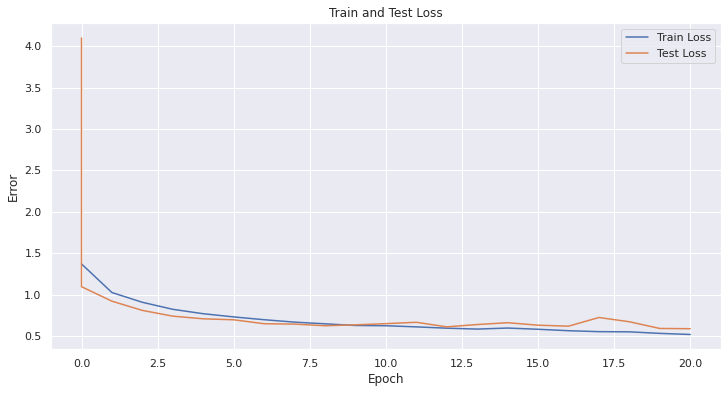

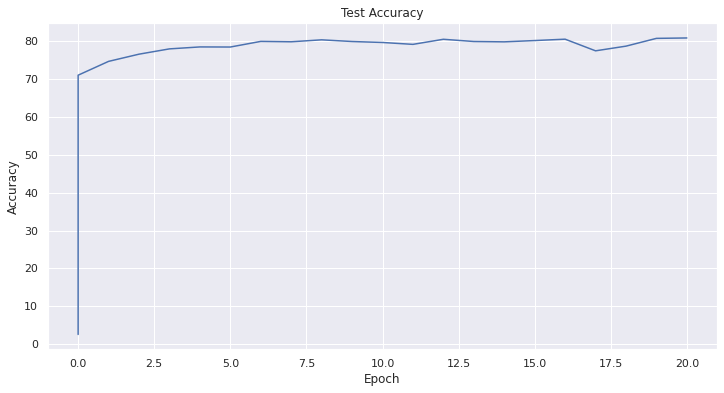

In [15]:
hi_gru_model, hi_en_voc2ind, hi_ind2voc, hi_seq_len, _ = main('hi', 'gru')

Using device cpu
num workers: 48
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['क', 'ह', 'र', 'र', 'र', 'र', 'र', 'र', 'र', 'र', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['क', 'ह', 'र', 'र', 'र', 'र', 'र', 'र', 'र', 'र', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['क', 'ह', 'र', 'र', 'र', 'र', 'र', 'र', 'र', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ', 'भ']



Test set: Average loss: 4.1472, Accuracy: 2113/119035 (2%)



  3%|▎         | 2/61 [00:00<00:10,  5.83it/s]

Train Epoch: 0 [0/31587 (0%)]	Loss: 4.143219


 20%|█▉        | 12/61 [00:01<00:07,  6.55it/s]

Train Epoch: 0 [5120/31587 (16%)]	Loss: 1.321977


 36%|███▌      | 22/61 [00:03<00:05,  7.23it/s]

Train Epoch: 0 [10240/31587 (33%)]	Loss: 1.172121


 52%|█████▏    | 32/61 [00:04<00:04,  6.94it/s]

Train Epoch: 0 [15360/31587 (49%)]	Loss: 1.385861


 69%|██████▉   | 42/61 [00:06<00:02,  6.88it/s]

Train Epoch: 0 [20480/31587 (66%)]	Loss: 1.387463


 85%|████████▌ | 52/61 [00:07<00:01,  6.93it/s]

Train Epoch: 0 [25600/31587 (82%)]	Loss: 1.249944


100%|██████████| 61/61 [00:08<00:00,  6.91it/s]


Train Epoch: 0 [30720/31587 (98%)]	Loss: 1.225196
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['ा', 'ा', 'र', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['र', 'ा', 'ि', 'ि', 'ि']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['र', 'ा', '्', 'ि', 'ि']



Test set: Average loss: 1.1813, Accuracy: 82470/119035 (69%)



  3%|▎         | 2/61 [00:00<00:07,  7.62it/s]

Train Epoch: 1 [0/31587 (0%)]	Loss: 1.443450


 20%|█▉        | 12/61 [00:01<00:06,  7.06it/s]

Train Epoch: 1 [5120/31587 (16%)]	Loss: 1.162752


 36%|███▌      | 22/61 [00:03<00:05,  7.30it/s]

Train Epoch: 1 [10240/31587 (33%)]	Loss: 1.060103


 52%|█████▏    | 32/61 [00:04<00:03,  7.27it/s]

Train Epoch: 1 [15360/31587 (49%)]	Loss: 1.348741


 69%|██████▉   | 42/61 [00:05<00:02,  7.32it/s]

Train Epoch: 1 [20480/31587 (66%)]	Loss: 1.302495


 85%|████████▌ | 52/61 [00:07<00:01,  7.07it/s]

Train Epoch: 1 [25600/31587 (82%)]	Loss: 1.003771


100%|██████████| 61/61 [00:08<00:00,  7.24it/s]


Train Epoch: 1 [30720/31587 (98%)]	Loss: 1.114708
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['न', 'न', 'क', 'ा', 'न']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ल', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['व', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 1.1080, Accuracy: 84406/119035 (71%)



  3%|▎         | 2/61 [00:00<00:08,  7.07it/s]

Train Epoch: 2 [0/31587 (0%)]	Loss: 1.243548


 20%|█▉        | 12/61 [00:01<00:06,  7.26it/s]

Train Epoch: 2 [5120/31587 (16%)]	Loss: 0.944615


 36%|███▌      | 22/61 [00:03<00:05,  7.07it/s]

Train Epoch: 2 [10240/31587 (33%)]	Loss: 0.931305


 52%|█████▏    | 32/61 [00:04<00:04,  6.92it/s]

Train Epoch: 2 [15360/31587 (49%)]	Loss: 1.209198


 69%|██████▉   | 42/61 [00:05<00:02,  7.18it/s]

Train Epoch: 2 [20480/31587 (66%)]	Loss: 1.225275


 85%|████████▌ | 52/61 [00:07<00:01,  7.08it/s]

Train Epoch: 2 [25600/31587 (82%)]	Loss: 0.800999


100%|██████████| 61/61 [00:08<00:00,  7.04it/s]


Train Epoch: 2 [30720/31587 (98%)]	Loss: 1.054194
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['न', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ज', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 1.0478, Accuracy: 85855/119035 (72%)



  3%|▎         | 2/61 [00:00<00:08,  6.93it/s]

Train Epoch: 3 [0/31587 (0%)]	Loss: 1.084998


 20%|█▉        | 12/61 [00:01<00:06,  7.27it/s]

Train Epoch: 3 [5120/31587 (16%)]	Loss: 0.886179


 36%|███▌      | 22/61 [00:03<00:05,  7.31it/s]

Train Epoch: 3 [10240/31587 (33%)]	Loss: 0.821307


 52%|█████▏    | 32/61 [00:04<00:03,  7.27it/s]

Train Epoch: 3 [15360/31587 (49%)]	Loss: 1.135072


 69%|██████▉   | 42/61 [00:05<00:02,  7.21it/s]

Train Epoch: 3 [20480/31587 (66%)]	Loss: 1.166661


 85%|████████▌ | 52/61 [00:07<00:01,  7.15it/s]

Train Epoch: 3 [25600/31587 (82%)]	Loss: 0.727326


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


Train Epoch: 3 [30720/31587 (98%)]	Loss: 0.991080
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ज', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'ं']



Test set: Average loss: 0.9913, Accuracy: 86678/119035 (73%)



  3%|▎         | 2/61 [00:00<00:08,  7.00it/s]

Train Epoch: 4 [0/31587 (0%)]	Loss: 0.993385


 20%|█▉        | 12/61 [00:01<00:06,  7.35it/s]

Train Epoch: 4 [5120/31587 (16%)]	Loss: 0.818498


 36%|███▌      | 22/61 [00:03<00:06,  6.34it/s]

Train Epoch: 4 [10240/31587 (33%)]	Loss: 0.770568


 52%|█████▏    | 32/61 [00:04<00:03,  7.26it/s]

Train Epoch: 4 [15360/31587 (49%)]	Loss: 1.096103


 69%|██████▉   | 42/61 [00:06<00:02,  6.62it/s]

Train Epoch: 4 [20480/31587 (66%)]	Loss: 1.147962


 85%|████████▌ | 52/61 [00:07<00:01,  6.54it/s]

Train Epoch: 4 [25600/31587 (82%)]	Loss: 0.700212


100%|██████████| 61/61 [00:08<00:00,  6.86it/s]


Train Epoch: 4 [30720/31587 (98%)]	Loss: 0.951724
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ज', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'ं']



Test set: Average loss: 0.9670, Accuracy: 88022/119035 (74%)



  3%|▎         | 2/61 [00:00<00:08,  7.21it/s]

Train Epoch: 5 [0/31587 (0%)]	Loss: 0.935082


 20%|█▉        | 12/61 [00:01<00:06,  7.12it/s]

Train Epoch: 5 [5120/31587 (16%)]	Loss: 0.794233


 36%|███▌      | 22/61 [00:03<00:05,  7.19it/s]

Train Epoch: 5 [10240/31587 (33%)]	Loss: 0.710307


 52%|█████▏    | 32/61 [00:04<00:04,  7.12it/s]

Train Epoch: 5 [15360/31587 (49%)]	Loss: 1.103135


 69%|██████▉   | 42/61 [00:05<00:03,  6.26it/s]

Train Epoch: 5 [20480/31587 (66%)]	Loss: 1.106803


 85%|████████▌ | 52/61 [00:07<00:01,  6.64it/s]

Train Epoch: 5 [25600/31587 (82%)]	Loss: 0.677637


100%|██████████| 61/61 [00:08<00:00,  7.02it/s]


Train Epoch: 5 [30720/31587 (98%)]	Loss: 0.886920
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ज', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'ं']



Test set: Average loss: 0.9510, Accuracy: 88541/119035 (74%)



  3%|▎         | 2/61 [00:00<00:08,  7.26it/s]

Train Epoch: 6 [0/31587 (0%)]	Loss: 0.895173


 20%|█▉        | 12/61 [00:01<00:07,  6.94it/s]

Train Epoch: 6 [5120/31587 (16%)]	Loss: 0.769483


 36%|███▌      | 22/61 [00:03<00:05,  6.79it/s]

Train Epoch: 6 [10240/31587 (33%)]	Loss: 0.697399


 52%|█████▏    | 32/61 [00:04<00:04,  7.03it/s]

Train Epoch: 6 [15360/31587 (49%)]	Loss: 1.086961


 69%|██████▉   | 42/61 [00:06<00:02,  7.27it/s]

Train Epoch: 6 [20480/31587 (66%)]	Loss: 1.091974


 85%|████████▌ | 52/61 [00:07<00:01,  7.29it/s]

Train Epoch: 6 [25600/31587 (82%)]	Loss: 0.662558


100%|██████████| 61/61 [00:08<00:00,  7.02it/s]


Train Epoch: 6 [30720/31587 (98%)]	Loss: 0.868238
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['आ', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 0.9335, Accuracy: 89278/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.05it/s]

Train Epoch: 7 [0/31587 (0%)]	Loss: 0.904915


 20%|█▉        | 12/61 [00:01<00:06,  7.35it/s]

Train Epoch: 7 [5120/31587 (16%)]	Loss: 0.764308


 36%|███▌      | 22/61 [00:03<00:05,  6.70it/s]

Train Epoch: 7 [10240/31587 (33%)]	Loss: 0.687178


 52%|█████▏    | 32/61 [00:04<00:04,  7.17it/s]

Train Epoch: 7 [15360/31587 (49%)]	Loss: 1.057074


 69%|██████▉   | 42/61 [00:05<00:02,  7.21it/s]

Train Epoch: 7 [20480/31587 (66%)]	Loss: 1.069085


 85%|████████▌ | 52/61 [00:07<00:01,  7.20it/s]

Train Epoch: 7 [25600/31587 (82%)]	Loss: 0.653526


100%|██████████| 61/61 [00:08<00:00,  7.12it/s]


Train Epoch: 7 [30720/31587 (98%)]	Loss: 0.835378
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['इ', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ी', 'न']



Test set: Average loss: 0.9276, Accuracy: 89172/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.31it/s]

Train Epoch: 8 [0/31587 (0%)]	Loss: 0.877914


 20%|█▉        | 12/61 [00:01<00:06,  7.17it/s]

Train Epoch: 8 [5120/31587 (16%)]	Loss: 0.754936


 36%|███▌      | 22/61 [00:03<00:05,  7.39it/s]

Train Epoch: 8 [10240/31587 (33%)]	Loss: 0.667883


 52%|█████▏    | 32/61 [00:04<00:04,  7.02it/s]

Train Epoch: 8 [15360/31587 (49%)]	Loss: 1.024747


 69%|██████▉   | 42/61 [00:05<00:02,  7.14it/s]

Train Epoch: 8 [20480/31587 (66%)]	Loss: 1.060178


 85%|████████▌ | 52/61 [00:07<00:01,  7.16it/s]

Train Epoch: 8 [25600/31587 (82%)]	Loss: 0.634545


100%|██████████| 61/61 [00:08<00:00,  7.13it/s]


Train Epoch: 8 [30720/31587 (98%)]	Loss: 0.782033
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['इ', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['फ', 'ा', 'स', 'ी', 'न']



Test set: Average loss: 0.9232, Accuracy: 89229/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.29it/s]

Train Epoch: 9 [0/31587 (0%)]	Loss: 0.818456


 20%|█▉        | 12/61 [00:01<00:06,  7.15it/s]

Train Epoch: 9 [5120/31587 (16%)]	Loss: 0.726841


 36%|███▌      | 22/61 [00:03<00:05,  6.52it/s]

Train Epoch: 9 [10240/31587 (33%)]	Loss: 0.641169


 52%|█████▏    | 32/61 [00:04<00:04,  6.68it/s]

Train Epoch: 9 [15360/31587 (49%)]	Loss: 0.989734


 69%|██████▉   | 42/61 [00:06<00:02,  7.15it/s]

Train Epoch: 9 [20480/31587 (66%)]	Loss: 1.027534


 84%|████████▎ | 51/61 [00:07<00:01,  6.35it/s]

Train Epoch: 9 [25600/31587 (82%)]	Loss: 0.618723


100%|██████████| 61/61 [00:09<00:00,  6.65it/s]


Train Epoch: 9 [30720/31587 (98%)]	Loss: 0.750263
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['आ', 'ा', 'ा', 'न', 'ि', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['फ', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 0.9086, Accuracy: 89132/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.29it/s]

Train Epoch: 10 [0/31587 (0%)]	Loss: 0.781155


 20%|█▉        | 12/61 [00:01<00:06,  7.17it/s]

Train Epoch: 10 [5120/31587 (16%)]	Loss: 0.713724


 36%|███▌      | 22/61 [00:03<00:05,  7.36it/s]

Train Epoch: 10 [10240/31587 (33%)]	Loss: 0.619942


 52%|█████▏    | 32/61 [00:04<00:04,  6.73it/s]

Train Epoch: 10 [15360/31587 (49%)]	Loss: 0.960767


 69%|██████▉   | 42/61 [00:05<00:02,  6.81it/s]

Train Epoch: 10 [20480/31587 (66%)]	Loss: 1.006056


 85%|████████▌ | 52/61 [00:07<00:01,  7.13it/s]

Train Epoch: 10 [25600/31587 (82%)]	Loss: 0.598321


100%|██████████| 61/61 [00:08<00:00,  7.15it/s]


Train Epoch: 10 [30720/31587 (98%)]	Loss: 0.725568
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['आ', 'य', 'ा', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['फ', 'ा', 'स', 'ी', 'न']



Test set: Average loss: 0.9213, Accuracy: 88880/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.15it/s]

Train Epoch: 11 [0/31587 (0%)]	Loss: 0.761792


 20%|█▉        | 12/61 [00:01<00:07,  6.79it/s]

Train Epoch: 11 [5120/31587 (16%)]	Loss: 0.716569


 36%|███▌      | 22/61 [00:03<00:05,  6.52it/s]

Train Epoch: 11 [10240/31587 (33%)]	Loss: 0.595862


 52%|█████▏    | 32/61 [00:04<00:04,  6.85it/s]

Train Epoch: 11 [15360/31587 (49%)]	Loss: 0.929224


 69%|██████▉   | 42/61 [00:06<00:02,  6.93it/s]

Train Epoch: 11 [20480/31587 (66%)]	Loss: 0.970890


 85%|████████▌ | 52/61 [00:07<00:01,  7.08it/s]

Train Epoch: 11 [25600/31587 (82%)]	Loss: 0.580363


100%|██████████| 61/61 [00:08<00:00,  6.91it/s]


Train Epoch: 11 [30720/31587 (98%)]	Loss: 0.711324
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['य', 'ा', 'ा', 'न', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 0.9073, Accuracy: 89222/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.11it/s]

Train Epoch: 12 [0/31587 (0%)]	Loss: 0.746303


 20%|█▉        | 12/61 [00:01<00:07,  6.99it/s]

Train Epoch: 12 [5120/31587 (16%)]	Loss: 0.690609


 36%|███▌      | 22/61 [00:03<00:05,  6.69it/s]

Train Epoch: 12 [10240/31587 (33%)]	Loss: 0.588268


 52%|█████▏    | 32/61 [00:04<00:04,  7.07it/s]

Train Epoch: 12 [15360/31587 (49%)]	Loss: 0.930616


 69%|██████▉   | 42/61 [00:06<00:02,  7.30it/s]

Train Epoch: 12 [20480/31587 (66%)]	Loss: 0.949712


 85%|████████▌ | 52/61 [00:07<00:01,  7.32it/s]

Train Epoch: 12 [25600/31587 (82%)]	Loss: 0.559939


100%|██████████| 61/61 [00:08<00:00,  7.08it/s]


Train Epoch: 12 [30720/31587 (98%)]	Loss: 0.705955
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा', 'ं']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['य', 'ा', 'ा', 'ा', 'ी', 'य']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ग', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 0.9144, Accuracy: 89106/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.16it/s]

Train Epoch: 13 [0/31587 (0%)]	Loss: 0.755299


 20%|█▉        | 12/61 [00:01<00:06,  7.26it/s]

Train Epoch: 13 [5120/31587 (16%)]	Loss: 0.680073


 36%|███▌      | 22/61 [00:03<00:05,  7.28it/s]

Train Epoch: 13 [10240/31587 (33%)]	Loss: 0.587062


 52%|█████▏    | 32/61 [00:04<00:03,  7.34it/s]

Train Epoch: 13 [15360/31587 (49%)]	Loss: 0.884845


 69%|██████▉   | 42/61 [00:05<00:02,  7.27it/s]

Train Epoch: 13 [20480/31587 (66%)]	Loss: 0.914698


 85%|████████▌ | 52/61 [00:07<00:01,  7.19it/s]

Train Epoch: 13 [25600/31587 (82%)]	Loss: 0.555579


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


Train Epoch: 13 [30720/31587 (98%)]	Loss: 0.668289
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा', 'न']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ह', 'ा', 'ा', 'ा', 'ी']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ग', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 0.9298, Accuracy: 89135/119035 (75%)



  3%|▎         | 2/61 [00:00<00:07,  7.47it/s]

Train Epoch: 14 [0/31587 (0%)]	Loss: 0.730727


 20%|█▉        | 12/61 [00:01<00:07,  6.84it/s]

Train Epoch: 14 [5120/31587 (16%)]	Loss: 0.677531


 36%|███▌      | 22/61 [00:03<00:05,  6.59it/s]

Train Epoch: 14 [10240/31587 (33%)]	Loss: 0.570844


 52%|█████▏    | 32/61 [00:04<00:04,  6.83it/s]

Train Epoch: 14 [15360/31587 (49%)]	Loss: 0.917494


 69%|██████▉   | 42/61 [00:06<00:02,  7.21it/s]

Train Epoch: 14 [20480/31587 (66%)]	Loss: 0.902672


 85%|████████▌ | 52/61 [00:07<00:01,  7.02it/s]

Train Epoch: 14 [25600/31587 (82%)]	Loss: 0.557724


100%|██████████| 61/61 [00:08<00:00,  6.91it/s]


Train Epoch: 14 [30720/31587 (98%)]	Loss: 0.665128
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['य', 'ा', 'ा', 'न']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['य', 'ा', 'स', 'ि', 'न']



Test set: Average loss: 0.9551, Accuracy: 88887/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.20it/s]

Train Epoch: 15 [0/31587 (0%)]	Loss: 0.732990


 20%|█▉        | 12/61 [00:01<00:06,  7.29it/s]

Train Epoch: 15 [5120/31587 (16%)]	Loss: 0.674764


 36%|███▌      | 22/61 [00:02<00:05,  7.38it/s]

Train Epoch: 15 [10240/31587 (33%)]	Loss: 0.536199


 52%|█████▏    | 32/61 [00:04<00:04,  6.76it/s]

Train Epoch: 15 [15360/31587 (49%)]	Loss: 0.861036


 69%|██████▉   | 42/61 [00:05<00:02,  7.09it/s]

Train Epoch: 15 [20480/31587 (66%)]	Loss: 0.883034


 85%|████████▌ | 52/61 [00:07<00:01,  7.31it/s]

Train Epoch: 15 [25600/31587 (82%)]	Loss: 0.536641


100%|██████████| 61/61 [00:08<00:00,  7.11it/s]


Train Epoch: 15 [30720/31587 (98%)]	Loss: 0.632074
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'ं', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ह', 'ा', 'ह', 'न']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स']



Test set: Average loss: 0.9220, Accuracy: 89165/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  7.25it/s]

Train Epoch: 16 [0/31587 (0%)]	Loss: 0.669490


 20%|█▉        | 12/61 [00:01<00:06,  7.33it/s]

Train Epoch: 16 [5120/31587 (16%)]	Loss: 0.631593


 36%|███▌      | 22/61 [00:03<00:05,  7.35it/s]

Train Epoch: 16 [10240/31587 (33%)]	Loss: 0.529751


 52%|█████▏    | 32/61 [00:04<00:04,  6.80it/s]

Train Epoch: 16 [15360/31587 (49%)]	Loss: 0.864045


 69%|██████▉   | 42/61 [00:05<00:02,  6.85it/s]

Train Epoch: 16 [20480/31587 (66%)]	Loss: 0.856336


 85%|████████▌ | 52/61 [00:07<00:01,  7.08it/s]

Train Epoch: 16 [25600/31587 (82%)]	Loss: 0.557814


100%|██████████| 61/61 [00:08<00:00,  7.10it/s]


Train Epoch: 16 [30720/31587 (98%)]	Loss: 0.641554
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा', 'न']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['आ', 'त', 'ह', 'ा']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ी']



Test set: Average loss: 0.9652, Accuracy: 88334/119035 (74%)



  3%|▎         | 2/61 [00:00<00:08,  7.36it/s]

Train Epoch: 17 [0/31587 (0%)]	Loss: 0.704445


 20%|█▉        | 12/61 [00:01<00:06,  7.02it/s]

Train Epoch: 17 [5120/31587 (16%)]	Loss: 0.638546


 36%|███▌      | 22/61 [00:03<00:05,  7.06it/s]

Train Epoch: 17 [10240/31587 (33%)]	Loss: 0.524322


 52%|█████▏    | 32/61 [00:04<00:04,  6.65it/s]

Train Epoch: 17 [15360/31587 (49%)]	Loss: 0.826184


 69%|██████▉   | 42/61 [00:06<00:02,  6.89it/s]

Train Epoch: 17 [20480/31587 (66%)]	Loss: 0.854114


 85%|████████▌ | 52/61 [00:07<00:01,  6.99it/s]

Train Epoch: 17 [25600/31587 (82%)]	Loss: 0.512816


100%|██████████| 61/61 [00:08<00:00,  7.00it/s]


Train Epoch: 17 [30720/31587 (98%)]	Loss: 0.619781
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा', 'ं']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['आ', 'ा', 'ह', 'ा']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ज', 'ा', 'स', 'ी']



Test set: Average loss: 0.9404, Accuracy: 89059/119035 (75%)



  3%|▎         | 2/61 [00:00<00:08,  6.94it/s]

Train Epoch: 18 [0/31587 (0%)]	Loss: 0.662418


 20%|█▉        | 12/61 [00:01<00:06,  7.09it/s]

Train Epoch: 18 [5120/31587 (16%)]	Loss: 0.645252


 36%|███▌      | 22/61 [00:03<00:05,  6.90it/s]

Train Epoch: 18 [10240/31587 (33%)]	Loss: 0.515694


 52%|█████▏    | 32/61 [00:04<00:04,  6.44it/s]

Train Epoch: 18 [15360/31587 (49%)]	Loss: 0.818723


 69%|██████▉   | 42/61 [00:06<00:02,  7.25it/s]

Train Epoch: 18 [20480/31587 (66%)]	Loss: 0.826285


 85%|████████▌ | 52/61 [00:07<00:01,  7.12it/s]

Train Epoch: 18 [25600/31587 (82%)]	Loss: 0.535375


100%|██████████| 61/61 [00:08<00:00,  6.91it/s]


Train Epoch: 18 [30720/31587 (98%)]	Loss: 0.646827
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['आ', 'ा', 'ा']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ग', 'ा', 'स', 'ी']



Test set: Average loss: 0.9893, Accuracy: 88468/119035 (74%)



  3%|▎         | 2/61 [00:00<00:08,  7.25it/s]

Train Epoch: 19 [0/31587 (0%)]	Loss: 0.740125


 20%|█▉        | 12/61 [00:01<00:07,  6.89it/s]

Train Epoch: 19 [5120/31587 (16%)]	Loss: 0.627865


 36%|███▌      | 22/61 [00:03<00:05,  7.18it/s]

Train Epoch: 19 [10240/31587 (33%)]	Loss: 0.510186


 52%|█████▏    | 32/61 [00:04<00:03,  7.32it/s]

Train Epoch: 19 [15360/31587 (49%)]	Loss: 0.802924


 69%|██████▉   | 42/61 [00:06<00:02,  7.10it/s]

Train Epoch: 19 [20480/31587 (66%)]	Loss: 0.822850


 85%|████████▌ | 52/61 [00:07<00:01,  7.19it/s]

Train Epoch: 19 [25600/31587 (82%)]	Loss: 0.488516


100%|██████████| 61/61 [00:08<00:00,  7.06it/s]


Train Epoch: 19 [30720/31587 (98%)]	Loss: 0.615700
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['अ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['ए', 'य', 'ह']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ी']



Test set: Average loss: 1.0828, Accuracy: 87090/119035 (73%)



  3%|▎         | 2/61 [00:00<00:08,  7.03it/s]

Train Epoch: 20 [0/31587 (0%)]	Loss: 0.692555


 20%|█▉        | 12/61 [00:01<00:06,  7.05it/s]

Train Epoch: 20 [5120/31587 (16%)]	Loss: 0.617531


 36%|███▌      | 22/61 [00:03<00:05,  7.18it/s]

Train Epoch: 20 [10240/31587 (33%)]	Loss: 0.500342


 52%|█████▏    | 32/61 [00:04<00:04,  7.09it/s]

Train Epoch: 20 [15360/31587 (49%)]	Loss: 0.792287


 69%|██████▉   | 42/61 [00:05<00:02,  7.33it/s]

Train Epoch: 20 [20480/31587 (66%)]	Loss: 0.803232


 85%|████████▌ | 52/61 [00:07<00:01,  7.09it/s]

Train Epoch: 20 [25600/31587 (82%)]	Loss: 0.481320


100%|██████████| 61/61 [00:08<00:00,  7.07it/s]


Train Epoch: 20 [30720/31587 (98%)]	Loss: 0.575584
Input	['a', 'n', 'k', 'a', 'n']
GT	['अ', 'ं', 'क', 'न']
pred	['आ', 'न', 'क', 'ा']


Input	['w', 'a', 'h', 'n', 'i', 'y']
GT	['व', 'ह', 'न', 'ी', 'य']
pred	['आ', 'ा', 'ह']


Input	['b', 'a', 's', 'i', 'n']
GT	['ब', 'े', 'स', 'ि', 'न']
pred	['ब', 'ा', 'स', 'ी']



Test set: Average loss: 1.0424, Accuracy: 88033/119035 (74%)



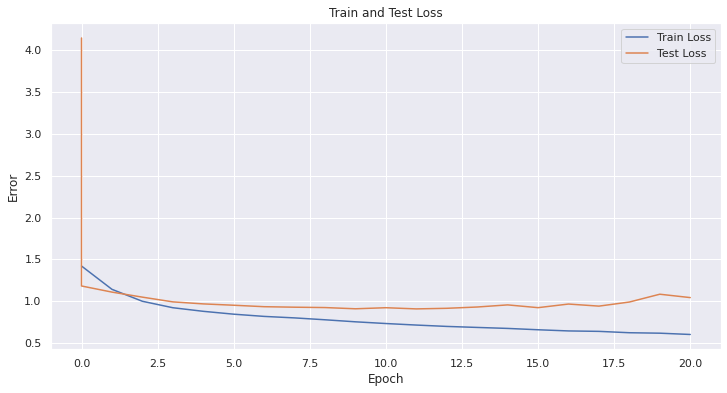

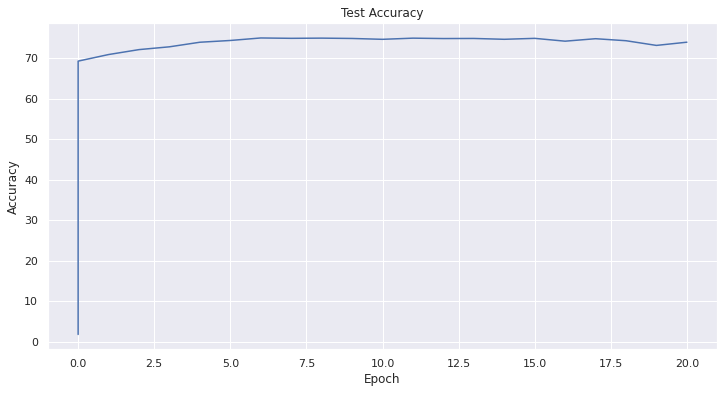

In [16]:
hi_lstm_model, _, _, _, _ = main('hi', 'lstm')

Using device cpu
num workers: 48
Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ർ', 'ു', 'െ', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['ർ', 'ു', 'ു', 'ക', 'ക', 'ക', 'ആ', 'ു', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ർ', 'െ', 'െ', 'ഗ', 'ഗ', 'ു', 'ു', 'ു', 'ദ', 'ു', 'ു', 'ു', 'ു', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ', 'ഃ']



Test set: Average loss: 4.2312, Accuracy: 1583/228544 (1%)



  1%|▏         | 1/70 [00:00<00:12,  5.36it/s]

Train Epoch: 0 [0/35947 (0%)]	Loss: 4.227129


 16%|█▌        | 11/70 [00:02<00:12,  4.91it/s]

Train Epoch: 0 [5120/35947 (14%)]	Loss: 1.177303


 31%|███▏      | 22/70 [00:04<00:08,  5.43it/s]

Train Epoch: 0 [10240/35947 (29%)]	Loss: 0.985826


 44%|████▍     | 31/70 [00:06<00:08,  4.49it/s]

Train Epoch: 0 [15360/35947 (43%)]	Loss: 1.073112


 60%|██████    | 42/70 [00:08<00:05,  5.00it/s]

Train Epoch: 0 [20480/35947 (57%)]	Loss: 0.952294


 74%|███████▍  | 52/70 [00:10<00:03,  5.34it/s]

Train Epoch: 0 [25600/35947 (71%)]	Loss: 1.036704


 89%|████████▊ | 62/70 [00:12<00:01,  5.45it/s]

Train Epoch: 0 [30720/35947 (86%)]	Loss: 1.020675


100%|██████████| 70/70 [00:13<00:00,  5.15it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['സ', 'സ', 'സ', 'ാ', '്', '്', '്', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', 'ന', 'ന', 'ി', 'ന', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['വ', '്', 'വ', '്', '്', 'ാ', 'ാ', 'പ', 'പ', '്', '്']



Test set: Average loss: 0.9740, Accuracy: 167991/228544 (74%)



  1%|▏         | 1/70 [00:00<00:12,  5.41it/s]

Train Epoch: 1 [0/35947 (0%)]	Loss: 1.113323


 17%|█▋        | 12/70 [00:02<00:10,  5.30it/s]

Train Epoch: 1 [5120/35947 (14%)]	Loss: 0.992210


 30%|███       | 21/70 [00:03<00:09,  5.24it/s]

Train Epoch: 1 [10240/35947 (29%)]	Loss: 0.778047


 44%|████▍     | 31/70 [00:05<00:07,  4.92it/s]

Train Epoch: 1 [15360/35947 (43%)]	Loss: 1.005910


 60%|██████    | 42/70 [00:08<00:05,  5.29it/s]

Train Epoch: 1 [20480/35947 (57%)]	Loss: 0.782895


 74%|███████▍  | 52/70 [00:09<00:03,  5.26it/s]

Train Epoch: 1 [25600/35947 (71%)]	Loss: 0.843782


 87%|████████▋ | 61/70 [00:11<00:01,  5.17it/s]

Train Epoch: 1 [30720/35947 (86%)]	Loss: 0.810533


100%|██████████| 70/70 [00:13<00:00,  5.20it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ബ', 'ാ', '്', 'ാ', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', '്', 'ി', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ീ', '്', '്', '്']



Test set: Average loss: 0.8285, Accuracy: 172735/228544 (76%)



  1%|▏         | 1/70 [00:00<00:12,  5.38it/s]

Train Epoch: 2 [0/35947 (0%)]	Loss: 0.894693


 17%|█▋        | 12/70 [00:02<00:10,  5.29it/s]

Train Epoch: 2 [5120/35947 (14%)]	Loss: 0.902290


 30%|███       | 21/70 [00:04<00:09,  4.98it/s]

Train Epoch: 2 [10240/35947 (29%)]	Loss: 0.682833


 46%|████▌     | 32/70 [00:06<00:07,  5.20it/s]

Train Epoch: 2 [15360/35947 (43%)]	Loss: 0.943956


 60%|██████    | 42/70 [00:08<00:05,  5.38it/s]

Train Epoch: 2 [20480/35947 (57%)]	Loss: 0.711248


 74%|███████▍  | 52/70 [00:09<00:03,  5.38it/s]

Train Epoch: 2 [25600/35947 (71%)]	Loss: 0.781755


 89%|████████▊ | 62/70 [00:11<00:01,  5.42it/s]

Train Epoch: 2 [30720/35947 (86%)]	Loss: 0.742962


100%|██████████| 70/70 [00:13<00:00,  5.26it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', '്', '്', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', '്', 'ി', 'ന', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ീ', 'ന', 'ങ', 'ങ']



Test set: Average loss: 0.7546, Accuracy: 175484/228544 (77%)



  1%|▏         | 1/70 [00:00<00:13,  5.29it/s]

Train Epoch: 3 [0/35947 (0%)]	Loss: 0.781777


 16%|█▌        | 11/70 [00:02<00:10,  5.37it/s]

Train Epoch: 3 [5120/35947 (14%)]	Loss: 0.854704


 31%|███▏      | 22/70 [00:04<00:09,  5.17it/s]

Train Epoch: 3 [10240/35947 (29%)]	Loss: 0.614244


 46%|████▌     | 32/70 [00:06<00:07,  5.41it/s]

Train Epoch: 3 [15360/35947 (43%)]	Loss: 0.896668


 60%|██████    | 42/70 [00:07<00:05,  5.28it/s]

Train Epoch: 3 [20480/35947 (57%)]	Loss: 0.677328


 74%|███████▍  | 52/70 [00:09<00:03,  5.34it/s]

Train Epoch: 3 [25600/35947 (71%)]	Loss: 0.757241


 89%|████████▊ | 62/70 [00:11<00:01,  5.32it/s]

Train Epoch: 3 [30720/35947 (86%)]	Loss: 0.720276


100%|██████████| 70/70 [00:13<00:00,  5.29it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'ം', '്', '്', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', 'ഗ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ക', '്', 'ങ', 'ങ']



Test set: Average loss: 0.7160, Accuracy: 176932/228544 (77%)



  1%|▏         | 1/70 [00:00<00:12,  5.39it/s]

Train Epoch: 4 [0/35947 (0%)]	Loss: 0.749995


 16%|█▌        | 11/70 [00:02<00:10,  5.47it/s]

Train Epoch: 4 [5120/35947 (14%)]	Loss: 0.800954


 31%|███▏      | 22/70 [00:04<00:09,  5.27it/s]

Train Epoch: 4 [10240/35947 (29%)]	Loss: 0.574035


 46%|████▌     | 32/70 [00:06<00:07,  5.30it/s]

Train Epoch: 4 [15360/35947 (43%)]	Loss: 0.845013


 60%|██████    | 42/70 [00:07<00:05,  5.30it/s]

Train Epoch: 4 [20480/35947 (57%)]	Loss: 0.631030


 74%|███████▍  | 52/70 [00:09<00:03,  5.22it/s]

Train Epoch: 4 [25600/35947 (71%)]	Loss: 0.735944


 89%|████████▊ | 62/70 [00:11<00:01,  5.28it/s]

Train Epoch: 4 [30720/35947 (86%)]	Loss: 0.674187


100%|██████████| 70/70 [00:13<00:00,  5.21it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', 'ഗ', 'ഗ', '്', 'ത', '്', 'ു', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', 'ഗ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ക', '്', 'ങ', 'ങ', 'ൾ', 'പ', '്', 'ൾ']



Test set: Average loss: 0.6776, Accuracy: 178934/228544 (78%)



  1%|▏         | 1/70 [00:00<00:13,  5.22it/s]

Train Epoch: 5 [0/35947 (0%)]	Loss: 0.681872


 17%|█▋        | 12/70 [00:02<00:10,  5.37it/s]

Train Epoch: 5 [5120/35947 (14%)]	Loss: 0.726929


 31%|███▏      | 22/70 [00:04<00:08,  5.45it/s]

Train Epoch: 5 [10240/35947 (29%)]	Loss: 0.513059


 46%|████▌     | 32/70 [00:06<00:07,  5.24it/s]

Train Epoch: 5 [15360/35947 (43%)]	Loss: 0.794600


 60%|██████    | 42/70 [00:08<00:05,  5.16it/s]

Train Epoch: 5 [20480/35947 (57%)]	Loss: 0.605233


 73%|███████▎  | 51/70 [00:09<00:03,  4.95it/s]

Train Epoch: 5 [25600/35947 (71%)]	Loss: 0.710103


 87%|████████▋ | 61/70 [00:11<00:01,  5.03it/s]

Train Epoch: 5 [30720/35947 (86%)]	Loss: 0.592847


100%|██████████| 70/70 [00:13<00:00,  5.19it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'ം', 'ഗ', 'ത', 'ത', 'ത', 'ത', 'ു', '്', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ക', '്', 'ങ', 'ൾ', 'ൾ', 'പ', 'പ', 'ൾ', 'ൾ']



Test set: Average loss: 0.6655, Accuracy: 180174/228544 (79%)



  1%|▏         | 1/70 [00:00<00:12,  5.45it/s]

Train Epoch: 6 [0/35947 (0%)]	Loss: 0.668742


 17%|█▋        | 12/70 [00:02<00:11,  5.18it/s]

Train Epoch: 6 [5120/35947 (14%)]	Loss: 0.706512


 31%|███▏      | 22/70 [00:04<00:08,  5.40it/s]

Train Epoch: 6 [10240/35947 (29%)]	Loss: 0.479436


 46%|████▌     | 32/70 [00:06<00:07,  5.31it/s]

Train Epoch: 6 [15360/35947 (43%)]	Loss: 0.744514


 60%|██████    | 42/70 [00:08<00:05,  5.13it/s]

Train Epoch: 6 [20480/35947 (57%)]	Loss: 0.563708


 74%|███████▍  | 52/70 [00:09<00:03,  5.26it/s]

Train Epoch: 6 [25600/35947 (71%)]	Loss: 0.696644


 89%|████████▊ | 62/70 [00:11<00:01,  5.15it/s]

Train Epoch: 6 [30720/35947 (86%)]	Loss: 0.558261


100%|██████████| 70/70 [00:13<00:00,  5.25it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'ം', '്', '്', 'ത', 'ി', '്', '്', '്', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'െ', 'ക', '്', 'ങ', 'ങ', 'ക', '്', 'പ', 'ക', 'ൾ']



Test set: Average loss: 0.6379, Accuracy: 182257/228544 (80%)



  3%|▎         | 2/70 [00:00<00:13,  5.11it/s]

Train Epoch: 7 [0/35947 (0%)]	Loss: 0.616231


 17%|█▋        | 12/70 [00:02<00:10,  5.27it/s]

Train Epoch: 7 [5120/35947 (14%)]	Loss: 0.662260


 31%|███▏      | 22/70 [00:04<00:08,  5.37it/s]

Train Epoch: 7 [10240/35947 (29%)]	Loss: 0.461638


 46%|████▌     | 32/70 [00:06<00:08,  4.65it/s]

Train Epoch: 7 [15360/35947 (43%)]	Loss: 0.707753


 59%|█████▊    | 41/70 [00:08<00:05,  5.01it/s]

Train Epoch: 7 [20480/35947 (57%)]	Loss: 0.526283


 74%|███████▍  | 52/70 [00:10<00:03,  5.16it/s]

Train Epoch: 7 [25600/35947 (71%)]	Loss: 0.668361


 89%|████████▊ | 62/70 [00:12<00:01,  5.19it/s]

Train Epoch: 7 [30720/35947 (86%)]	Loss: 0.541329


100%|██████████| 70/70 [00:13<00:00,  5.03it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'ം', 'ഗ', 'ത', 'ത', 'ു', 'ം']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ക', '്', 'ങ', 'ങ', 'ങ', '്', 'പ', 'ങ', 'ങ']



Test set: Average loss: 0.6027, Accuracy: 184318/228544 (81%)



  1%|▏         | 1/70 [00:00<00:13,  5.13it/s]

Train Epoch: 8 [0/35947 (0%)]	Loss: 0.624894


 17%|█▋        | 12/70 [00:02<00:11,  5.15it/s]

Train Epoch: 8 [5120/35947 (14%)]	Loss: 0.633674


 31%|███▏      | 22/70 [00:04<00:08,  5.41it/s]

Train Epoch: 8 [10240/35947 (29%)]	Loss: 0.451988


 46%|████▌     | 32/70 [00:06<00:07,  5.38it/s]

Train Epoch: 8 [15360/35947 (43%)]	Loss: 0.680534


 60%|██████    | 42/70 [00:08<00:05,  5.00it/s]

Train Epoch: 8 [20480/35947 (57%)]	Loss: 0.501023


 74%|███████▍  | 52/70 [00:10<00:03,  5.37it/s]

Train Epoch: 8 [25600/35947 (71%)]	Loss: 0.647082


 89%|████████▊ | 62/70 [00:12<00:01,  5.31it/s]

Train Epoch: 8 [30720/35947 (86%)]	Loss: 0.515393


100%|██████████| 70/70 [00:13<00:00,  5.16it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'ം', 'ഗ', 'ത', 'ത', '്', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ു', 'ങ', '്', 'ങ', 'ള', 'ങ', 'െ', 'പ', 'ങ', 'ങ']



Test set: Average loss: 0.5929, Accuracy: 185363/228544 (81%)



  1%|▏         | 1/70 [00:00<00:12,  5.57it/s]

Train Epoch: 9 [0/35947 (0%)]	Loss: 0.567316


 17%|█▋        | 12/70 [00:02<00:10,  5.30it/s]

Train Epoch: 9 [5120/35947 (14%)]	Loss: 0.603434


 31%|███▏      | 22/70 [00:04<00:08,  5.37it/s]

Train Epoch: 9 [10240/35947 (29%)]	Loss: 0.434303


 46%|████▌     | 32/70 [00:05<00:07,  5.34it/s]

Train Epoch: 9 [15360/35947 (43%)]	Loss: 0.681549


 60%|██████    | 42/70 [00:07<00:05,  5.44it/s]

Train Epoch: 9 [20480/35947 (57%)]	Loss: 0.522649


 74%|███████▍  | 52/70 [00:09<00:03,  5.33it/s]

Train Epoch: 9 [25600/35947 (71%)]	Loss: 0.661496


 89%|████████▊ | 62/70 [00:11<00:01,  5.43it/s]

Train Epoch: 9 [30720/35947 (86%)]	Loss: 0.500692


100%|██████████| 70/70 [00:13<00:00,  5.34it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'ം', '്', '്', 'ത', 'ു', 'ു', 'ം']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ങ', 'ങ', 'ങ', 'ങ', 'ങ', '്', 'പ', 'ക', 'ൾ']



Test set: Average loss: 0.5905, Accuracy: 185292/228544 (81%)



  1%|▏         | 1/70 [00:00<00:12,  5.45it/s]

Train Epoch: 10 [0/35947 (0%)]	Loss: 0.613927


 17%|█▋        | 12/70 [00:02<00:11,  5.17it/s]

Train Epoch: 10 [5120/35947 (14%)]	Loss: 0.626246


 30%|███       | 21/70 [00:04<00:10,  4.56it/s]

Train Epoch: 10 [10240/35947 (29%)]	Loss: 0.420657


 44%|████▍     | 31/70 [00:06<00:07,  5.24it/s]

Train Epoch: 10 [15360/35947 (43%)]	Loss: 0.648711


 60%|██████    | 42/70 [00:08<00:05,  5.20it/s]

Train Epoch: 10 [20480/35947 (57%)]	Loss: 0.491013


 74%|███████▍  | 52/70 [00:10<00:03,  5.35it/s]

Train Epoch: 10 [25600/35947 (71%)]	Loss: 0.659596


 89%|████████▊ | 62/70 [00:12<00:01,  5.35it/s]

Train Epoch: 10 [30720/35947 (86%)]	Loss: 0.517877


100%|██████████| 70/70 [00:13<00:00,  5.15it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'ം', '്', 'ാ', 'ത', 'ി', 'ം', 'ം', 'ം']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ല', '്', 'ങ', 'ള', 'ള', 'ി', 'ട', 'ക', 'ക', '്']



Test set: Average loss: 0.6054, Accuracy: 184049/228544 (81%)



  1%|▏         | 1/70 [00:00<00:12,  5.39it/s]

Train Epoch: 11 [0/35947 (0%)]	Loss: 0.548974


 17%|█▋        | 12/70 [00:02<00:11,  5.17it/s]

Train Epoch: 11 [5120/35947 (14%)]	Loss: 0.587884


 31%|███▏      | 22/70 [00:04<00:09,  5.12it/s]

Train Epoch: 11 [10240/35947 (29%)]	Loss: 0.430654


 46%|████▌     | 32/70 [00:06<00:07,  5.26it/s]

Train Epoch: 11 [15360/35947 (43%)]	Loss: 0.641881


 59%|█████▊    | 41/70 [00:07<00:05,  5.13it/s]

Train Epoch: 11 [20480/35947 (57%)]	Loss: 0.479491


 74%|███████▍  | 52/70 [00:10<00:03,  4.97it/s]

Train Epoch: 11 [25600/35947 (71%)]	Loss: 0.615337


 89%|████████▊ | 62/70 [00:12<00:01,  5.06it/s]

Train Epoch: 11 [30720/35947 (86%)]	Loss: 0.486450


100%|██████████| 70/70 [00:13<00:00,  5.13it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', 'ഗ', 'ാ', 'ത', 'ാ', 'ാ', 'യ', 'യ', 'ു']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ള', 'ള', 'ല', 'ി', 'ട', 'ാ', 'ി']



Test set: Average loss: 0.5844, Accuracy: 185527/228544 (81%)



  1%|▏         | 1/70 [00:00<00:12,  5.40it/s]

Train Epoch: 12 [0/35947 (0%)]	Loss: 0.558923


 16%|█▌        | 11/70 [00:02<00:12,  4.89it/s]

Train Epoch: 12 [5120/35947 (14%)]	Loss: 0.555876


 30%|███       | 21/70 [00:04<00:10,  4.83it/s]

Train Epoch: 12 [10240/35947 (29%)]	Loss: 0.393659


 46%|████▌     | 32/70 [00:06<00:06,  5.54it/s]

Train Epoch: 12 [15360/35947 (43%)]	Loss: 0.620195


 60%|██████    | 42/70 [00:08<00:05,  5.40it/s]

Train Epoch: 12 [20480/35947 (57%)]	Loss: 0.463121


 73%|███████▎  | 51/70 [00:09<00:03,  5.29it/s]

Train Epoch: 12 [25600/35947 (71%)]	Loss: 0.603725


 89%|████████▊ | 62/70 [00:12<00:01,  5.31it/s]

Train Epoch: 12 [30720/35947 (86%)]	Loss: 0.467815


100%|██████████| 70/70 [00:13<00:00,  5.12it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ാ', 'ത', 'ു', 'ു', 'യ', 'ം']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ല', '്', 'ള', 'ാ', 'ി', '്', 'ട', 'ാ', 'ട', '്']



Test set: Average loss: 0.5877, Accuracy: 185578/228544 (81%)



  1%|▏         | 1/70 [00:00<00:12,  5.32it/s]

Train Epoch: 13 [0/35947 (0%)]	Loss: 0.518225


 17%|█▋        | 12/70 [00:02<00:11,  5.26it/s]

Train Epoch: 13 [5120/35947 (14%)]	Loss: 0.509887


 31%|███▏      | 22/70 [00:04<00:08,  5.37it/s]

Train Epoch: 13 [10240/35947 (29%)]	Loss: 0.379976


 44%|████▍     | 31/70 [00:05<00:08,  4.85it/s]

Train Epoch: 13 [15360/35947 (43%)]	Loss: 0.580117


 60%|██████    | 42/70 [00:08<00:05,  5.18it/s]

Train Epoch: 13 [20480/35947 (57%)]	Loss: 0.432200


 74%|███████▍  | 52/70 [00:10<00:03,  5.37it/s]

Train Epoch: 13 [25600/35947 (71%)]	Loss: 0.586178


 89%|████████▊ | 62/70 [00:11<00:01,  5.43it/s]

Train Epoch: 13 [30720/35947 (86%)]	Loss: 0.448960


100%|██████████| 70/70 [00:13<00:00,  5.19it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'ം', 'ഗ', 'ാ', 'ത', 'ു', 'ു', 'ു', 'ു']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്', 'ഗ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ല', '്', 'ങ', 'ള', 'ി', '്', 'ട', 'ാ', '്', '്']



Test set: Average loss: 0.5597, Accuracy: 186861/228544 (82%)



  1%|▏         | 1/70 [00:00<00:13,  5.30it/s]

Train Epoch: 14 [0/35947 (0%)]	Loss: 0.515029


 16%|█▌        | 11/70 [00:02<00:11,  5.30it/s]

Train Epoch: 14 [5120/35947 (14%)]	Loss: 0.537504


 31%|███▏      | 22/70 [00:04<00:09,  5.18it/s]

Train Epoch: 14 [10240/35947 (29%)]	Loss: 0.378422


 46%|████▌     | 32/70 [00:06<00:07,  5.17it/s]

Train Epoch: 14 [15360/35947 (43%)]	Loss: 0.598043


 60%|██████    | 42/70 [00:08<00:05,  5.33it/s]

Train Epoch: 14 [20480/35947 (57%)]	Loss: 0.437270


 73%|███████▎  | 51/70 [00:09<00:03,  5.01it/s]

Train Epoch: 14 [25600/35947 (71%)]	Loss: 0.596071


 89%|████████▊ | 62/70 [00:11<00:01,  5.27it/s]

Train Epoch: 14 [30720/35947 (86%)]	Loss: 0.430121


100%|██████████| 70/70 [00:13<00:00,  5.17it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ത', 'ത', 'ത', 'ത', 'ം', 'ം']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', 'ഗ', 'ഗ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ു', 'ക', '്', 'ങ', 'ള', 'ി', '്', 'ട']



Test set: Average loss: 0.5514, Accuracy: 187719/228544 (82%)



  3%|▎         | 2/70 [00:00<00:13,  4.94it/s]

Train Epoch: 15 [0/35947 (0%)]	Loss: 0.470160


 17%|█▋        | 12/70 [00:02<00:10,  5.32it/s]

Train Epoch: 15 [5120/35947 (14%)]	Loss: 0.502480


 31%|███▏      | 22/70 [00:04<00:09,  5.28it/s]

Train Epoch: 15 [10240/35947 (29%)]	Loss: 0.364361


 46%|████▌     | 32/70 [00:06<00:07,  5.22it/s]

Train Epoch: 15 [15360/35947 (43%)]	Loss: 0.557098


 60%|██████    | 42/70 [00:08<00:05,  5.47it/s]

Train Epoch: 15 [20480/35947 (57%)]	Loss: 0.437574


 74%|███████▍  | 52/70 [00:09<00:03,  5.23it/s]

Train Epoch: 15 [25600/35947 (71%)]	Loss: 0.571173


 89%|████████▊ | 62/70 [00:11<00:01,  5.11it/s]

Train Epoch: 15 [30720/35947 (86%)]	Loss: 0.412090


100%|██████████| 70/70 [00:13<00:00,  5.22it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', 'ഗ', 'ത', 'ത', 'ത', 'ാ', 'ു', 'ം']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', 'ഗ', 'ഗ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'റ', '്', 'ങ', 'ള', 'ക', '്', 'ട', 'ാ']



Test set: Average loss: 0.5606, Accuracy: 186461/228544 (82%)



  1%|▏         | 1/70 [00:00<00:12,  5.32it/s]

Train Epoch: 16 [0/35947 (0%)]	Loss: 0.467930


 17%|█▋        | 12/70 [00:02<00:11,  5.11it/s]

Train Epoch: 16 [5120/35947 (14%)]	Loss: 0.507668


 30%|███       | 21/70 [00:04<00:09,  5.19it/s]

Train Epoch: 16 [10240/35947 (29%)]	Loss: 0.351806


 46%|████▌     | 32/70 [00:06<00:07,  5.22it/s]

Train Epoch: 16 [15360/35947 (43%)]	Loss: 0.554861


 60%|██████    | 42/70 [00:08<00:05,  5.08it/s]

Train Epoch: 16 [20480/35947 (57%)]	Loss: 0.414270


 74%|███████▍  | 52/70 [00:10<00:03,  5.16it/s]

Train Epoch: 16 [25600/35947 (71%)]	Loss: 0.595492


 89%|████████▊ | 62/70 [00:11<00:01,  5.22it/s]

Train Epoch: 16 [30720/35947 (86%)]	Loss: 0.417200


100%|██████████| 70/70 [00:13<00:00,  5.18it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'ം', 'ഗ', 'ത', 'ത', '്', 'ു', 'ം', 'ു']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്', 'ഗ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ള', '്', 'ങ', 'ങ', 'ങ', '്', 'പ', '്', 'ൾ']



Test set: Average loss: 0.5698, Accuracy: 185844/228544 (81%)



  1%|▏         | 1/70 [00:00<00:12,  5.47it/s]

Train Epoch: 17 [0/35947 (0%)]	Loss: 0.449768


 17%|█▋        | 12/70 [00:02<00:11,  5.20it/s]

Train Epoch: 17 [5120/35947 (14%)]	Loss: 0.526251


 31%|███▏      | 22/70 [00:04<00:09,  5.03it/s]

Train Epoch: 17 [10240/35947 (29%)]	Loss: 0.368632


 46%|████▌     | 32/70 [00:06<00:07,  5.02it/s]

Train Epoch: 17 [15360/35947 (43%)]	Loss: 0.554868


 59%|█████▊    | 41/70 [00:07<00:05,  5.36it/s]

Train Epoch: 17 [20480/35947 (57%)]	Loss: 0.445614


 74%|███████▍  | 52/70 [00:10<00:03,  5.40it/s]

Train Epoch: 17 [25600/35947 (71%)]	Loss: 0.576798


 89%|████████▊ | 62/70 [00:11<00:01,  5.29it/s]

Train Epoch: 17 [30720/35947 (86%)]	Loss: 0.411239


100%|██████████| 70/70 [00:13<00:00,  5.20it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', 'ഗ', 'ത', 'ത', 'ത', 'ാ', 'ു', 'ു', 'ം']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', 'ൻ', 'ന', 'ി', 'ന', '്', 'ഗ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ങ', 'ങ', 'ങ', 'ങ', 'ങ', '്', 'പ', 'ങ']



Test set: Average loss: 0.5495, Accuracy: 187315/228544 (82%)



  1%|▏         | 1/70 [00:00<00:13,  5.18it/s]

Train Epoch: 18 [0/35947 (0%)]	Loss: 0.450973


 17%|█▋        | 12/70 [00:02<00:11,  5.11it/s]

Train Epoch: 18 [5120/35947 (14%)]	Loss: 0.483019


 31%|███▏      | 22/70 [00:04<00:09,  5.26it/s]

Train Epoch: 18 [10240/35947 (29%)]	Loss: 0.373679


 46%|████▌     | 32/70 [00:06<00:07,  5.41it/s]

Train Epoch: 18 [15360/35947 (43%)]	Loss: 0.554295


 60%|██████    | 42/70 [00:08<00:05,  5.33it/s]

Train Epoch: 18 [20480/35947 (57%)]	Loss: 0.405411


 74%|███████▍  | 52/70 [00:09<00:03,  5.32it/s]

Train Epoch: 18 [25600/35947 (71%)]	Loss: 0.574354


 89%|████████▊ | 62/70 [00:11<00:01,  5.50it/s]

Train Epoch: 18 [30720/35947 (86%)]	Loss: 0.422542


100%|██████████| 70/70 [00:13<00:00,  5.24it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'ം', 'ഗ', 'ാ', 'ത', '്', 'ു', 'ു', 'ു']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്', 'ഗ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ങ', '്', 'ങ', 'ൾ']



Test set: Average loss: 0.5563, Accuracy: 187402/228544 (82%)



  1%|▏         | 1/70 [00:00<00:13,  5.14it/s]

Train Epoch: 19 [0/35947 (0%)]	Loss: 0.418123


 17%|█▋        | 12/70 [00:02<00:10,  5.33it/s]

Train Epoch: 19 [5120/35947 (14%)]	Loss: 0.465412


 31%|███▏      | 22/70 [00:04<00:08,  5.43it/s]

Train Epoch: 19 [10240/35947 (29%)]	Loss: 0.343470


 46%|████▌     | 32/70 [00:06<00:07,  5.22it/s]

Train Epoch: 19 [15360/35947 (43%)]	Loss: 0.535897


 60%|██████    | 42/70 [00:07<00:05,  5.34it/s]

Train Epoch: 19 [20480/35947 (57%)]	Loss: 0.400371


 74%|███████▍  | 52/70 [00:09<00:03,  5.39it/s]

Train Epoch: 19 [25600/35947 (71%)]	Loss: 0.550042


 87%|████████▋ | 61/70 [00:11<00:01,  4.88it/s]

Train Epoch: 19 [30720/35947 (86%)]	Loss: 0.382854


100%|██████████| 70/70 [00:13<00:00,  5.27it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'ം', 'ഗ', 'ാ', '്', 'വ', 'ം', 'ു']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്', 'ഗ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'െ', 'റ', '്', 'ങ']



Test set: Average loss: 0.5454, Accuracy: 187759/228544 (82%)



  1%|▏         | 1/70 [00:00<00:12,  5.52it/s]

Train Epoch: 20 [0/35947 (0%)]	Loss: 0.454483


 17%|█▋        | 12/70 [00:02<00:11,  5.26it/s]

Train Epoch: 20 [5120/35947 (14%)]	Loss: 0.482897


 31%|███▏      | 22/70 [00:04<00:08,  5.39it/s]

Train Epoch: 20 [10240/35947 (29%)]	Loss: 0.338690


 46%|████▌     | 32/70 [00:06<00:07,  5.33it/s]

Train Epoch: 20 [15360/35947 (43%)]	Loss: 0.498799


 60%|██████    | 42/70 [00:07<00:05,  5.41it/s]

Train Epoch: 20 [20480/35947 (57%)]	Loss: 0.408735


 73%|███████▎  | 51/70 [00:09<00:03,  5.41it/s]

Train Epoch: 20 [25600/35947 (71%)]	Loss: 0.560855


 89%|████████▊ | 62/70 [00:11<00:01,  5.30it/s]

Train Epoch: 20 [30720/35947 (86%)]	Loss: 0.420999


100%|██████████| 70/70 [00:13<00:00,  5.30it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'ം', 'ഗ', 'വ', '്', 'ത', 'ം']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ങ', 'ങ', '്', 'ങ', 'ൾ']



Test set: Average loss: 0.5593, Accuracy: 187150/228544 (82%)



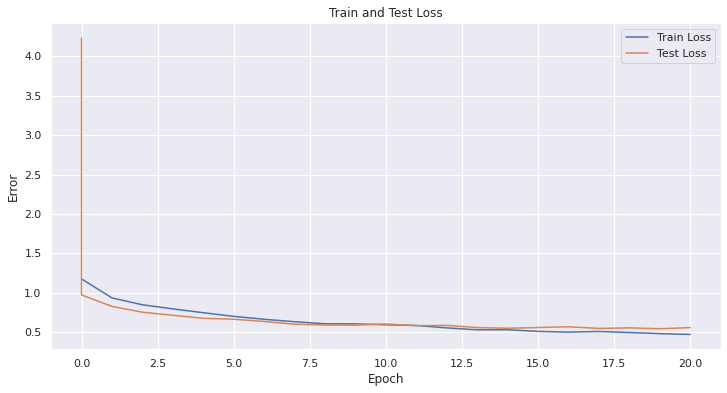

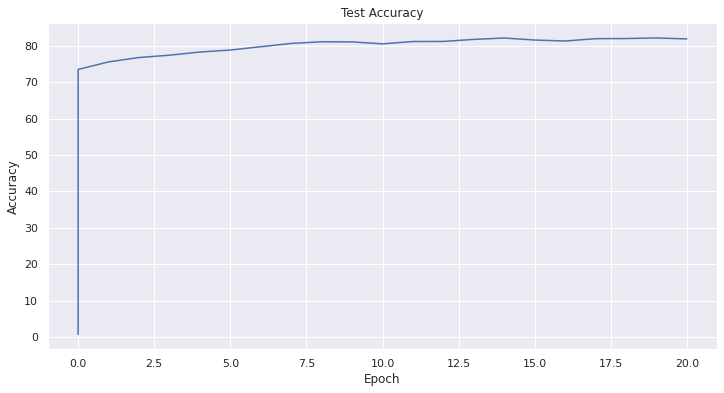

In [17]:
ml_gru_model, ml_en_voc2ind, ml_ind2voc, ml_seq_len, _ = main('ml', 'gru')

Using device cpu
num workers: 48
Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ൽ', 'െ', 'െ', 'െ', 'െ', 'ു', 'െ', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['ൽ', 'െ', 'െ', 'െ', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ൽ', 'ള', 'ള', 'ള', 'ു', 'െ', 'െ', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു', 'ു']



Test set: Average loss: 4.3132, Accuracy: 2116/228544 (1%)



  1%|▏         | 1/70 [00:00<00:12,  5.41it/s]

Train Epoch: 0 [0/35947 (0%)]	Loss: 4.307038


 16%|█▌        | 11/70 [00:02<00:13,  4.42it/s]

Train Epoch: 0 [5120/35947 (14%)]	Loss: 1.228041


 30%|███       | 21/70 [00:04<00:11,  4.21it/s]

Train Epoch: 0 [10240/35947 (29%)]	Loss: 1.063486


 44%|████▍     | 31/70 [00:07<00:08,  4.37it/s]

Train Epoch: 0 [15360/35947 (43%)]	Loss: 1.140278


 59%|█████▊    | 41/70 [00:09<00:06,  4.41it/s]

Train Epoch: 0 [20480/35947 (57%)]	Loss: 1.116564


 73%|███████▎  | 51/70 [00:11<00:04,  4.38it/s]

Train Epoch: 0 [25600/35947 (71%)]	Loss: 1.089236


 87%|████████▋ | 61/70 [00:13<00:02,  4.38it/s]

Train Epoch: 0 [30720/35947 (86%)]	Loss: 1.160355


100%|██████████| 70/70 [00:15<00:00,  4.40it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['വ', '്', 'വ', '്', '്', '്', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['വ', '്', '്', '്', '്', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['വ', '്', 'വ', '്', '്', '്', '്', '്', '്', '്']



Test set: Average loss: 1.0511, Accuracy: 163031/228544 (71%)



  1%|▏         | 1/70 [00:00<00:15,  4.41it/s]

Train Epoch: 1 [0/35947 (0%)]	Loss: 1.124674


 16%|█▌        | 11/70 [00:02<00:12,  4.62it/s]

Train Epoch: 1 [5120/35947 (14%)]	Loss: 1.080413


 30%|███       | 21/70 [00:04<00:11,  4.43it/s]

Train Epoch: 1 [10240/35947 (29%)]	Loss: 0.894888


 44%|████▍     | 31/70 [00:06<00:08,  4.40it/s]

Train Epoch: 1 [15360/35947 (43%)]	Loss: 1.066451


 59%|█████▊    | 41/70 [00:09<00:06,  4.45it/s]

Train Epoch: 1 [20480/35947 (57%)]	Loss: 0.902562


 73%|███████▎  | 51/70 [00:11<00:04,  4.55it/s]

Train Epoch: 1 [25600/35947 (71%)]	Loss: 0.960303


 87%|████████▋ | 61/70 [00:13<00:01,  4.57it/s]

Train Epoch: 1 [30720/35947 (86%)]	Loss: 0.969707


100%|██████████| 70/70 [00:15<00:00,  4.40it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['മ', 'മ', 'സ', 'ാ', '്', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'സ', '്', '്', 'ി', 'ന', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ര', 'ി', 'വ', '്', 'സ', '്']



Test set: Average loss: 0.9787, Accuracy: 165866/228544 (73%)



  1%|▏         | 1/70 [00:00<00:15,  4.55it/s]

Train Epoch: 2 [0/35947 (0%)]	Loss: 0.991407


 16%|█▌        | 11/70 [00:02<00:12,  4.59it/s]

Train Epoch: 2 [5120/35947 (14%)]	Loss: 0.979409


 30%|███       | 21/70 [00:04<00:11,  4.21it/s]

Train Epoch: 2 [10240/35947 (29%)]	Loss: 0.758325


 44%|████▍     | 31/70 [00:06<00:08,  4.48it/s]

Train Epoch: 2 [15360/35947 (43%)]	Loss: 1.024089


 59%|█████▊    | 41/70 [00:09<00:06,  4.56it/s]

Train Epoch: 2 [20480/35947 (57%)]	Loss: 0.790218


 73%|███████▎  | 51/70 [00:11<00:04,  4.37it/s]

Train Epoch: 2 [25600/35947 (71%)]	Loss: 0.905275


 87%|████████▋ | 61/70 [00:13<00:02,  4.46it/s]

Train Epoch: 2 [30720/35947 (86%)]	Loss: 0.837551


100%|██████████| 70/70 [00:15<00:00,  4.48it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['മ', 'മ', 'വ', 'ാ', '്', 'ത', 'ാ', 'വ']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ക', 'ന', 'ന', 'ി', 'ന', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ീ', 'ന', 'വ', '്', '്', 'പ', 'പ', '്']



Test set: Average loss: 0.9424, Accuracy: 168260/228544 (74%)



  1%|▏         | 1/70 [00:00<00:16,  4.15it/s]

Train Epoch: 3 [0/35947 (0%)]	Loss: 0.885764


 16%|█▌        | 11/70 [00:02<00:12,  4.60it/s]

Train Epoch: 3 [5120/35947 (14%)]	Loss: 0.897000


 30%|███       | 21/70 [00:04<00:11,  4.44it/s]

Train Epoch: 3 [10240/35947 (29%)]	Loss: 0.678177


 44%|████▍     | 31/70 [00:06<00:08,  4.34it/s]

Train Epoch: 3 [15360/35947 (43%)]	Loss: 0.975616


 59%|█████▊    | 41/70 [00:09<00:06,  4.32it/s]

Train Epoch: 3 [20480/35947 (57%)]	Loss: 0.743422


 73%|███████▎  | 51/70 [00:11<00:04,  4.36it/s]

Train Epoch: 3 [25600/35947 (71%)]	Loss: 0.816784


 87%|████████▋ | 61/70 [00:13<00:02,  4.40it/s]

Train Epoch: 3 [30720/35947 (86%)]	Loss: 0.790213


100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', '്', 'ാ', '്', 'ത', 'ാ', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', '്', 'ി', 'ന', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ര', 'ര', 'ര', '്', '്', '്', '്', 'പ', 'പ', 'ാ']



Test set: Average loss: 0.8994, Accuracy: 169062/228544 (74%)



  1%|▏         | 1/70 [00:00<00:14,  4.64it/s]

Train Epoch: 4 [0/35947 (0%)]	Loss: 0.805470


 16%|█▌        | 11/70 [00:02<00:13,  4.49it/s]

Train Epoch: 4 [5120/35947 (14%)]	Loss: 0.833563


 30%|███       | 21/70 [00:04<00:11,  4.34it/s]

Train Epoch: 4 [10240/35947 (29%)]	Loss: 0.631787


 44%|████▍     | 31/70 [00:06<00:08,  4.54it/s]

Train Epoch: 4 [15360/35947 (43%)]	Loss: 0.932383


 59%|█████▊    | 41/70 [00:09<00:06,  4.41it/s]

Train Epoch: 4 [20480/35947 (57%)]	Loss: 0.704687


 73%|███████▎  | 51/70 [00:11<00:04,  4.17it/s]

Train Epoch: 4 [25600/35947 (71%)]	Loss: 0.794377


 87%|████████▋ | 61/70 [00:13<00:01,  4.56it/s]

Train Epoch: 4 [30720/35947 (86%)]	Loss: 0.745746


100%|██████████| 70/70 [00:15<00:00,  4.43it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', 'ഗ', '്', '്', 'ത', '്', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ക', '്', '്', 'ി', 'ന', '്', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ര', '്', 'ങ']



Test set: Average loss: 0.8652, Accuracy: 170961/228544 (75%)



  1%|▏         | 1/70 [00:00<00:15,  4.51it/s]

Train Epoch: 5 [0/35947 (0%)]	Loss: 0.760570


 16%|█▌        | 11/70 [00:02<00:13,  4.39it/s]

Train Epoch: 5 [5120/35947 (14%)]	Loss: 0.783038


 30%|███       | 21/70 [00:04<00:11,  4.39it/s]

Train Epoch: 5 [10240/35947 (29%)]	Loss: 0.612602


 44%|████▍     | 31/70 [00:06<00:08,  4.54it/s]

Train Epoch: 5 [15360/35947 (43%)]	Loss: 0.906946


 59%|█████▊    | 41/70 [00:09<00:06,  4.50it/s]

Train Epoch: 5 [20480/35947 (57%)]	Loss: 0.671072


 73%|███████▎  | 51/70 [00:11<00:04,  4.38it/s]

Train Epoch: 5 [25600/35947 (71%)]	Loss: 0.766296


 87%|████████▋ | 61/70 [00:13<00:02,  4.42it/s]

Train Epoch: 5 [30720/35947 (86%)]	Loss: 0.722232


100%|██████████| 70/70 [00:15<00:00,  4.42it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', '്', '്', 'ത', '്', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ക', '്', '്', 'ി', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ര', '്', 'ങ', '്']



Test set: Average loss: 0.8757, Accuracy: 170062/228544 (74%)



  1%|▏         | 1/70 [00:00<00:15,  4.50it/s]

Train Epoch: 6 [0/35947 (0%)]	Loss: 0.745363


 16%|█▌        | 11/70 [00:02<00:13,  4.40it/s]

Train Epoch: 6 [5120/35947 (14%)]	Loss: 0.757463


 30%|███       | 21/70 [00:04<00:10,  4.51it/s]

Train Epoch: 6 [10240/35947 (29%)]	Loss: 0.584757


 44%|████▍     | 31/70 [00:07<00:09,  4.11it/s]

Train Epoch: 6 [15360/35947 (43%)]	Loss: 0.878980


 59%|█████▊    | 41/70 [00:09<00:06,  4.54it/s]

Train Epoch: 6 [20480/35947 (57%)]	Loss: 0.653016


 73%|███████▎  | 51/70 [00:11<00:04,  4.11it/s]

Train Epoch: 6 [25600/35947 (71%)]	Loss: 0.739898


 87%|████████▋ | 61/70 [00:13<00:02,  4.37it/s]

Train Epoch: 6 [30720/35947 (86%)]	Loss: 0.696548


100%|██████████| 70/70 [00:15<00:00,  4.40it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', '്', '്', 'ത', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ക', '്', '്', 'ി', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'യ', '്', 'ങ', 'ങ']



Test set: Average loss: 0.8789, Accuracy: 169059/228544 (74%)



  1%|▏         | 1/70 [00:00<00:14,  4.64it/s]

Train Epoch: 7 [0/35947 (0%)]	Loss: 0.713484


 16%|█▌        | 11/70 [00:02<00:13,  4.28it/s]

Train Epoch: 7 [5120/35947 (14%)]	Loss: 0.722763


 30%|███       | 21/70 [00:04<00:10,  4.56it/s]

Train Epoch: 7 [10240/35947 (29%)]	Loss: 0.563052


 44%|████▍     | 31/70 [00:06<00:08,  4.41it/s]

Train Epoch: 7 [15360/35947 (43%)]	Loss: 0.852718


 59%|█████▊    | 41/70 [00:09<00:06,  4.59it/s]

Train Epoch: 7 [20480/35947 (57%)]	Loss: 0.635720


 73%|███████▎  | 51/70 [00:11<00:04,  4.43it/s]

Train Epoch: 7 [25600/35947 (71%)]	Loss: 0.744653


 87%|████████▋ | 61/70 [00:13<00:02,  4.47it/s]

Train Epoch: 7 [30720/35947 (86%)]	Loss: 0.674633


100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ാ', '്', 'ത', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ര', '്', 'ങ', 'ങ']



Test set: Average loss: 0.8579, Accuracy: 170179/228544 (74%)



  1%|▏         | 1/70 [00:00<00:15,  4.43it/s]

Train Epoch: 8 [0/35947 (0%)]	Loss: 0.682480


 16%|█▌        | 11/70 [00:02<00:12,  4.54it/s]

Train Epoch: 8 [5120/35947 (14%)]	Loss: 0.709022


 30%|███       | 21/70 [00:04<00:11,  4.42it/s]

Train Epoch: 8 [10240/35947 (29%)]	Loss: 0.541240


 44%|████▍     | 31/70 [00:07<00:09,  4.29it/s]

Train Epoch: 8 [15360/35947 (43%)]	Loss: 0.832463


 59%|█████▊    | 41/70 [00:09<00:06,  4.44it/s]

Train Epoch: 8 [20480/35947 (57%)]	Loss: 0.602425


 73%|███████▎  | 51/70 [00:11<00:04,  4.52it/s]

Train Epoch: 8 [25600/35947 (71%)]	Loss: 0.722330


 87%|████████▋ | 61/70 [00:13<00:02,  4.39it/s]

Train Epoch: 8 [30720/35947 (86%)]	Loss: 0.649783


100%|██████████| 70/70 [00:15<00:00,  4.43it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ാ', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ങ']



Test set: Average loss: 0.8377, Accuracy: 171525/228544 (75%)



  1%|▏         | 1/70 [00:00<00:16,  4.31it/s]

Train Epoch: 9 [0/35947 (0%)]	Loss: 0.658821


 16%|█▌        | 11/70 [00:02<00:14,  4.13it/s]

Train Epoch: 9 [5120/35947 (14%)]	Loss: 0.682556


 30%|███       | 21/70 [00:04<00:12,  3.99it/s]

Train Epoch: 9 [10240/35947 (29%)]	Loss: 0.515881


 44%|████▍     | 31/70 [00:07<00:08,  4.55it/s]

Train Epoch: 9 [15360/35947 (43%)]	Loss: 0.806927


 59%|█████▊    | 41/70 [00:09<00:06,  4.52it/s]

Train Epoch: 9 [20480/35947 (57%)]	Loss: 0.589923


 73%|███████▎  | 51/70 [00:11<00:04,  4.52it/s]

Train Epoch: 9 [25600/35947 (71%)]	Loss: 0.715668


 87%|████████▋ | 61/70 [00:13<00:02,  4.44it/s]

Train Epoch: 9 [30720/35947 (86%)]	Loss: 0.609862


100%|██████████| 70/70 [00:15<00:00,  4.42it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', 'ഗ', '്', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', 'ന', '്', 'ി', 'ന', 'ഗ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ങ']



Test set: Average loss: 0.8388, Accuracy: 171505/228544 (75%)



  1%|▏         | 1/70 [00:00<00:16,  4.25it/s]

Train Epoch: 10 [0/35947 (0%)]	Loss: 0.642454


 16%|█▌        | 11/70 [00:02<00:13,  4.36it/s]

Train Epoch: 10 [5120/35947 (14%)]	Loss: 0.657017


 30%|███       | 21/70 [00:04<00:10,  4.56it/s]

Train Epoch: 10 [10240/35947 (29%)]	Loss: 0.506778


 44%|████▍     | 31/70 [00:07<00:08,  4.53it/s]

Train Epoch: 10 [15360/35947 (43%)]	Loss: 0.777054


 59%|█████▊    | 41/70 [00:09<00:06,  4.59it/s]

Train Epoch: 10 [20480/35947 (57%)]	Loss: 0.558588


 73%|███████▎  | 51/70 [00:11<00:04,  4.57it/s]

Train Epoch: 10 [25600/35947 (71%)]	Loss: 0.696947


 87%|████████▋ | 61/70 [00:13<00:02,  4.47it/s]

Train Epoch: 10 [30720/35947 (86%)]	Loss: 0.590212


100%|██████████| 70/70 [00:15<00:00,  4.41it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ക', 'ാ', 'ര', '്', 'ങ']



Test set: Average loss: 0.8047, Accuracy: 173721/228544 (76%)



  1%|▏         | 1/70 [00:00<00:15,  4.60it/s]

Train Epoch: 11 [0/35947 (0%)]	Loss: 0.636473


 16%|█▌        | 11/70 [00:02<00:12,  4.62it/s]

Train Epoch: 11 [5120/35947 (14%)]	Loss: 0.621933


 30%|███       | 21/70 [00:04<00:13,  3.76it/s]

Train Epoch: 11 [10240/35947 (29%)]	Loss: 0.473696


 44%|████▍     | 31/70 [00:07<00:09,  4.27it/s]

Train Epoch: 11 [15360/35947 (43%)]	Loss: 0.756495


 59%|█████▊    | 41/70 [00:09<00:07,  3.96it/s]

Train Epoch: 11 [20480/35947 (57%)]	Loss: 0.546476


 73%|███████▎  | 51/70 [00:12<00:04,  4.25it/s]

Train Epoch: 11 [25600/35947 (71%)]	Loss: 0.711584


 87%|████████▋ | 61/70 [00:14<00:02,  4.36it/s]

Train Epoch: 11 [30720/35947 (86%)]	Loss: 0.571434


100%|██████████| 70/70 [00:16<00:00,  4.24it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', 'ഗ', '്', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', 'ന', '്', 'ന', 'ന', 'ഗ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ക', 'ാ', 'ര', '്', 'ങ']



Test set: Average loss: 0.7893, Accuracy: 174830/228544 (76%)



  1%|▏         | 1/70 [00:00<00:16,  4.20it/s]

Train Epoch: 12 [0/35947 (0%)]	Loss: 0.621352


 16%|█▌        | 11/70 [00:02<00:13,  4.48it/s]

Train Epoch: 12 [5120/35947 (14%)]	Loss: 0.601402


 30%|███       | 21/70 [00:04<00:10,  4.55it/s]

Train Epoch: 12 [10240/35947 (29%)]	Loss: 0.463762


 44%|████▍     | 31/70 [00:06<00:09,  4.32it/s]

Train Epoch: 12 [15360/35947 (43%)]	Loss: 0.744452


 59%|█████▊    | 41/70 [00:09<00:06,  4.34it/s]

Train Epoch: 12 [20480/35947 (57%)]	Loss: 0.533533


 73%|███████▎  | 51/70 [00:11<00:04,  4.41it/s]

Train Epoch: 12 [25600/35947 (71%)]	Loss: 0.676052


 87%|████████▋ | 61/70 [00:13<00:02,  4.13it/s]

Train Epoch: 12 [30720/35947 (86%)]	Loss: 0.559704


100%|██████████| 70/70 [00:16<00:00,  4.35it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', 'ന', '്', 'ന', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ങ']



Test set: Average loss: 0.8043, Accuracy: 174982/228544 (77%)



  1%|▏         | 1/70 [00:00<00:15,  4.34it/s]

Train Epoch: 13 [0/35947 (0%)]	Loss: 0.594807


 16%|█▌        | 11/70 [00:02<00:13,  4.31it/s]

Train Epoch: 13 [5120/35947 (14%)]	Loss: 0.576995


 30%|███       | 21/70 [00:04<00:11,  4.28it/s]

Train Epoch: 13 [10240/35947 (29%)]	Loss: 0.448661


 44%|████▍     | 31/70 [00:07<00:09,  4.17it/s]

Train Epoch: 13 [15360/35947 (43%)]	Loss: 0.726051


 59%|█████▊    | 41/70 [00:09<00:06,  4.19it/s]

Train Epoch: 13 [20480/35947 (57%)]	Loss: 0.524308


 73%|███████▎  | 51/70 [00:12<00:04,  4.25it/s]

Train Epoch: 13 [25600/35947 (71%)]	Loss: 0.681061


 87%|████████▋ | 61/70 [00:14<00:02,  3.85it/s]

Train Epoch: 13 [30720/35947 (86%)]	Loss: 0.536788


100%|██████████| 70/70 [00:16<00:00,  4.18it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'ം', 'ഗ', 'ന', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', '്', 'ന', 'ി', 'ന', '്', 'ങ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ങ']



Test set: Average loss: 0.8175, Accuracy: 174551/228544 (76%)



  1%|▏         | 1/70 [00:00<00:16,  4.16it/s]

Train Epoch: 14 [0/35947 (0%)]	Loss: 0.602469


 16%|█▌        | 11/70 [00:02<00:14,  4.17it/s]

Train Epoch: 14 [5120/35947 (14%)]	Loss: 0.569632


 30%|███       | 21/70 [00:05<00:11,  4.24it/s]

Train Epoch: 14 [10240/35947 (29%)]	Loss: 0.427294


 44%|████▍     | 31/70 [00:07<00:09,  4.17it/s]

Train Epoch: 14 [15360/35947 (43%)]	Loss: 0.704014


 59%|█████▊    | 41/70 [00:09<00:06,  4.47it/s]

Train Epoch: 14 [20480/35947 (57%)]	Loss: 0.498951


 73%|███████▎  | 51/70 [00:12<00:04,  3.95it/s]

Train Epoch: 14 [25600/35947 (71%)]	Loss: 0.660533


 87%|████████▋ | 61/70 [00:14<00:02,  4.15it/s]

Train Epoch: 14 [30720/35947 (86%)]	Loss: 0.521960


100%|██████████| 70/70 [00:16<00:00,  4.18it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ന', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', 'ന', 'ന', 'ന', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ഗ']



Test set: Average loss: 0.8144, Accuracy: 175204/228544 (77%)



  1%|▏         | 1/70 [00:00<00:15,  4.40it/s]

Train Epoch: 15 [0/35947 (0%)]	Loss: 0.565722


 16%|█▌        | 11/70 [00:02<00:13,  4.42it/s]

Train Epoch: 15 [5120/35947 (14%)]	Loss: 0.548826


 30%|███       | 21/70 [00:04<00:11,  4.26it/s]

Train Epoch: 15 [10240/35947 (29%)]	Loss: 0.428756


 44%|████▍     | 31/70 [00:07<00:08,  4.35it/s]

Train Epoch: 15 [15360/35947 (43%)]	Loss: 0.691314


 59%|█████▊    | 41/70 [00:09<00:06,  4.41it/s]

Train Epoch: 15 [20480/35947 (57%)]	Loss: 0.482645


 73%|███████▎  | 51/70 [00:11<00:04,  4.37it/s]

Train Epoch: 15 [25600/35947 (71%)]	Loss: 0.668673


 87%|████████▋ | 61/70 [00:14<00:02,  4.47it/s]

Train Epoch: 15 [30720/35947 (86%)]	Loss: 0.508276


100%|██████████| 70/70 [00:16<00:00,  4.36it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['ആ', 'മ', 'ഗ', 'ന', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', 'ന', '്', 'ന', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ഗ']



Test set: Average loss: 0.8240, Accuracy: 173840/228544 (76%)



  1%|▏         | 1/70 [00:00<00:14,  4.66it/s]

Train Epoch: 16 [0/35947 (0%)]	Loss: 0.537420


 16%|█▌        | 11/70 [00:02<00:13,  4.41it/s]

Train Epoch: 16 [5120/35947 (14%)]	Loss: 0.527066


 30%|███       | 21/70 [00:04<00:11,  4.30it/s]

Train Epoch: 16 [10240/35947 (29%)]	Loss: 0.422670


 44%|████▍     | 31/70 [00:07<00:09,  4.02it/s]

Train Epoch: 16 [15360/35947 (43%)]	Loss: 0.670812


 59%|█████▊    | 41/70 [00:09<00:06,  4.16it/s]

Train Epoch: 16 [20480/35947 (57%)]	Loss: 0.468275


 73%|███████▎  | 51/70 [00:12<00:04,  3.92it/s]

Train Epoch: 16 [25600/35947 (71%)]	Loss: 0.631002


 87%|████████▋ | 61/70 [00:14<00:02,  3.89it/s]

Train Epoch: 16 [30720/35947 (86%)]	Loss: 0.490420


100%|██████████| 70/70 [00:16<00:00,  4.15it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ന', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['മ', 'ാ', 'ന', 'ന', 'ന', 'ന', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ഗ']



Test set: Average loss: 0.8117, Accuracy: 174800/228544 (76%)



  1%|▏         | 1/70 [00:00<00:16,  4.11it/s]

Train Epoch: 17 [0/35947 (0%)]	Loss: 0.526193


 16%|█▌        | 11/70 [00:02<00:14,  4.04it/s]

Train Epoch: 17 [5120/35947 (14%)]	Loss: 0.533038


 30%|███       | 21/70 [00:05<00:11,  4.17it/s]

Train Epoch: 17 [10240/35947 (29%)]	Loss: 0.419335


 44%|████▍     | 31/70 [00:07<00:09,  4.10it/s]

Train Epoch: 17 [15360/35947 (43%)]	Loss: 0.655706


 59%|█████▊    | 41/70 [00:10<00:07,  3.69it/s]

Train Epoch: 17 [20480/35947 (57%)]	Loss: 0.464714


 73%|███████▎  | 51/70 [00:12<00:04,  4.25it/s]

Train Epoch: 17 [25600/35947 (71%)]	Loss: 0.643436


 87%|████████▋ | 61/70 [00:14<00:01,  4.58it/s]

Train Epoch: 17 [30720/35947 (86%)]	Loss: 0.492949


100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'ം', 'ഗ', 'ന', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['ര', 'ാ', 'ന', '്', 'ന', 'ി', 'ങ', '്']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ര', '്', 'ഗ']



Test set: Average loss: 0.8430, Accuracy: 173267/228544 (76%)



  1%|▏         | 1/70 [00:00<00:14,  4.68it/s]

Train Epoch: 18 [0/35947 (0%)]	Loss: 0.507103


 16%|█▌        | 11/70 [00:02<00:13,  4.30it/s]

Train Epoch: 18 [5120/35947 (14%)]	Loss: 0.510110


 30%|███       | 21/70 [00:04<00:11,  4.23it/s]

Train Epoch: 18 [10240/35947 (29%)]	Loss: 0.392639


 44%|████▍     | 31/70 [00:07<00:09,  4.07it/s]

Train Epoch: 18 [15360/35947 (43%)]	Loss: 0.646335


 59%|█████▊    | 41/70 [00:09<00:06,  4.24it/s]

Train Epoch: 18 [20480/35947 (57%)]	Loss: 0.456159


 73%|███████▎  | 51/70 [00:11<00:04,  4.40it/s]

Train Epoch: 18 [25600/35947 (71%)]	Loss: 0.621685


 87%|████████▋ | 61/70 [00:14<00:02,  3.90it/s]

Train Epoch: 18 [30720/35947 (86%)]	Loss: 0.469704


100%|██████████| 70/70 [00:16<00:00,  4.25it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ന', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['ര', 'ാ', 'ാ', 'ന', 'ന', 'ന', 'ങ', 'ങ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ര', '്', 'ങ']



Test set: Average loss: 0.8327, Accuracy: 173721/228544 (76%)



  1%|▏         | 1/70 [00:00<00:16,  4.17it/s]

Train Epoch: 19 [0/35947 (0%)]	Loss: 0.505177


 16%|█▌        | 11/70 [00:02<00:13,  4.48it/s]

Train Epoch: 19 [5120/35947 (14%)]	Loss: 0.497378


 30%|███       | 21/70 [00:04<00:10,  4.59it/s]

Train Epoch: 19 [10240/35947 (29%)]	Loss: 0.386159


 44%|████▍     | 31/70 [00:06<00:08,  4.59it/s]

Train Epoch: 19 [15360/35947 (43%)]	Loss: 0.621861


 59%|█████▊    | 41/70 [00:09<00:06,  4.44it/s]

Train Epoch: 19 [20480/35947 (57%)]	Loss: 0.439657


 73%|███████▎  | 51/70 [00:11<00:04,  4.37it/s]

Train Epoch: 19 [25600/35947 (71%)]	Loss: 0.612546


 87%|████████▋ | 61/70 [00:14<00:02,  3.86it/s]

Train Epoch: 19 [30720/35947 (86%)]	Loss: 0.455831


100%|██████████| 70/70 [00:16<00:00,  4.33it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ന', '്', 'ത']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['ര', 'ര', 'ന', 'ണ', 'ന', 'ന', 'ങ', 'ങ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ി', 'ര', '്', 'ഗ']



Test set: Average loss: 0.8530, Accuracy: 173123/228544 (76%)



  1%|▏         | 1/70 [00:00<00:14,  4.66it/s]

Train Epoch: 20 [0/35947 (0%)]	Loss: 0.489912


 16%|█▌        | 11/70 [00:02<00:13,  4.37it/s]

Train Epoch: 20 [5120/35947 (14%)]	Loss: 0.482502


 30%|███       | 21/70 [00:05<00:11,  4.10it/s]

Train Epoch: 20 [10240/35947 (29%)]	Loss: 0.373275


 44%|████▍     | 31/70 [00:07<00:08,  4.40it/s]

Train Epoch: 20 [15360/35947 (43%)]	Loss: 0.608766


 59%|█████▊    | 41/70 [00:09<00:06,  4.37it/s]

Train Epoch: 20 [20480/35947 (57%)]	Loss: 0.428627


 73%|███████▎  | 51/70 [00:11<00:04,  4.52it/s]

Train Epoch: 20 [25600/35947 (71%)]	Loss: 0.602035


 87%|████████▋ | 61/70 [00:14<00:02,  4.42it/s]

Train Epoch: 20 [30720/35947 (86%)]	Loss: 0.440254


100%|██████████| 70/70 [00:16<00:00,  4.30it/s]


Input	['a', 'm', 'g', 'a', 't', 'h', 'a', 'v', 'a', 'v', 'u', 'm']
GT	['അ', 'ം', 'ഗ', 'ത', '്', 'വ', 'വ', 'ു', 'ം']
pred	['അ', 'മ', 'ഗ', 'ന', '്']


Input	['m', 'a', 'n', 'n', 'i', 'n', 'g']
GT	['മ', 'ാ', 'ന', 'ി', 'ം', 'ഗ', '്']
pred	['ഹ', 'ാ', 'ന', '്', 'ന', 'ന', 'ങ', 'ങ']


Input	['t', 'h', 'e', 'n', 'g', 'a', 'a', 'p', 'p', 'a', 'a', 'l']
GT	['ത', 'േ', 'ങ', '്', 'ങ', 'ാ', 'പ', '്', 'പ', 'ാ', 'ൽ']
pred	['ത', 'ാ', 'ക', '്', 'ഗ']



Test set: Average loss: 0.8604, Accuracy: 173070/228544 (76%)



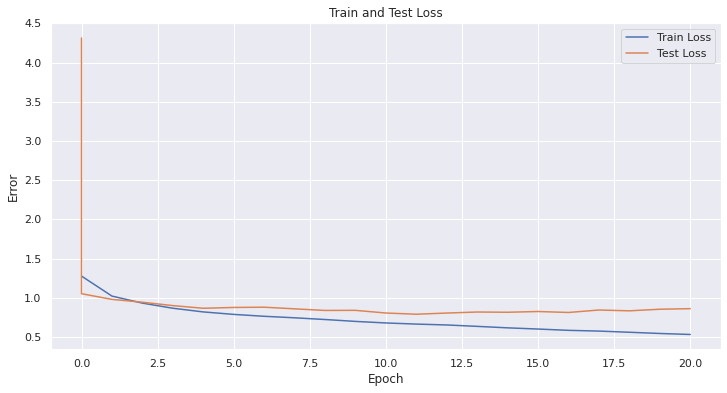

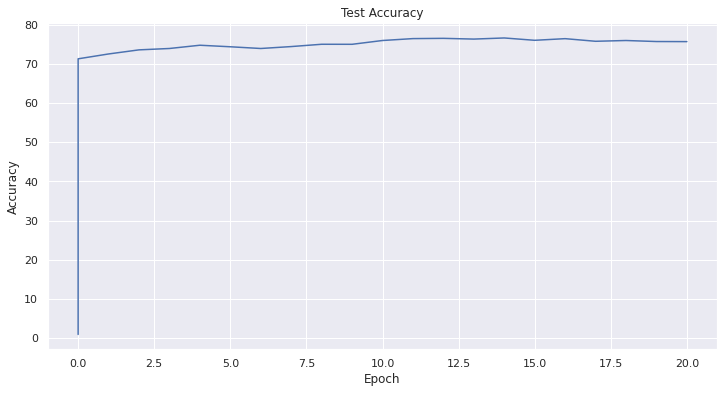

In [18]:
ml_lstm_model, _, _, _, _ = main('ml', 'lstm')

In [20]:
print('Saving best Tamil model')
ta_gru_model.save_model('model/ta_gru.pt', 0)

Saving best Tamil model
Saved model/ta_gru.pt



In [27]:
pickle.dump({'en_voc2ind': ta_en_voc2ind, 'lang_ind2voc': ta_ind2voc, 'seq_len': ta_seq_len}, open('./vars/ta.pkl', 'wb'))

In [25]:
''.join(generate_transliteration('panthu', ta_gru_model, ta_en_voc2ind, ta_ind2voc, ta_seq_len))

'பா்ட'

In [28]:
# Try loading back vars
with open('./vars/ta.pkl', 'rb') as data_pkl:
    variables = pickle.load(data_pkl)
loaded_voc2ind = variables['en_voc2ind']
loaded_ind2voc = variables['lang_ind2voc']
loaded_seq_len = variables['seq_len']

In [29]:
# Try loading back model (for demo)
loaded_model = TransliterateNet(len(loaded_voc2ind), len(loaded_ind2voc), feature_size=128, rnn_type='gru').to(device)
loaded_model.load_model('model/ta_gru.pt')

Restoring:
encoder.weight -> 	torch.Size([27, 128]) = 0MB
midLayer.weight -> 	torch.Size([128, 128]) = 0MB
midLayer.bias -> 	torch.Size([128]) = 0MB
decoder.weight -> 	torch.Size([47, 128]) = 0MB
decoder.bias -> 	torch.Size([47]) = 0MB
rnn.weight_ih_l0 -> 	torch.Size([384, 128]) = 0MB
rnn.weight_hh_l0 -> 	torch.Size([384, 128]) = 0MB
rnn.bias_ih_l0 -> 	torch.Size([384]) = 0MB
rnn.bias_hh_l0 -> 	torch.Size([384]) = 0MB
rnn2.weight_ih_l0 -> 	torch.Size([384, 128]) = 0MB
rnn2.weight_hh_l0 -> 	torch.Size([384, 128]) = 0MB
rnn2.bias_ih_l0 -> 	torch.Size([384]) = 0MB
rnn2.bias_hh_l0 -> 	torch.Size([384]) = 0MB

Restored all variables
No new variables
Restored model/ta_gru.pt


In [30]:
# Try generating transliteration with loaded model; should be same as the previous transliteration
''.join(generate_transliteration('panthu', loaded_model, loaded_voc2ind, loaded_ind2voc, loaded_seq_len))

'பா்ட'

In [31]:
# Now that saving works, save best model and vars for all languages (for safety)
ml_gru_model.save_model('model/ml_gru.pt', 0)
pickle.dump({'en_voc2ind': ml_en_voc2ind, 'lang_ind2voc': ml_ind2voc, 'seq_len': ml_seq_len}, open('./vars/ml.pkl', 'wb'))

Saved model/ml_gru.pt



In [32]:
bn_gru_model.save_model('model/bn_gru.pt', 0)
pickle.dump({'en_voc2ind': bn_en_voc2ind, 'lang_ind2voc': bn_ind2voc, 'seq_len': bn_seq_len}, open('./vars/bn.pkl', 'wb'))

Saved model/bn_gru.pt



In [33]:
hi_gru_model.save_model('model/hi_gru.pt', 0)
pickle.dump({'en_voc2ind': hi_en_voc2ind, 'lang_ind2voc': hi_ind2voc, 'seq_len': hi_seq_len}, open('./vars/hi.pkl', 'wb'))

Saved model/hi_gru.pt

